In [1]:
from bs4 import BeautifulSoup     #网页解析，获取数据\n",
import re       #正则表达式，进行文字匹配\n",
import urllib.request,urllib.error      #制定URL，获取网页数据\n",
# import xlwt     #进行excel操作\n",
import sqlite3  #进行SQLite数据库操作\n",
import pandas as pd #存储数据及处理数据\n",
import numpy as np
import requests
import random
import time
from collections import defaultdict
from collections import deque
from collections import Counter
import collections
import json
import sys
import datetime
import os
import csv
from math import *
# from geopy.distance import geodesic
# from pyproj import Proj
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [9]:
# 数据示例
df_i=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\basic_dbscan_result\hangzhou_1_to_4.csv')
df_i_xy=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\basic_xy\hangzhou_result.csv',dtype='str')
df_i_ori2=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\basic_info_newdata\hangzhouNewData20230503.csv',dtype='str')
df_i_ori1=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\origin_info\dw_dazhongdianping_杭州.csv',dtype='str',sep = '\t')

In [1]:
from sklearn.neighbors import KDTree
import math
# from math import *
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pandas as pd #存储数据及处理数据\n",
import numpy as np
import time
from collections import *
import os
import datetime
import time
import random
import sys

# 计算点密度对应的r半径内判断是否为核心点的点数阈值
def min_pts_cal(point_density,r):
    # point_density为某等级商圈对应的点密度
    # r为dbscan计算所需要的半径参数
    # 14100*（3.1415926535897932384626433832795   ×   100   ×   100÷   1000000 ）
    min_pts=round(point_density*(math.pi*math.pow(r,2)/1000000))
    
    return min_pts

# 计算各大众点评点位的四个等级的商圈标签
def tier_define(val_i,ls_loc,r,df_total,df_result_final):
    for le in range(1,5):
        min_sample_i=min_pts_cal(val_i[le],r)
        db_loc = DBSCAN(eps=r, min_samples=min_sample_i).fit(ls_loc)
        if len(db_loc.labels_)==len(df_total):
            # 得到核心点的坐标和index
            df_1=pd.DataFrame(db_loc.components_)
            df_2=pd.DataFrame(db_loc.core_sample_indices_)
            df_3=pd.concat([df_2,df_1],axis=1)
            df_3.columns=['index_1','db_x','db_y']

            # 给每个点都标上dbscan计算得到label
            df_total_1=df_total.reset_index()
            labels = db_loc.labels_
            df_total_1.loc[:,'labels'] = labels

            # 把核心点和全量数据融合
            df_result_1=pd.merge(left=df_total_1,right=df_3,left_on=['index','POINT_X','POINT_Y'],
                                 right_on=['index_1','db_x','db_y'],how='outer')
            # 验证数据完整性
            if len(df_result_1)==len(df_total_1):
                # 验证通过后，将每个核心点所属的簇给标上
                core_label='core_'+str(le)
                df_result_1.loc[(df_result_1['labels']!=-1)&(df_result_1['db_x'].notnull()),
                                core_label] = df_result_1['labels']
                if len(df_result_1.loc[df_result_1[core_label].notnull()])==len(db_loc.core_sample_indices_):
                    df_result_2=df_result_1.loc[:,['dianping_shops_2021.shop_id',core_label]]
                    if le>1 and len(df_result_2)!=len(df_result_final):
                        print('error:不同等级的核心点计算过程中出现问题')
                        print('df_result_2',len(df_result_2))
                        print('df_result_final',len(df_result_final))
                    else:
                        df_result_final=pd.merge(left=df_result_final,right=df_result_2,
                                                 left_on=['dianping_shops_2021_shop_id'],
                                                 right_on=['dianping_shops_2021.shop_id'],
                                                 how='outer')
                        df_result_final.drop(columns='dianping_shops_2021.shop_id',inplace=True)
                        print(i,le)
                else:
                    print('error:核心点数量在数据融合过程中出现问题')
            else:
                print('error:核心点数据和全量数据融合出现问题')
        else:
            print('error:dbscan计算结果的数据量有问题')
    
    return df_result_final

# 计算各点领域内点的个数
# 距离计算
def distance(p_x1,p_y1,p_x2,p_y2):
    dis = np.sqrt(np.sum(np.power(np.array([p_x1,p_y1]) - np.array([p_x2,p_y2]),2)))
    return dis

# 根据半径截取对应的点数据集进行距离计算和核心点判断
def cut_area(dataframe,r,p_x1,p_y1,p_id):
    lon_thre_n=p_x1-r
    lon_thre_p=p_x1+r
    lat_thre_n=p_y1-r
    lat_thre_p=p_y1+r
    df_temp = dataframe.loc[(dataframe['POINT_X']<=lon_thre_p)&
                            (dataframe['POINT_X']>=lon_thre_n)&
                            (dataframe['POINT_Y']<=lat_thre_p)&
                            (dataframe['POINT_Y']>=lat_thre_n)&
                           (dataframe['dianping_shops_2021_shop_id']!=p_id)]
    return df_temp

# 根据点领域内的点的数量，确定是否为核心点
def area_pts(df_temp,r,p_x1,p_y1,p_id):
    df_setup=df_temp.loc[df_temp['dianping_shops_2021_shop_id']==p_id]
    if len(df_setup)!=0:
        return 'error'
    else:
        count=0
        for i in range(len(df_temp)):
            p_x2=df_temp.loc[i,'POINT_X']
            p_y2=df_temp.loc[i,'POINT_Y']
            dis=distance(p_x1,p_y1,p_x2,p_y2)
            if dis<=r:
                count+=1
        return count

# 使用kdtree方式快速找到一个点到一堆点的最短距离
def kdtree_div(df_sample,str_b_up,str_b_div):
    df_X_1=df_sample.loc[df_sample[str_b_up].notnull()].reset_index()
    X_1=df_X_1.loc[:,['POINT_X','POINT_Y']].values.tolist()
    tree = KDTree(X_1,metric='euclidean')
    df_x_query=df_sample.loc[df_sample[str_b_up].isnull()]
    x_query=df_x_query.loc[:,['POINT_X','POINT_Y']].values.tolist()
    array_1=tree.query(x_query)[1]
    ls_index=[b for x in array_1 for b in x]
    ls_new=df_X_1.iloc[ls_index][str_b_up].tolist()
    df_x_query.loc[:,str_b_div]=ls_new
    df_merge=pd.merge(left=df_sample,right=df_x_query.loc[:,['dianping_shops_2021_shop_id',str_b_div]],
                      on=['dianping_shops_2021_shop_id'],how='outer')
    if len(df_merge)==len(df_sample):
        df_merge.loc[df_merge[str_b_div].isnull(),str_b_div]=df_merge[str_b_up]
        return df_merge.loc[:,['dianping_shops_2021_shop_id',str_b_div]]
    else:
        return print('error:kdtree计算结果有问题')

# 重聚类时使用dbscan对点进行根据新的距离的二次聚类
def re_clu_db(r_tar,min_pts_a,ls_loc,df_db_a,core_label,a):
    db_loc = DBSCAN(eps=r_tar, min_samples=min_pts_a).fit(ls_loc)
    if len(db_loc.labels_)==len(df_db_a):

        # 得到核心点的坐标和index
        df_1=pd.DataFrame(db_loc.components_)
        df_2=pd.DataFrame(db_loc.core_sample_indices_)
        df_3=pd.concat([df_2,df_1],axis=1)
        df_3.columns=['index_1','db_x','db_y']

        # 给每个点都标上dbscan计算得到label
        df_db_a_1=df_db_a.reset_index()
        labels = db_loc.labels_
        df_db_a_1.loc[:,'labels'] = labels

        # 把核心点和全量数据融合
        df_result_1=pd.merge(left=df_db_a_1,right=df_3,left_on=['index','POINT_X','POINT_Y'],
                             right_on=['index_1','db_x','db_y'],how='outer')
        # 验证数据完整性
        if len(df_result_1)==len(df_db_a_1):
            # 验证通过后，将每个核心点所属的簇给标上
            if a==[]:
                df_result_1.loc[(df_result_1['labels']!=-1)&
                                (df_result_1['db_x'].notnull()),
                                core_label] = 're_'+df_result_1['labels'].astype(int).astype(str)
            else:
                df_result_1.loc[(df_result_1['labels']!=-1)&
                                (df_result_1['db_x'].notnull()),
                                core_label] = 're_'+str(int(a))+'_'+df_result_1['labels'].astype(int).astype(str)
            if len(df_result_1.loc[df_result_1[core_label].notnull()])==len(db_loc.core_sample_indices_):
                df_result_2=df_result_1.loc[:,['dianping_shops_2021_shop_id',core_label]]
                return df_result_2
            else:
                return print('error:核心点数量在数据融合过程中出现问题')
        else:
            return print('error:核心点数据和全量数据融合出现问题')
    else:
        return print('error:dbscan计算结果的数据量有问题')
    
#生成最大生成树
_=float('inf')
def prim(graph,n):
    for i in range(n):
        for j in range(n):
            if graph[i][j] >0:
                graph[i][j] = float(1)/graph[i][j]
            if graph[i][j] == 0:
                graph[i][j] = _
    dis=[0]*n
    pre=[0]*n
    flag=[False]*n
    flag[0]=True
    k=0
    for i in range(n):
        dis[i]=graph[k][i]
    # print dis
    for j in range(n-1):
        mini=_
        for i in range(n):
            if mini>dis[i] and not flag[i]:
                mini=dis[i]
                k=i
        # print k

        if k==0:
            return
        flag[k]=True
        for i in range(n):
            if dis[i]>graph[k][i] and not flag[i]:
                dis[i]=graph[k][i]
                pre[i]=k
        # print dis
    dis = [float(1)/i for i in dis]
    return dis,pre

# n阶图谱单元选择
def select_cell(city_name,n,dataframe):
    # city_name为当前读取数据的城市名称
    # n为图谱绘制的联系单元阶数，如0，1，2...
    # dataframe 是200m长宽的单元的顶点坐标数据集
    # 输出数据为['PageName','PageName_n']，表示各单元对应n阶单元id集合
    
    ls_cell_id=dataframe['PageName'].unique().tolist()
    ls_result=[]
    for i in ls_cell_id:
        df_loc_i=dataframe.loc[dataframe['PageName']==i]
        for a in range(n):
            df_loc_new=df_loc_i.drop_duplicates(['POINT_X','POINT_Y'])
            ls_x=df_loc_new['POINT_X'].unique().tolist()
            ls_y=df_loc_new['POINT_Y'].unique().tolist()
            df_loc_i=dataframe.loc[(dataframe['POINT_X'].isin(ls_x))&(dataframe['POINT_Y'].isin(ls_y))]
        ls_surround=df_loc_i['PageName'].unique().tolist()
        ls_surround_filt=[x for x in ls_surround if x != i]
        for a in ls_surround_filt:
            ls_i=[i]
            ls_i.append(a)
            ls_result.append(ls_i)
    return ls_result

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [28]:
import os
import time

# 1）python2.7
# 2) python2.7
# 3）计算各等级点密度值对应的dbscan邻域内点数量阈值 python3
df_pts_den=pd.read_excel(r'E:\project_basedata\2023data_research\basedata\basic_point_density\point_density.xlsx')
ls_city=df_pts_den['city'].unique().tolist()
type_city_clu=input('请输入城市dbscan计算结果的更新方式（a/b）[a代表全量，b代表增量，c代表选择特定城市]：')
r_input=input('请输入要进行dbscan的半径（m）：')
r=int(r_input)

# 4）根据各点密度等级对应的dbscan参数，输入basic_xy进行计算，将输出结果合并得到每个等级的核心点的basic_dbscan_result ， 
# basic_dbscan_result数据结构为：shopid，核心点簇id，核心点等级 
ls_xy=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_xy')
ls_info=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_info_newdata')
ls_dbscan_result=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_dbscan_result')
start = time.time()
if type_city_clu == 'a':
    for i in ls_city:
        df_level_i=df_pts_den.loc[df_pts_den['city']==i]
        val_i=df_level_i.values.tolist()[0]
        i_=i+'_'
        for j in ls_xy:
            if i_ in j and j.endswith('_result.csv'):
                df_xy=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_xy\\'+j)
                print(j,len(df_xy))
                break
        i_new=i+'N'
        for a in ls_info:
            if i_new in a and a.endswith('.csv'):
                df_info=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_info_newdata\\'+a,dtype=str)
                line=df_info.columns.tolist()
                if 'longitude' in line:
                    df_info.rename(columns={'shop_id':'dianping_shops_2021.shop_id',
                                            'longitude':'dianping_shops_2021.longitude',
                                            'latitude':'dianping_shops_2021.latitude'},inplace=True)
                df_info=df_info.astype(dtype={'dianping_shops_2021.shop_id':'int',
                                              'dianping_shops_2021.longitude':'float',
                                              'dianping_shops_2021.latitude':'float'})
                print(a,len(df_info))
                break
        
        if len(df_xy)==len(df_info):
            df_xy_wash=df_xy.dropna(subset=['POINT_X','POINT_Y'])
            df_total=pd.merge(left=df_info,right=df_xy_wash,left_on=['dianping_shops_2021.shop_id'],
                              right_on=['dianping_shops_2021_shop_id'],
                              how='right')

            if len(df_total)==len(df_xy_wash):
                df_xy_wash_loc=df_xy_wash.loc[:,['POINT_X','POINT_Y']]
                ls_loc = df_xy_wash_loc.values.tolist()
                df_result_final=df_xy_wash.copy()
                df_result_final_1=tier_define(val_i,ls_loc,r,df_total,df_result_final)
            else:
                print(r'error:坐标去空值后融合出现问题')
        else:
            print(j,a)
            print(r'error:坐标转换有问题')
        
# 5）basic_dbscan_result里面包含一个城市四个点密度等级对应簇id数据和每个点对应的经纬度 
        df_info_xy=df_info.loc[:,['dianping_shops_2021.shop_id','dianping_shops_2021.longitude',
                                  'dianping_shops_2021.latitude']]
        df_result_final_2=pd.merge(left=df_result_final_1,right=df_info_xy,
                                   left_on=['dianping_shops_2021_shop_id'],right_on=['dianping_shops_2021.shop_id'],
                                   how='left')
        if len(df_result_final_2)==len(df_result_final_1):
            df_result_final_2.drop(columns='dianping_shops_2021.shop_id',inplace=True)
            df_result_final_2.fillna(value=-1,inplace=True)
            df_result_final_2.to_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_dbscan_result\\'+
                                     i+'_'+str(r)+'_1_to_4.csv',
                                     index=False,mode='w')
            print(len(df_xy))
            print(len(df_result_final_2))
        else:
            print(r'error:增加经纬度坐标时出错')
        end = time.time()
        runTime = end - start
        print("运行时间：", runTime)
        
elif type_city_clu == 'b':
    ls0 = os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_dbscan_result')
    ls_p=[]
    for i in ls_city:
        for j in ls0:
            if i in j:
                ls_p.append(i)
                continue
    ls_city_p = [x for x in ls_city if x not in ls_p]
    for i in ls_city_p:
        df_level_i=df_pts_den.loc[df_pts_den['city']==i]
        val_i=df_level_i.values.tolist()[0]

        for j in ls_xy:
            if i in j and j.endswith('_result.csv'):
                df_xy=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_xy\\'+j)
                break
        for a in ls_info:
            if i in a and a.endswith('.csv'):
                df_info=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_info\\'+a,dtype=str)
                df_info=df_info.astype(dtype={'dianping_shops_2021.shop_id':'int',
                                              'dianping_shops_2021.longitude':'float',
                                              'dianping_shops_2021.latitude':'float'})
                break
        
        if len(df_xy)==len(df_info):
            df_xy_wash=df_xy.dropna(subset=['POINT_X','POINT_Y'])
            df_total=pd.merge(left=df_info,right=df_xy_wash,left_on=['dianping_shops_2021.shop_id'],
                              right_on=['dianping_shops_2021_shop_id'],
                              how='right')

            if len(df_total)==len(df_xy_wash):
                df_xy_wash_loc=df_xy_wash.loc[:,['POINT_X','POINT_Y']]
                ls_loc = df_xy_wash_loc.values.tolist()
                df_result_final=df_xy_wash.copy()
                df_result_final_1=tier_define(val_i,ls_loc,r,df_total,df_result_final)
            else:
                print(r'error:坐标去空值后融合出现问题')
        else:
            print(j,a)
            print(r'error:坐标转换有问题')
        
# 5）basic_dbscan_result里面包含一个城市四个点密度等级对应簇id数据和每个点对应的经纬度 
        df_info_xy=df_info.loc[:,['dianping_shops_2021.shop_id','dianping_shops_2021.longitude',
                                  'dianping_shops_2021.latitude']]
        df_result_final_2=pd.merge(left=df_result_final_1,right=df_info_xy,
                                   left_on=['dianping_shops_2021_shop_id'],
                                   right_on=['dianping_shops_2021.shop_id'],how='left')
        if len(df_result_final_2)==len(df_result_final_1):
            df_result_final_2.drop(columns='dianping_shops_2021.shop_id',inplace=True)
            df_result_final_2.fillna(value=-1,inplace=True)
            df_result_final_2.to_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_dbscan_result\\'+
                                     i+'_'+str(r)+'_1_to_4.csv',index=False,mode='w')
        else:
            print(r'error:增加经纬度坐标时出错')
        
        end = time.time()
        runTime = end - start
        print("运行时间：", runTime)
        
elif type_city_clu == 'c':
    print('可供选择的城市列表',ls_city)
    str_city_count=input('请输入要计算领域内点数量的城市，从可供选择的城市列表中选取(输入示例：yulin,sanmenxia,jinan)：')
    ls_city_p=str_city_count.split(',')
    for i in ls_city_p:
        df_level_i=df_pts_den.loc[df_pts_den['city']==i]
        val_i=df_level_i.values.tolist()[0]

        for j in ls_xy:
            if i in j and j.endswith('_result.csv'):
                df_xy=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_xy\\'+j)
                break
        for a in ls_info:
            if i in a and a.endswith('.csv'):
                df_info=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_info\\'+a,dtype='str')
                df_info=df_info.astype(dtype={'dianping_shops_2021.shop_id':'int',
                                              'dianping_shops_2021.longitude':'float',
                                              'dianping_shops_2021.latitude':'float'})
                break
        
        if len(df_xy)==len(df_info):
            df_xy_wash=df_xy.dropna(subset=['POINT_X','POINT_Y'])
            df_total=pd.merge(left=df_info,right=df_xy_wash,left_on=['dianping_shops_2021.shop_id'],
                              right_on=['dianping_shops_2021_shop_id'],
                              how='right')

            if len(df_total)==len(df_xy_wash):
                df_xy_wash_loc=df_xy_wash.loc[:,['POINT_X','POINT_Y']]
                ls_loc = df_xy_wash_loc.values.tolist()
                df_result_final=df_xy_wash.copy()
                df_result_final_1=tier_define(val_i,ls_loc,r,df_total,df_result_final)
            else:
                print(r'error:坐标去空值后融合出现问题')
        else:
            print(j,a)
            print(r'error:坐标转换有问题')
        
# 5）basic_dbscan_result里面包含一个城市四个点密度等级对应簇id数据和每个点对应的经纬度 
        df_info_xy=df_info.loc[:,['dianping_shops_2021.shop_id',
                                  'dianping_shops_2021.longitude','dianping_shops_2021.latitude']]
        df_result_final_2=pd.merge(left=df_result_final_1,right=df_info_xy,
                                   left_on=['dianping_shops_2021_shop_id'],
                                   right_on=['dianping_shops_2021.shop_id'],how='left')
        if len(df_result_final_2)==len(df_result_final_1):
            df_result_final_2.drop(columns='dianping_shops_2021.shop_id',inplace=True)
            df_result_final_2.fillna(value=-1,inplace=True)
            df_result_final_2.to_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_dbscan_result\\'+
                                     i+'_'+str(r)+'_1_to_4.csv',
                                     index=False,mode='w')
        else:
            print(r'error:增加经纬度坐标时出错')
        
        end = time.time()
        runTime = end - start
        print("运行时间：", runTime)

请输入城市dbscan计算结果的更新方式（a/b）[a代表全量，b代表增量，c代表选择特定城市]：a
请输入要进行dbscan的半径（m）：100
chongqing_result.csv 1210318
chongqingNewData20230607.csv 1210318
chongqing 1
chongqing 2
chongqing 3
chongqing 4
1210318
1208536
运行时间： 116.19549417495728
dalian_result.csv 435927
dalianNewData20230607.csv 435927
dalian 1
dalian 2
dalian 3
dalian 4
435927
434753
运行时间： 149.97177910804749
beijing_result.csv 1431785
beijingNewData20230519.csv 1431785
beijing 1
beijing 2
beijing 3
beijing 4
1431785
1428591
运行时间： 280.2815525531769
shanghai_result.csv 1644796
shanghaiNewData20230607.csv 1644796
shanghai 1
shanghai 2
shanghai 3
shanghai 4
1644796
1639876
运行时间： 434.7637541294098
nanjing_result.csv 599910
nanjingNewData20230607.csv 599910
nanjing 1
nanjing 2
nanjing 3
nanjing 4
599910
598392
运行时间： 483.19381523132324
guangzhou_result.csv 1252227
guangzhouNewData20230602.csv 1252227
guangzhou 1
guangzhou 2
guangzhou 3
guangzhou 4
1252227
1250245
运行时间： 596.2757575511932
zhengzhou_result.csv 719856
zhengzhouNewData20230607.cs

In [61]:
# 6）计算每个城市每个大众点评点位的领域内点个数
counts_if=input('是否需要计算每个点领域内的点数量（a/b）[a代表要计算，b代表不计算]：')
if counts_if=='a':
    start = time.time()
    print('可供选择的城市列表',ls_city)
    str_city_count=input('请输入要计算领域内点数量的城市，从可供选择的城市列表中选取(输入示例：yulin,sanmenxia,jinan)：')
    ls_city_count=str_city_count.split(',')
    ls_dbscan_result=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_dbscan_result')
    
    for c in ls_city_count:
        for db in ls_dbscan_result:
            if c in db:
                df_result_2=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_dbscan_result\\'+db)
                break
        ls_result=[]
        for i in range(len(df_result_2)):
            ls_i = []
            p_x1 = df_result_2.loc[i,'POINT_X']
            p_y1 = df_result_2.loc[i,'POINT_Y']
            p_id = df_result_2.loc[i,'dianping_shops_2021_shop_id']
            df_temp = cut_area(df_result_2,r,p_x1,p_y1,p_id)
            df_temp.reset_index(drop=True,inplace=True)
            count_i = area_pts(df_temp,r,p_x1,p_y1,p_id)
            ls_i.append(p_id)
            ls_i.append(count_i)
            ls_result.append(ls_i)
            # 根据领域内的筛选邻域内的点
            # if count_i>=min_samples:
            #     ls_i.append(p_id)
            #     ls_i.append('core')
            #     ls_i.append(count_i)
            #     ls_result.append(ls_i)
            # else:
            #     ls_i.append(p_id)
            #     ls_i.append('not_core')
            #     ls_i.append(count_i)
            #     ls_result.append(ls_i)

        end = time.time()
        runTime = end - start
        print("运行时间：", runTime)
        
        df_core=pd.DataFrame(ls_result,columns=['dianping_shops_2021.shop_id','count'])
        df_core.to_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_counts\\'+c+'_count.csv',index=False,mode='w')

是否需要计算每个点领域内的点数量（a/b）[a代表要计算，b代表不计算]：a
可供选择的城市列表 ['yulin', 'sanmenxia', 'zhumadian', 'jinan', 'taian', 'hangzhou', 'chengdu', 'zhengzhou', 'guangzhou', 'shanghai', 'beijing', 'dalian', 'chongqing', 'kunming', 'eerduosi', 'xian', 'qingdao', 'qinhuangdao', 'langfang', 'nanjing']
请输入要计算领域内点数量的城市，从可供选择的城市列表中选取：(输入示例：yulin,sanmenxia,jinan)yulin,xian
运行时间： 367.7627534866333
运行时间： 10238.289424657822


In [4]:
# 根据arcpy计算得到的核心点及其对应的点密度，确定每级商圈断尾的阈值
ls0=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_point_density')
db_r=input('请输入要使用的dbscan聚类结果数据对应的半径（m）[如，使用100m半径dbscan计算的结果就输入100]：')
df_pts_den=pd.read_excel(r'E:\project_basedata\2023data_research\basedata\basic_point_density\point_density.xlsx')
ls_city=df_pts_den['city'].unique().tolist()
ls_result=[]
for i in ls_city:
    for j in ls0:
        if i in j and j.endswith('_density_grid.csv'):
            df_i=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_dbscan_result\\'+i+
                             '_'+str(db_r)+'_1_to_4.csv')
            df_j=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_point_density\\'+j)
            df_merge_ij=pd.merge(left=df_i,right=df_j,left_on=['dianping_shops_2021_shop_id'],
                                 right_on=['dianping_s'],how='outer')
            if len(df_merge_ij)==len(df_i):
                ls_i=[i]
                for a in range(1,5):
                    str_tar='core_'+str(a)
                    str_lev='level_'+str(a)
                    df_thre=df_pts_den.loc[df_pts_den['city']==i,str_lev].values.tolist()[0]
                    df_a=df_merge_ij.loc[df_merge_ij['GRIDCODE']>=df_thre]
                    ls_a=df_a.loc[df_a[str_tar]!=-1][str_tar].unique().tolist()
                    df_merge_top=df_merge_ij.loc[df_merge_ij[str_tar]!=-1][str_tar].value_counts().sort_values(ascending=False).reset_index()
                    df_merge_top_1=df_merge_top.loc[df_merge_top[str_tar].isin(ls_a)]
                    core_thre_a=df_merge_top_1.tail(1)['count'].tolist()[0]
                    ls_tier=len(df_merge_ij.loc[df_merge_ij[str_tar]!=-1][str_tar].unique().tolist())
                    ls_num=len(df_merge_ij.loc[df_merge_ij[str_tar]!=-1])
                    ls_i.append(core_thre_a)
                    ls_i.append(ls_num/ls_tier)
                ls_result.append(ls_i)
                
            else:
                print('arcpy点密度面文件与点文件join过程出错。',len(df_merge_ij),len(df_i))
df_result=pd.DataFrame(ls_result,columns=['city','level_1','level_1_aver','level_2','level_2_aver','level_3','level_3_aver','level_4','level_4_aver'])
df_result.to_csv(r'E:\project_basedata\2023data_research\basedata\basic_point_density\point_thre_level_0615.csv',index=False,mode='w')


请输入要使用的dbscan聚类结果数据对应的半径（m）[如，使用100m半径dbscan计算的结果就输入100]：100


IndexError: list index out of range

In [29]:
# 根据被识别的簇大小阈值对原始数据进行修改裁剪
# 现确定：一级商圈阈值为800，二级商圈阈值为350，三级商圈阈值为130，四级商圈阈值为60
df_pts_den=pd.read_excel(r'E:\project_basedata\2023data_research\basedata\basic_point_density\point_density.xlsx')
ls_city=df_pts_den['city'].unique().tolist()
db_r=input('请输入要使用的dbscan聚类结果数据对应的半径（m）[如，使用100m半径dbscan计算的结果就输入100]：')
tier_thre=[800,350,130,60]
for i in ls_city:
    df_i=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_dbscan_result\\'+i+
                     '_'+str(db_r)+'_1_to_4.csv')
    for a in range(len(tier_thre)):
        str_tar='core_'+str(a+1)
        df_i_a=df_i.loc[df_i[str_tar]!=-1][str_tar].value_counts().sort_values(ascending=False).reset_index()
        ls_a=df_i_a.loc[df_i_a['count']<tier_thre[a]][str_tar].unique().tolist()
        df_i.loc[df_i[str_tar].isin(ls_a),str_tar]=-1
    df_i.to_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_dbscan_result_filt\\'+i+
                '_'+str(db_r)+'_re_1_to_4.csv',index=False,mode='w')

请输入要使用的dbscan聚类结果数据对应的半径（m）[如，使用100m半径dbscan计算的结果就输入100]：100


In [ ]:
# 7）簇的合并：
# basic_cluster 和簇间距离阈值为输入，输出结果的数据结构是：shopid，簇id，所属等级
# 簇间距离设置为5分钟步行距离，300m。当簇间距离小于300m，则归为一个簇
df_pts_den=pd.read_excel(r'E:\project_basedata\2023data_research\basedata\basic_point_density\point_density.xlsx')
ls_city=df_pts_den['city'].unique().tolist()
db_r=input('请输入要使用的dbscan聚类结果数据对应的半径（m）[如，使用100m半径dbscan计算的结果就输入100]：')
continuity_if=input('是否需要考虑簇的连续性（a/b）[a代表考虑，b代表不考虑]：')
level_count=input('请输入要进行二次聚类的商圈等级(如：1)：')
core_label='re_core_'+level_count
ori_core_label='core_'+level_count
r=input('请输入两个商圈之间离多近将会融合成一个商圈（m）：')
r_tar=int(r)
min_pts_a=1
type_re_clu=input('请输入需要进行重新聚类的城市的更新方式（a/b/c）[a代表全量，b代表增量，c代表选择特定城市]：')

if type_re_clu=='a':
    ls_re_clu=ls_city
elif type_re_clu=='b':
    ls_already=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_re_cluster')
    ls_p=[]
    for i in ls_city:
        for j in ls_already:
            if i in j:
                ls_p.append(i)
                continue
    ls_re_clu = [x for x in ls_city if x not in ls_p]
elif type_re_clu=='c':
    print('可供选择的城市列表',ls_city)
    str_city_count=input('请输入要计算领域内点数量的城市，从可供选择的城市列表中选取(输入示例：yulin,sanmenxia,jinan)：')
    ls_re_clu=str_city_count.split(',')
    
for i in ls_re_clu:
    df_i=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_dbscan_result_filt\\'+i+
                     '_'+str(db_r)+'_re_1_to_4.csv')
    
    if level_count!='4' and continuity_if=='a':
        level_target=int(level_count)
        str_level_base='core_'+str(level_target+1)
        str_level_target='core_'+level_count
        ls_base_t=df_i.loc[df_i[str_level_base]!=-1][str_level_base].unique().tolist()
        ls_tar_t=df_i.loc[df_i[str_level_target]!=-1][str_level_target].unique().tolist()
        ls_re_clu_a=[]
        df_re_clu_a=pd.DataFrame()
        for a in ls_base_t:
            df_a=df_i.loc[df_i[str_level_base]==a]
            ls_tar_a=df_a.loc[df_a[str_level_target]!=-1][str_level_target].unique().tolist()
            if len(ls_tar_a)>1:
                ls_re_clu_a.extend(ls_tar_a)
                df_db_a=df_a.loc[df_a[str_level_target]!=-1].reset_index(drop=True)
                df_xy_wash_loc=df_db_a.loc[:,['POINT_X','POINT_Y']]
                ls_loc = df_xy_wash_loc.values.tolist()
                df_result_2=re_clu_db(r_tar,min_pts_a,ls_loc,df_db_a,core_label,a)
                df_re_clu_a=pd.concat([df_re_clu_a,df_result_2],axis=0)
            else:
                ls_re_clu_a.extend(ls_tar_a)
                df_result_1=df_a.loc[df_a[str_level_target]!=-1]
                df_result_1.loc[:,core_label]='re_'+df_result_1[str_level_target].astype(int).astype(str)
                df_result_2=df_result_1.loc[:,['dianping_shops_2021_shop_id',core_label]]
                df_re_clu_a=pd.concat([df_re_clu_a,df_result_2],axis=0)
        
        if len(ls_re_clu_a)==len(ls_tar_t):
            # 相当于每个目标等级商圈都在低一级商圈的包围内
            df_re_clu_result=pd.merge(left=df_i,right=df_re_clu_a,on=['dianping_shops_2021_shop_id'],how='outer')
            if len(df_re_clu_result)==len(df_i):
                ls_tar_columns=['dianping_shops_2021_shop_id','POINT_X','POINT_Y',
                                'dianping_shops_2021.longitude','dianping_shops_2021.latitude',core_label]
                ls_tar_columns_str=[core_label]
                for a in range(1,int(level_count)):
                    str_a='re_core_'+str(a)
                    str_a_ori='core_'+str(a)
                    df_re_clu_result.loc[df_re_clu_result[str_a_ori]!=-1,str_a]=df_re_clu_result[core_label]
                    ls_tar_columns.append(str_a)
                    ls_tar_columns_str.append(str_a)
                    
                for b in range(int(level_count)+1,5):
                    str_b='re_core_'+str(b)
                    str_b_ori='core_'+str(b)
                    str_b_up='re_core_'+str(b-1)
                    ls_tar_columns.append(str_b)
                    df_re_clu_result.loc[df_re_clu_result[str_b_ori]!=-1,
                                         str_b]='re_'+df_re_clu_result[str_b_ori].astype(int).astype(str)
                    
                    # 查看每个低级商圈是否对应多个高级商圈
                    str_b_div='div_core_'+str(b)
                    ls_tar_b=df_re_clu_result.loc[df_re_clu_result[str_b].notnull()][str_b].unique().tolist()
                    df_div=pd.DataFrame()
                    for d in ls_tar_b:
                        df_sample=df_re_clu_result.loc[df_re_clu_result[str_b]==d]
                        ls_up_d=df_sample.loc[df_sample[str_b_up].notnull()][str_b_up].unique().tolist()
                        # 如果一个低级商圈对应多个高级商圈，则需要进行划分
                        if len(ls_up_d)>1:
                            df_merge=kdtree_div(df_sample,str_b_up,str_b_div)
                            df_div=pd.concat([df_div,df_merge],axis=0)
                        elif len(ls_up_d)==1:
                            df_sample.loc[:,str_b_div]=ls_up_d[0]
                            df_merge=df_sample.loc[:,['dianping_shops_2021_shop_id',str_b_div]]
                            df_div=pd.concat([df_div,df_merge],axis=0)
                        else:
                            df_sample.loc[:,str_b_div]=df_sample[str_b]
                            df_merge=df_sample.loc[:,['dianping_shops_2021_shop_id',str_b_div]]
                            df_div=pd.concat([df_div,df_merge],axis=0)
                    
                    if len(df_div)>0:
                        old_len=len(df_re_clu_result)
                        df_re_clu_result=pd.merge(left=df_re_clu_result,right=df_div,
                                                  on=['dianping_shops_2021_shop_id'],how='outer')
                        if len(df_re_clu_result)!=old_len:
                            print('error:商圈划分出现问题',len(df_re_clu_result),old_len)
                        else:
                            df_re_clu_result.loc[(df_re_clu_result[str_b]!=df_re_clu_result[str_b_div])&
                                                 (df_re_clu_result[str_b_div].notnull()),
                                                 str_b]=df_re_clu_result[str_b_div]
                    
                df_re_clu_result_2=df_re_clu_result.loc[:,ls_tar_columns]
                df_re_clu_result_2.fillna('re_-1',inplace=True)
                # dict_str=dict(zip(ls_tar_columns_str,['str' for i in range(len(ls_tar_columns_str))]))
                # df_re_clu_result_2=df_re_clu_result_2.astype(dtype=dict_str)
                df_re_clu_result_2.to_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_re_cluster\\'+
                                          continuity_if+'_'+level_count+'_'+r+'_'+db_r+'_'+
                                          i+'.csv',index=False,mode='w')
                print('done')
            else:
                print('error:'+level_count+'级商圈节点聚类出错')
        else:
            print('原始数据量',len(ls_tar_t))
            print('聚类后数据量',len(ls_re_clu_a))
    else:
        str_level_target='core_'+level_count
        df_i_level_tar=df_i.loc[df_i[str_level_target]!=-1].reset_index(drop=True)
        df_xy_wash_loc=df_i_level_tar.loc[:,['POINT_X','POINT_Y']]
        ls_loc = df_xy_wash_loc.values.tolist()
        a=[]
        df_result_2=re_clu_db(r_tar,min_pts_a,ls_loc,df_i_level_tar,core_label,a)
        df_re_clu_result=pd.merge(left=df_i,right=df_result_2,on=['dianping_shops_2021_shop_id'],how='outer')
        if (len(df_re_clu_result)==len(df_i) and
            len(df_re_clu_result.loc[df_re_clu_result[core_label].notnull()])==len(df_i.loc[df_i[ori_core_label]!=-1])):
            ls_tar_columns=['dianping_shops_2021_shop_id','POINT_X','POINT_Y',
                            'dianping_shops_2021.longitude','dianping_shops_2021.latitude',core_label]
            for a in range(1,int(level_count)):
                str_a='re_core_'+str(a)
                str_a_ori='core_'+str(a)
                df_re_clu_result.loc[df_re_clu_result[str_a_ori]!=-1,str_a]=df_re_clu_result[core_label]
                ls_tar_columns.append(str_a)
            
            for b in range(int(level_count)+1,5):
                str_b='re_core_'+str(b)
                str_b_ori='core_'+str(b)
                str_b_up='re_core_'+str(b-1)
                ls_tar_columns.append(str_b)
                
                # 查看每个高级的商圈是否对应多个低级商圈
                ls_b=df_re_clu_result.loc[df_re_clu_result[str_b_up].notnull()][str_b_up].unique().tolist()
                for c in ls_b:
                    df_c=df_re_clu_result.loc[df_re_clu_result[str_b_up]==c]
                    ls_c_a=df_c[str_b_ori].unique().tolist()
                    # 如果一个高级商圈对应多个低级商圈则要把低级商圈的标签统一为该高级商圈
                    df_re_clu_result.loc[df_re_clu_result[str_b_ori].isin(ls_c_a),str_b]=c
                        
                df_re_clu_result.loc[(df_re_clu_result[str_b].isnull())&(df_re_clu_result[str_b_ori]!=-1),
                                     str_b]='re_'+df_re_clu_result[str_b_ori].astype(int).astype(str)
                
                # 查看每个低级商圈是否对应多个高级商圈
                str_b_div='div_core_'+str(b)
                ls_tar_b=df_re_clu_result.loc[df_re_clu_result[str_b].notnull()][str_b].unique().tolist()
                df_div=pd.DataFrame()
                for d in ls_tar_b:
                    df_sample=df_re_clu_result.loc[df_re_clu_result[str_b]==d]
                    ls_up_d=df_sample.loc[df_sample[str_b_up].notnull()][str_b_up].unique().tolist()
                    # 如果一个低级商圈对应多个高级商圈，则需要进行划分
                    if len(ls_up_d)>1:
                        df_merge=kdtree_div(df_sample,str_b_up,str_b_div)
                        df_div=pd.concat([df_div,df_merge],axis=0)
                    elif len(ls_up_d)==1:
                        df_sample.loc[:,str_b_div]=ls_up_d[0]
                        df_merge=df_sample.loc[:,['dianping_shops_2021_shop_id',str_b_div]]
                        df_div=pd.concat([df_div,df_merge],axis=0)
                    else:
                        df_sample.loc[:,str_b_div]=df_sample[str_b]
                        df_merge=df_sample.loc[:,['dianping_shops_2021_shop_id',str_b_div]]
                        df_div=pd.concat([df_div,df_merge],axis=0)

                if len(df_div)>0:
                    old_len=len(df_re_clu_result)
                    df_re_clu_result=pd.merge(left=df_re_clu_result,right=df_div,
                                              on=['dianping_shops_2021_shop_id'],how='outer')
                    if len(df_re_clu_result)!=old_len:
                        print('error:商圈划分出现问题',len(df_re_clu_result),old_len)
                    else:
                        df_re_clu_result.loc[(df_re_clu_result[str_b]!=df_re_clu_result[str_b_div])&
                                             (df_re_clu_result[str_b_div].notnull()),
                                             str_b]=df_re_clu_result[str_b_div]
            
            df_re_clu_result_2=df_re_clu_result.loc[:,ls_tar_columns]
            df_re_clu_result_2.fillna('re_-1',inplace=True)
            df_re_clu_result_2.to_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_re_cluster\\'+
                                      continuity_if+'_'+level_count+'_'+r+'_'+db_r+'_'+
                                      i+'.csv',index=False,mode='w')
            print('done')
        else:
            print('error:'+level_count+'级商圈节点聚类出错')

In [38]:
# 图谱绘制
# 1)选择要进行图谱绘制的基础数据范围
df_pts_den=pd.read_excel(r'E:\project_basedata\2023data_research\basedata\basic_point_density\point_density.xlsx')
ls_city=df_pts_den['city'].unique().tolist()
db_r=input('（前置条件）请输入要使用的dbscan聚类结果数据对应的半径（m）[如，使用100m半径dbscan计算的结果就输入100]：')
continuity_if=input('（前置条件）是否需要考虑簇的连续性（a/b）[a代表考虑，b代表不考虑]：')
level_count=input('（前置条件）请输入要进行二次聚类的商圈等级(如：1)：')
r=input('（前置条件）请输入两个商圈之间离多近将会融合成一个商圈（m）：')

# 1.1）商圈等级选择
level_target=input('请输入要进行统计的商圈等级[如1,2,3]：')
ls_level_target=level_target.split(',')

# 1.2）城市范围选择
print('可供选择的城市列表',ls_city)
style_city=input('请输入城市选择方式（a/b）[a是直接选择，b是排除]：')
if style_city=='a':
    str_city_eli=input('请输入要选择的城市，从可供选择的城市列表中选取(输入示例：yulin,sanmenxia,jinan)：')
    ls_eli=str_city_eli.split(',')
    ls_city_g=ls_eli
elif style_city=='b':
    str_city_eli=input('请输入要排除的城市，从可供选择的城市列表中选取(输入示例：yulin,sanmenxia,jinan)：')
    ls_eli=str_city_eli.split(',')
    ls_city_g=[x for x in ls_city if x not in ls_eli]

# 1.3）图谱构成业态等级选择
tier_target=input('请输入要进行统计的商圈等级[如大类/小类]：')

# 1.4）商圈形态选择
area_shape=input('请输入要选择的商圈形态[环形/圆形]：')

ls1=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_info_newdata')
start = time.time()
for level_target in ls_level_target:
    df_bcycle=pd.DataFrame()
    for i in ls_city_g:
        for j in ls1:
            i_new=i+'New'
            if i_new in j:
                ls_city_bcycle=[]
                file_path_i='E:\\project_basedata\\2023data_research\\basedata\\basic_re_cluster\\'+continuity_if+'_'+level_count+'_'+r+'_'+db_r+'_'+i+'.csv'
                df_i=pd.read_csv(file_path_i)
                file_path_j='E:\\project_basedata\\2023data_research\\basedata\\basic_info_newdata\\'+j
                df_j=pd.read_csv(file_path_j,dtype='str')
                line=df_j.columns.tolist()
                if 'longitude' in line:
                    df_j.rename(columns={'shop_id':'dianping_shops_2021.shop_id',
                                         'longitude':'dianping_shops_2021.longitude',
                                         'latitude':'dianping_shops_2021.latitude'},inplace=True)
                df_j=df_j.astype(dtype={'dianping_shops_2021.shop_id':'int',
                                        'dianping_shops_2021.longitude':'float',
                                        'dianping_shops_2021.latitude':'float'})

                df_ij=pd.merge(left=df_i,right=df_j,
                               left_on=['dianping_shops_2021_shop_id','dianping_shops_2021.longitude','dianping_shops_2021.latitude'],
                               right_on=['dianping_shops_2021.shop_id','dianping_shops_2021.longitude','dianping_shops_2021.latitude'],
                               how='inner')
                if len(df_ij)==len(df_i):
                    target_column='re_core_'+level_target
                    if area_shape=='环形':
                        if level_target!='1':
                            target_up_column='re_core_'+str(int(level_target)-1)
                            df_ij_reault=df_ij.loc[(df_ij[target_column]!='re_-1')&(df_ij[target_column].notnull())&
                                                   (df_ij[target_up_column]=='re_-1')]
                        else:
                            df_ij_reault=df_ij.loc[(df_ij[target_column]!='re_-1')&(df_ij[target_column].notnull())]
                        df_city_result=df_ij_reault.groupby(by=[target_column,tier_target])['dianping_shops_2021_shop_id'].count().reset_index()
                        df_city_result.loc[:,'bcycle']=i+'_'+df_city_result[target_column]
                        df_bcycle=pd.concat([df_bcycle,df_city_result],axis=0)
                    else:
                        ls_bcycle=df_ij.loc[(df_ij[target_column]!='re_-1')&(df_ij[target_column].notnull())][target_column].unique().tolist()
                        df_ij_reault=df_ij.loc[df_ij['re_core_4'].isin(ls_bcycle)]
                        df_city_result=df_ij_reault.groupby(by=['re_core_4',tier_target])['dianping_shops_2021_shop_id'].count().reset_index()
                        df_city_result.loc[:,'bcycle']=i+'_'+df_city_result['re_core_4']
                        df_bcycle=pd.concat([df_bcycle,df_city_result],axis=0)
                else:
                    print('error:商圈划分以后数据出错。',len(df_ij),len(df_i))
                    sys.exit()

    # 2）汇总各城市的对应等级的商圈数据
    restult_path='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\'+area_shape+'_'+level_target+'_'+tier_target+'.csv'
    df_bcycle.to_csv(restult_path,index=False,mode='w')

    # 3）各商圈各业态的rca值计算
    # df_total=df_bcycle.
    df_bcycle=df_bcycle.reset_index(drop=True)
    df_total=df_bcycle.groupby(by=[tier_target])['dianping_shops_2021_shop_id'].sum().reset_index()
    df_total.rename(columns={'dianping_shops_2021_shop_id':'type_total'},inplace=True)
    df_total_num=df_total['type_total'].sum()
    df_area=df_bcycle.groupby(by=['bcycle'])['dianping_shops_2021_shop_id'].sum().reset_index()
    df_area.rename(columns={'dianping_shops_2021_shop_id':'area_total'},inplace=True)

    df_t1=pd.merge(left=df_bcycle,right=df_total,on=[tier_target],how='outer')
    if len(df_t1)==len(df_bcycle):
        df_t2=pd.merge(left=df_t1,right=df_area,on=['bcycle'],how='outer')
        if len(df_t2)==len(df_t1):
            df_t2['total']=df_total_num
        else:
            print('error:商圈分类求和出错')
    else:
        print('error:业态分类求和出错')

    df_t2.loc[:,'rca']=(df_t2['dianping_shops_2021_shop_id']/
                        df_t2['area_total'])/(df_t2['type_total']/df_t2['total'])
    restult_path='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\'+area_shape+'_'+level_target+'_'+tier_target+'_rca.csv'
    df_t2.to_csv(restult_path,index=False,mode='w')

    # 4）计算两两业态同时判定为优势的条件概率
    # rca_thre=input('请输入判定为优势的rca阈值[如1]:')
    rca_thre='1.5'
    rca_thre_num=float(rca_thre)
    ls_target_tier=df_t2[tier_target].unique().tolist()
    print(len(ls_target_tier))
    ls_result_co=[]
    for i in range(len(ls_target_tier)):
        for j in range(i+1,len(ls_target_tier)):
            type_1=ls_target_tier[i]
            type_2=ls_target_tier[j]
            df_type_1=df_t2.loc[(df_t2[tier_target]==type_1)&(df_t2['rca']>=rca_thre_num)]
            df_type_2=df_t2.loc[(df_t2[tier_target]==type_2)&(df_t2['rca']>=rca_thre_num)]
            type_rca_1=len(df_type_1)
            type_rca_2=len(df_type_2)
            df_type_12=pd.merge(left=df_type_1,right=df_type_2,on=['bcycle'],how='inner')
            type_co_rca_12=len(df_type_12)
            if type_co_rca_12!=0:
                if type_rca_1<type_rca_2:
                    odds_12=type_co_rca_12/type_rca_2
                else:
                    odds_12=type_co_rca_12/type_rca_1
            else:
                odds_12=0
            ls_ij=[type_1,type_2,odds_12]
            ls_result_co.append(ls_ij)
        # print(len(ls_result_co))
    df_result_co=pd.DataFrame(ls_result_co,columns=['Source','Target','Weight'])
    restult_path='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\'+area_shape+'_'+level_target+'_'+tier_target+'_'+rca_thre+'_link.csv'
    df_result_co.to_csv(restult_path,index=False,mode='w')

    # 5）最小生成树裁剪
    # 最小生成树对数据进行裁剪
    codedf = pd.concat([df_result_co.loc[:,['Source']],df_result_co.loc[:,['Target']].rename(columns={'Target':'Source'})],ignore_index=True).drop_duplicates()
    codedf = codedf.rename(columns={'Source':'id'}).sort_values('id',ascending=True).reset_index().drop('index',axis=1)
    df = pd.DataFrame(index=pd.MultiIndex.from_product([list(codedf['id']),list(codedf['id'])],names=['Source','Target'])).reset_index()
    df= pd.merge(df,df_result_co,left_on=['Source','Target'],right_on=['Source','Target'],how='outer').fillna(0)
    df = df.pivot(index='Source',columns='Target',values='Weight')
    graph = df.values.tolist()
    #需转换为对称矩阵
    for i in range(len(graph)):
        for j in range(len(graph)):
            graph[i][j] = max(graph[i][j],graph[j][i])
            graph[j][i] = max(graph[i][j], graph[j][i])
    n = len(graph)
    dis,pre = prim(graph,n)
    # print dis
    # print pre
    mstdf = pd.DataFrame(columns=['Source','Target','Weight'])
    mstdf['Source'] = [codedf['id'].values.tolist()[i] for i in pre]
    mstdf['Target'] = codedf['id']
    mstdf['Weight'] = dis
    mstdf = mstdf[mstdf['Source']!=mstdf['Target']]
    mstdf = pd.merge(mstdf,codedf,left_on='Source',right_on='id',how='left').drop('id',axis=1)
    mstdf = pd.merge(mstdf,codedf,left_on='Target',right_on='id',how='left').drop('id',axis=1)

    # 裁剪后进行数据填充
    pd_all = df_result_co
    pd_mst = mstdf
    len_mst = len(pd_mst)
    pd_mst['tempsource'] = pd_mst['Source']
    pd_mst_ = pd_mst.copy()
    pd_mst_['Source'] = pd_mst_['Target']
    pd_mst_['Target'] = pd_mst_['tempsource']
    pd_mst_  = pd.concat([pd_mst,pd_mst_])
    pd_mst_.drop('tempsource',axis = 1,inplace = True)
    pd_mst.drop('tempsource',axis = 1,inplace = True)
    pd_merge = pd.merge(pd_all,pd_mst_, on=['Source','Target'],how='left')
    pd_merge.fillna(-1,inplace=True)
    pd_merge = pd_merge[pd_merge['Weight_y']<0]
    pd_merge.rename(columns={'Weight_x':'Weight'},inplace=True)
    pd_merge = pd_merge.loc[:,['Source','Target','Weight']]
    pd_merge = pd_merge.sort_values('Weight',ascending=False)
    threshold = pd_merge.iloc[len_mst+1,2]
    pd_merge = pd_merge[pd_merge['Weight']>=threshold]
    pd_result = pd.concat([pd_merge,pd_mst])

    restult_path='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\'+area_shape+'_'+level_target+'_'+tier_target+'_'+rca_thre+'_link_mst_result.csv'
    pd_result.to_csv(restult_path,index=False,mode='w')
    end = time.time()
    runTime = end - start
    print("运行时间：", runTime)

（前置条件）请输入要使用的dbscan聚类结果数据对应的半径（m）[如，使用100m半径dbscan计算的结果就输入100]：100
（前置条件）是否需要考虑簇的连续性（a/b）[a代表考虑，b代表不考虑]：a
（前置条件）请输入要进行二次聚类的商圈等级(如：1)：2
（前置条件）请输入两个商圈之间离多近将会融合成一个商圈（m）：300
请输入要进行统计的商圈等级[如1,2,3]：1,2,3,4
可供选择的城市列表 ['chongqing', 'dalian', 'beijing', 'shanghai', 'nanjing', 'guangzhou', 'zhengzhou', 'langfang', 'chengdu', 'qinhuangdao', 'hangzhou', 'yichang', 'qingdao', 'taian', 'xian', 'jinan', 'eerduosi', 'taiyuan', 'kunming', 'zhumadian', 'sanmenxia', 'yuxi']
请输入城市选择方式（a/b）[a是直接选择，b是排除]：b
请输入要排除的城市，从可供选择的城市列表中选取(输入示例：yulin,sanmenxia,jinan)：
请输入要进行统计的商圈等级[如大类/小类]：小类
请输入要选择的商圈形态[环形/圆形]：圆形
702
运行时间： 1689.654406785965
718
运行时间： 5402.602997303009
720
运行时间： 11763.252315044403
721
运行时间： 20668.64670395851


In [36]:
# 检验断尾、重分类、单元标签后的数据完整性
ls1=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_dbscan_result_filt')
ls2=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_cell')
ls3=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_re_cluster')
df_pts_den=pd.read_excel(r'E:\project_basedata\2023data_research\basedata\basic_point_density\point_density.xlsx')
ls_city=df_pts_den['city'].unique().tolist()
for i in ls_city:
    print(i)
    i_=i+'_'
    _i='_'+i
    for a in ls1:
        if i_ in a:
            file_path_a='E:\\project_basedata\\2023data_research\\basedata\\basic_dbscan_result_filt\\'+a
            df_a=pd.read_csv(file_path_a)
            # print('断尾后的总点数：',len(df_a))
            # print('断尾后的总核心点数：',len(df_a.loc[df_a['core_4']!=-1]))
            break
    for b in ls2:
        if i_ in b and b.endswith('poi_tag.csv'):
            file_path_b='E:\\project_basedata\\2023data_research\\basedata\\basic_cell\\'+b
            df_b=pd.read_csv(file_path_b)
            # print('200m单元上的总核心点数：',len(df_b))
            break
    for c in ls3:
        if _i in c and c.startswith('a_'):
            file_path_c='E:\\project_basedata\\2023data_research\\basedata\\basic_re_cluster\\'+c
            df_c=pd.read_csv(file_path_c)
            # print('重分类后的总点数：',len(df_c))
            # print('重分类后的总核心点数：',len(df_c.loc[df_c['re_core_4']!='re_-1']))
            break
            
    if len(df_a)!=len(df_c):
        print('error1')
    if len(df_a.loc[df_a['core_4']!=-1])==len(df_b)==len(df_c.loc[df_c['re_core_4']!='re_-1']):
        continue
    else:
        print('error2')

chongqing
done
dalian
done
beijing
done
shanghai
done
nanjing
done
guangzhou
done
zhengzhou
done
langfang
done
chengdu
done
qinhuangdao
done
hangzhou
done
yichang
done
qingdao
done
taian
done
xian
done
jinan
done
eerduosi
done
taiyuan
done
kunming
done
zhumadian
done
sanmenxia
done
yuxi
done


In [14]:
# 单元共现图谱绘制
# 单元格业态等级判定
thre_cell=0.2
# 是否要考虑空间平滑
if_smooth=input('请输入是否要进行数据的空间平滑（a/b）[a代表是，b代表否]:')
# 研究的业态等级确定
tier_target=input('请输入要进行统计的商圈等级[如大类/小类]：')
# 研究的商圈等级
level_target=input('请输入要进行统计的商圈等级[如1,2,3]：')
ls_level_target=level_target.split(',')
# rca_thre=input('请输入判定为优势的rca阈值[如1]:')
rca_thre='1.5'
rca_thre_num=float(rca_thre)

df_pts_den=pd.read_excel(r'E:\project_basedata\2023data_research\basedata\basic_point_density\point_density.xlsx')
ls_city=df_pts_den['city'].unique().tolist()
print('可供选择的城市列表',ls_city)
style_city=input('请输入城市选择方式（a/b）[a是直接选择，b是排除]：')
if style_city=='a':
    str_city_eli=input('请输入要选择的城市，从可供选择的城市列表中选取[输入示例：yulin,sanmenxia,jinan]：')
    ls_eli=str_city_eli.split(',')
    ls_city_g=ls_eli
elif style_city=='b':
    str_city_eli=input('请输入要排除的城市，从可供选择的城市列表中选取[输入示例：yulin,sanmenxia,jinan]：')
    ls_eli=str_city_eli.split(',')
    ls_city_g=[x for x in ls_city if x not in ls_eli]
    
ls4=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_info_newdata')
ls2=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_cell')
ls3=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_re_cluster')
ls1=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_dbscan_result_filt')
start = time.time()

# 1）单元赋值
df_cell_tag=pd.DataFrame()
for i in ls_city_g:
    print(i)
    i_=i+'_'
    _i='_'+i
    i_new=i+'New'
    for a in ls4:
        if i_new in a:
            file_path_a='E:\\project_basedata\\2023data_research\\basedata\\basic_info_newdata\\'+a
            df_a=pd.read_csv(file_path_a,dtype='str')
            line=df_a.columns.tolist()
            if 'longitude' in line:
                df_a.rename(columns={'shop_id':'dianping_shops_2021.shop_id',
                                     'longitude':'dianping_shops_2021.longitude',
                                     'latitude':'dianping_shops_2021.latitude'},inplace=True)
            df_a=df_a.astype(dtype={'dianping_shops_2021.shop_id':'int',
                                    'dianping_shops_2021.longitude':'float',
                                    'dianping_shops_2021.latitude':'float'})
            break
            
    for b in ls2:
        if i_ in b and b.endswith('poi_tag.csv'):
            file_path_b='E:\\project_basedata\\2023data_research\\basedata\\basic_cell\\'+b
            df_b=pd.read_csv(file_path_b)
            break
            
    for c in ls3:
        if _i in c and c.startswith('a_'):
            file_path_c='E:\\project_basedata\\2023data_research\\basedata\\basic_re_cluster\\'+c
            df_c=pd.read_csv(file_path_c)
            break
            
    for d in ls2:
        if i_ in d and d.endswith('fish_pts.csv'):
            file_path_d='E:\\project_basedata\\2023data_research\\basedata\\basic_cell\\'+d
            df_d=pd.read_csv(file_path_d)
            break
            
    # 先确定该城市各单元的商圈等级
    df_merge_1=pd.merge(left=df_b,right=df_c,left_on=['dianping_s'],right_on=['dianping_shops_2021_shop_id'],
                        how='inner')
    if len(df_merge_1)==len(df_b):
        # 给每一个点赋上其所属的商圈等级
        df_merge_1.loc[df_merge_1['re_core_1']!='re_-1','level_pt']=1
        df_merge_1.loc[(df_merge_1['re_core_2']!='re_-1')&(df_merge_1['level_pt'].isnull()),'level_pt']=2
        df_merge_1.loc[(df_merge_1['re_core_3']!='re_-1')&(df_merge_1['level_pt'].isnull()),'level_pt']=3
        df_merge_1.loc[(df_merge_1['re_core_4']!='re_-1')&(df_merge_1['level_pt'].isnull()),'level_pt']=4
        
        # 汇总各单元各等级点的数量
        df_merge_1_group=df_merge_1.groupby(['PageName','level_pt'])['dianping_s'].count().reset_index()
        df_merge_1_group.rename(columns={'dianping_s':'level_num'},inplace=True)
        df_merge_1_group_sum=df_merge_1.groupby(['PageName'])['dianping_s'].count().reset_index()
        df_merge_1_group_sum.rename(columns={'dianping_s':'cell_total'},inplace=True)
        df_merge_2=pd.merge(left=df_merge_1_group,right=df_merge_1_group_sum,on=['PageName'],how='outer')
        df_merge_2.loc[:,'rate']=df_merge_2['level_num']/df_merge_2['cell_total']
        df_merge_2_filt=df_merge_2.loc[df_merge_2['rate']>=thre_cell]
        df_merge_2_filt=df_merge_2_filt.sort_values(by=['PageName','level_pt'],ascending=True,axis=0)
        df_merge_2_filt=df_merge_2_filt.drop_duplicates(subset=['PageName'],keep='first')
        df_merge_2_col=df_merge_2_filt.loc[:,['PageName','level_pt']]
        if len(df_merge_2_col)==len(df_merge_1['PageName'].unique().tolist()):
            df_merge_3=pd.merge(left=df_b,right=df_a,left_on=['dianping_s'],
                                right_on=['dianping_shops_2021.shop_id'],how='inner')
            if len(df_merge_3)==len(df_b):
                df_merge_3_group=df_merge_3.groupby(['PageName',tier_target])['dianping_s'].count().reset_index()
                df_merge_3_group.rename(columns={'dianping_s':'type_num'},inplace=True)
                df_merge_4=pd.merge(left=df_merge_3_group,right=df_merge_2_col,on=['PageName'],how='outer')
                if len(df_merge_4)==len(df_merge_3_group):
                    if if_smooth=='a':
                        ls_cell_result_1=select_cell(i,1,df_d)
                        df_cell_result_1=pd.DataFrame(ls_cell_result_1,columns=['source_cell','target_cell'])
                        df_merge_5=pd.merge(left=df_cell_result_1,right=df_merge_4,
                                            left_on=['target_cell'],right_on=['PageName'],how='outer')
                        df_merge_5_group=df_merge_5.groupby(['source_cell',tier_target])['type_num'].sum().reset_index()
                        df_merge_5_group.rename(columns={'type_num':'type_num_around'},inplace=True)
                        df_merge_5_group.loc[:,'type_num_ar_fi']=df_merge_5_group['type_num_around']*0.1
                        df_merge_5_group=df_merge_5_group.rename(columns={'source_cell':'PageName'})
                        df_merge_6=pd.merge(left=df_merge_4,right=df_merge_5_group,
                                            on=['PageName',tier_target],how='outer')
                        df_merge_6_fill=df_merge_6.fillna(0)
                        df_merge_6_fill.loc[:,'type_num_fi']=df_merge_6_fill['type_num']+df_merge_6_fill['type_num_ar_fi']
                    else:
                        df_merge_6_fill=df_merge_4.copy()
                        df_merge_6_fill=df_merge_6_fill.rename(columns={'type_num':'type_num_fi'})
                    df_merge_6_fill.loc[:,'city_PageName']=i+'_'+df_merge_6_fill['PageName']
                    df_merge_6_filt=df_merge_6_fill.loc[:,['city_PageName',tier_target,'type_num_fi','level_pt']]
                    df_cell_tag=pd.concat([df_cell_tag,df_merge_6_filt],axis=0)
                else:
                    print('error:单元统计业态数量出了问题。',len(df_merge_4),len(df_merge_3_group))
                    sys.exit()
            else:
                print('error:数据单元划分过程出了问题，与业态划分不匹配。',len(df_merge_3),len(df_b))
                sys.exit()
        else:
            print('error:单元打上等级标签出了问题。',len(df_merge_2_filt),len(df_merge_1['PageName'].unique().tolist()))
            sys.exit()
    else:
        print('error:数据单元划分过程出了问题，与簇划分不匹配。',len(df_merge_1),len(df_b))
        sys.exit()

# 2）汇总各城市的商圈单元数据
end = time.time()
runTime = end - start
print('运行时间：', runTime)
restult_path='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\cell_'+if_smooth+'_'+tier_target+'.csv'
df_cell_tag.to_csv(restult_path,index=False,mode='w')

# 3）各等级各单元各业态的rca值计算
for level in ls_level_target:
    level_i=int(level)
    df_cell_tag_level_i=df_cell_tag.loc[df_cell_tag['level_pt']==level_i].reset_index(drop=True)
    df_total=df_cell_tag_level_i.groupby(by=[tier_target])['type_num_fi'].sum().reset_index()
    df_total.rename(columns={'type_num_fi':'type_total'},inplace=True)
    df_total_num=df_total['type_total'].sum()
    df_area=df_cell_tag_level_i.groupby(by=['city_PageName'])['type_num_fi'].sum().reset_index()
    df_area.rename(columns={'type_num_fi':'area_total'},inplace=True)

    df_t1=pd.merge(left=df_cell_tag_level_i,right=df_total,on=[tier_target],how='outer')
    if len(df_t1)==len(df_cell_tag_level_i):
        df_t2=pd.merge(left=df_t1,right=df_area,on=['city_PageName'],how='outer')
        if len(df_t2)==len(df_t1):
            df_t2['total']=df_total_num
        else:
            print('error:商圈分类求和出错')
    else:
        print('error:业态分类求和出错')

    df_t2.loc[:,'rca']=(df_t2['type_num_fi']/df_t2['area_total'])/(df_t2['type_total']/df_t2['total'])
    restult_path='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\cell_'+if_smooth+'_'+tier_target+'_'+level+'_rca.csv'
    df_t2.to_csv(restult_path,index=False,mode='w')

    # 4）计算两两业态同时判定为优势的条件概率
    ls_target_tier=df_t2[tier_target].unique().tolist()
    ls_result_co=[]
    for i in range(len(ls_target_tier)):
        for j in range(i+1,len(ls_target_tier)):
            type_1=ls_target_tier[i]
            type_2=ls_target_tier[j]
            df_type_1=df_t2.loc[(df_t2[tier_target]==type_1)&(df_t2['rca']>=rca_thre_num)]
            df_type_2=df_t2.loc[(df_t2[tier_target]==type_2)&(df_t2['rca']>=rca_thre_num)]
            type_rca_1=len(df_type_1)
            type_rca_2=len(df_type_2)
            df_type_12=pd.merge(left=df_type_1,right=df_type_2,on=['city_PageName'],how='inner')
            type_co_rca_12=len(df_type_12)
            if type_co_rca_12!=0:
                if type_rca_1<type_rca_2:
                    odds_12=type_co_rca_12/type_rca_2
                else:
                    odds_12=type_co_rca_12/type_rca_1
            else:
                odds_12=0
            ls_ij=[type_1,type_2,odds_12]
            ls_result_co.append(ls_ij)
        # print(len(ls_result_co))
    df_result_co=pd.DataFrame(ls_result_co,columns=['Source','Target','Weight'])
    restult_path='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\cell_'+if_smooth+'_'+tier_target+'_'+level+'_'+rca_thre+'_link.csv'
    df_result_co.to_csv(restult_path,index=False,mode='w')

    # 5）最小生成树裁剪
    # 最小生成树对数据进行裁剪
    codedf = pd.concat([df_result_co.loc[:,['Source']],df_result_co.loc[:,['Target']].rename(columns={'Target':'Source'})],ignore_index=True).drop_duplicates()
    codedf = codedf.rename(columns={'Source':'id'}).sort_values('id',ascending=True).reset_index().drop('index',axis=1)
    df = pd.DataFrame(index=pd.MultiIndex.from_product([list(codedf['id']),list(codedf['id'])],names=['Source','Target'])).reset_index()
    df= pd.merge(df,df_result_co,left_on=['Source','Target'],right_on=['Source','Target'],how='outer').fillna(0)
    df = df.pivot(index='Source',columns='Target',values='Weight')
    graph = df.values.tolist()
    #需转换为对称矩阵
    for i in range(len(graph)):
        for j in range(len(graph)):
            graph[i][j] = max(graph[i][j],graph[j][i])
            graph[j][i] = max(graph[i][j], graph[j][i])
    n = len(graph)
    dis,pre = prim(graph,n)
    # print dis
    # print pre
    mstdf = pd.DataFrame(columns=['Source','Target','Weight'])
    mstdf['Source'] = [codedf['id'].values.tolist()[i] for i in pre]
    mstdf['Target'] = codedf['id']
    mstdf['Weight'] = dis
    mstdf = mstdf[mstdf['Source']!=mstdf['Target']]
    mstdf = pd.merge(mstdf,codedf,left_on='Source',right_on='id',how='left').drop('id',axis=1)
    mstdf = pd.merge(mstdf,codedf,left_on='Target',right_on='id',how='left').drop('id',axis=1)

    # 裁剪后进行数据填充
    pd_all = df_result_co
    pd_mst = mstdf
    len_mst = len(pd_mst)
    pd_mst['tempsource'] = pd_mst['Source']
    pd_mst_ = pd_mst.copy()
    pd_mst_['Source'] = pd_mst_['Target']
    pd_mst_['Target'] = pd_mst_['tempsource']
    pd_mst_  = pd.concat([pd_mst,pd_mst_])
    pd_mst_.drop('tempsource',axis = 1,inplace = True)
    pd_mst.drop('tempsource',axis = 1,inplace = True)
    pd_merge = pd.merge(pd_all,pd_mst_, on=['Source','Target'],how='left')
    pd_merge.fillna(-1,inplace=True)
    pd_merge = pd_merge[pd_merge['Weight_y']<0]
    pd_merge.rename(columns={'Weight_x':'Weight'},inplace=True)
    pd_merge = pd_merge.loc[:,['Source','Target','Weight']]
    pd_merge = pd_merge.sort_values('Weight',ascending=False)
    threshold = pd_merge.iloc[len_mst+1,2]
    pd_merge = pd_merge[pd_merge['Weight']>=threshold]
    pd_result = pd.concat([pd_merge,pd_mst])

    restult_path='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\cell_'+if_smooth+'_'+tier_target+'_'+level+'_'+rca_thre+'_link_mst_result.csv'
    pd_result.to_csv(restult_path,index=False,mode='w')
    end = time.time()
    runTime = end - start
    print('商圈单元等级',level,'运行时间：', runTime)

请输入是否要进行数据的空间平滑（a/b）[a代表是，b代表否]:b
请输入要进行统计的商圈等级[如大类/小类]：小类
请输入要进行统计的商圈等级[如1,2,3]：1,2,3,4
可供选择的城市列表 ['chongqing', 'dalian', 'beijing', 'shanghai', 'nanjing', 'guangzhou', 'zhengzhou', 'langfang', 'chengdu', 'qinhuangdao', 'hangzhou', 'yichang', 'qingdao', 'taian', 'xian', 'jinan', 'eerduosi', 'taiyuan', 'kunming', 'zhumadian', 'sanmenxia', 'yuxi']
请输入城市选择方式（a/b）[a是直接选择，b是排除]：b
请输入要排除的城市，从可供选择的城市列表中选取[输入示例：yulin,sanmenxia,jinan]：
chongqing
dalian
beijing
shanghai
nanjing
guangzhou
zhengzhou
langfang
chengdu
qinhuangdao
hangzhou
yichang
qingdao
taian
xian
jinan
eerduosi
taiyuan
kunming
zhumadian
sanmenxia
yuxi
运行时间： 42.48872375488281
商圈单元等级 1 运行时间： 2414.6498198509216
商圈单元等级 2 运行时间： 6131.546021938324
商圈单元等级 3 运行时间： 11492.56574010849
商圈单元等级 4 运行时间： 18820.58215403557


In [6]:
# n阶邻接图谱绘制
# 输入要分析的单元邻接阶数
tier_n=input('请输入分析单元阶数[0,1,2,3...]：')
ls_tier_n=tier_n.split(',')
# 单元格业态等级判定
thre_cell=0.2
# 是否要考虑空间平滑
if_smooth=input('请输入是否要进行数据的空间平滑（a/b）[a代表是，b代表否]:')
# 研究的业态等级确定
tier_target=input('请输入要进行统计的商圈等级[如大类/小类]：')
# 研究的商圈等级
level_target=input('请输入要进行统计的商圈等级[如1,2,3]：')
ls_level_target=level_target.split(',')
thre_cell=0.2
# rca_thre=input('请输入判定为优势的rca阈值[如1]:')
rca_thre='1.5'
rca_thre_num=float(rca_thre)

df_pts_den=pd.read_excel(r'E:\project_basedata\2023data_research\basedata\basic_point_density\point_density.xlsx')
ls_city=df_pts_den['city'].unique().tolist()
print('可供选择的城市列表',ls_city)
style_city=input('请输入城市选择方式（a/b）[a是直接选择，b是排除]：')
if style_city=='a':
    str_city_eli=input('请输入要选择的城市，从可供选择的城市列表中选取[输入示例：yulin,sanmenxia,jinan]：')
    ls_eli=str_city_eli.split(',')
    ls_city_g=ls_eli
elif style_city=='b':
    str_city_eli=input('请输入要排除的城市，从可供选择的城市列表中选取[输入示例：yulin,sanmenxia,jinan]：')
    ls_eli=str_city_eli.split(',')
    ls_city_g=[x for x in ls_city if x not in ls_eli]
    
ls4=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_info_newdata')
ls2=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_cell')
ls3=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_re_cluster')
ls1=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_dbscan_result_filt')
start = time.time()

# 1）单元赋值，每个单元要标记单元所属的簇id及簇的等级
df_cell_tag=pd.DataFrame()
for i in ls_city_g:
    print(i)
    i_=i+'_'
    _i='_'+i
    i_new=i+'New'
    for a in ls4:
        if i_new in a:
            file_path_a='E:\\project_basedata\\2023data_research\\basedata\\basic_info_newdata\\'+a
            df_a=pd.read_csv(file_path_a,dtype='str')
            line=df_a.columns.tolist()
            if 'longitude' in line:
                df_a.rename(columns={'shop_id':'dianping_shops_2021.shop_id',
                                     'longitude':'dianping_shops_2021.longitude',
                                     'latitude':'dianping_shops_2021.latitude'},inplace=True)
            df_a=df_a.astype(dtype={'dianping_shops_2021.shop_id':'int',
                                    'dianping_shops_2021.longitude':'float',
                                    'dianping_shops_2021.latitude':'float'})
            break
            
    for b in ls2:
        if i_ in b and b.endswith('poi_tag.csv'):
            file_path_b='E:\\project_basedata\\2023data_research\\basedata\\basic_cell\\'+b
            df_b=pd.read_csv(file_path_b)
            break
            
    for c in ls3:
        if _i in c and c.startswith('a_'):
            file_path_c='E:\\project_basedata\\2023data_research\\basedata\\basic_re_cluster\\'+c
            df_c=pd.read_csv(file_path_c)
            break
            
    for d in ls2:
        if i_ in d and d.endswith('fish_pts.csv'):
            file_path_d='E:\\project_basedata\\2023data_research\\basedata\\basic_cell\\'+d
            df_d=pd.read_csv(file_path_d)
            break
        
    # 确定该城市各商圈的等级
    ls_re_core=df_c['re_core_4'].unique().tolist()
    ls_re_core_1=[x for x in ls_re_core if x !='re_-1']
    ls_core_level_rlt=[]
    for core in ls_re_core_1:
        ls_core=[core]
        loc_core=list(set(np.where(df_c==core)[1]))
        if 6 in loc_core:
            level=1
        elif min(loc_core)==5 and 6 not in loc_core:
            level=2
        else:
            level=min(loc_core)-4
        ls_core.append(level)
        ls_core_level_rlt.append(ls_core)
    df_core_level=pd.DataFrame(ls_core_level_rlt,columns=['re_core_4','core_level'])
    
    # 确定各单元所属的簇id及等级
    df_merge_1=pd.merge(left=df_b,right=df_c,left_on=['dianping_s'],right_on=['dianping_shops_2021_shop_id'],how='inner')
    if len(df_merge_1)==len(df_b):
        df_merge_1_group=df_merge_1.groupby(['PageName','re_core_4'])['dianping_s'].count().reset_index()
        df_merge_1_group=df_merge_1_group.rename(columns={'dianping_s':'clu_num'})
        df_merge_1_group_sum=df_merge_1.groupby(['PageName'])['dianping_s'].count().reset_index()
        df_merge_1_group_sum.rename(columns={'dianping_s':'cell_total'},inplace=True)
        df_merge_2=pd.merge(left=df_merge_1_group,right=df_merge_1_group_sum,on=['PageName'],how='outer')
        df_merge_2.loc[:,'rate']=df_merge_2['clu_num']/df_merge_2['cell_total']
        df_merge_2_filt=df_merge_2.loc[df_merge_2['rate']>=thre_cell]
        df_merge_2_filt_m=pd.merge(left=df_merge_2_filt,right=df_core_level,on=['re_core_4'],how='left')
        df_merge_2_filt_1=df_merge_2_filt_m.sort_values(by=['PageName','core_level','rate'],ascending=[False,True,False],axis=0)
        df_merge_2_filt_2=df_merge_2_filt_1.drop_duplicates(subset=['PageName'],keep='first')
        df_merge_2_col=df_merge_2_filt_2.loc[:,['PageName','core_level']]
        if len(df_merge_2_col)==len(df_merge_1['PageName'].unique().tolist()):
            df_merge_3=pd.merge(left=df_b,right=df_a,left_on=['dianping_s'],
                                right_on=['dianping_shops_2021.shop_id'],how='inner')
            if len(df_merge_3)==len(df_b):
                df_merge_3_group=df_merge_3.groupby(['PageName',tier_target])['dianping_s'].count().reset_index()
                df_merge_3_group.rename(columns={'dianping_s':'type_num'},inplace=True)
                if if_smooth=='a':
                    ls_cell_result_1=select_cell(i,1,df_d)
                    df_cell_result_1=pd.DataFrame(ls_cell_result_1,columns=['source_cell','target_cell'])
                    df_merge_5=pd.merge(left=df_cell_result_1,right=df_merge_3_group,
                                        left_on=['target_cell'],right_on=['PageName'],how='outer')
                    df_merge_5_group=df_merge_5.groupby(['source_cell',tier_target])['type_num'].sum().reset_index()
                    df_merge_5_group.rename(columns={'type_num':'type_num_around'},inplace=True)
                    df_merge_5_group.loc[:,'type_num_ar_fi']=df_merge_5_group['type_num_around']*0.1
                    df_merge_5_group=df_merge_5_group.rename(columns={'source_cell':'PageName'})
                    df_merge_6=pd.merge(left=df_merge_3_group,right=df_merge_5_group,
                                        on=['PageName',tier_target],how='outer')
                    df_merge_6_fill=df_merge_6.fillna(0)
                    df_merge_6_fill.loc[:,'type_num_fi']=df_merge_6_fill['type_num']+df_merge_6_fill['type_num_ar_fi']
                    df_merge_6_fill=pd.merge(left=df_merge_6_fill,right=df_merge_2_col,
                                             on=['PageName'],how='left')
                else:
                    df_merge_4=pd.merge(left=df_merge_3_group,right=df_merge_2_col,on=['PageName'],how='outer')
                    df_merge_6_fill=df_merge_4.copy()
                    df_merge_6_fill=df_merge_6_fill.rename(columns={'type_num':'type_num_fi'})
                df_merge_6_fill.loc[:,'city_PageName']=i+'_'+df_merge_6_fill['PageName']
                df_merge_6_filt=df_merge_6_fill.loc[:,['city_PageName',tier_target,'type_num_fi','core_level']]
                df_cell_tag=pd.concat([df_cell_tag,df_merge_6_filt],axis=0)
            else:
                print('error:数据单元划分过程出了问题，与业态划分不匹配。',len(df_merge_3),len(df_b))
                sys.exit()
        else:
            print('error:单元打上等级标签出了问题。',len(df_merge_2_filt),len(df_merge_1['PageName'].unique().tolist()))
            sys.exit()
    else:
        print('error:数据单元划分过程出了问题，与簇划分不匹配。',len(df_merge_1),len(df_b))
        sys.exit()

# 2）汇总各城市的商圈簇单元数据
end = time.time()
runTime = end - start
print('汇总城市数据运行时间：', runTime)
restult_path='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\cluster_'+if_smooth+'_'+tier_target+'.csv'
df_cell_tag.to_csv(restult_path,index=False,mode='w')

for level in ls_level_target:
    level_i=int(level)
    df_cell_tag_level_i=df_cell_tag.loc[df_cell_tag['core_level']==level_i].reset_index(drop=True)
    df_total=df_cell_tag_level_i.groupby([tier_target])['type_num_fi'].sum().reset_index()
    df_total.rename(columns={'type_num_fi':'type_total'},inplace=True)
    df_total_num=df_total['type_total'].sum()
    df_area=df_cell_tag_level_i.groupby(['city_PageName'])['type_num_fi'].sum().reset_index()
    df_area.rename(columns={'type_num_fi':'area_total'},inplace=True)

    df_t1=pd.merge(left=df_cell_tag_level_i,right=df_total,on=[tier_target],how='outer')
    if len(df_t1)==len(df_cell_tag_level_i):
        df_t2=pd.merge(left=df_t1,right=df_area,on=['city_PageName'],how='outer')
        if len(df_t2)==len(df_t1):
            df_t2['total']=df_total_num
        else:
            print('error:商圈分类求和出错')
            sys.exit()
    else:
        print('error:业态分类求和出错')
        sys.exit()

    df_t2.loc[:,'rca']=(df_t2['type_num_fi']/df_t2['area_total'])/(df_t2['type_total']/df_t2['total'])
    restult_path='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\cluster_'+if_smooth+'_'+tier_target+'_'+level+'_rca.csv'
    df_t2.to_csv(restult_path,index=False,mode='w')
    
    for tier in ls_tier_n:
        tier_i=int(tier)
        df_cell_tier=pd.DataFrame()
        for city in ls_city_g:
            for d in ls2:
                if i_ in d and d.endswith('fish_pts.csv'):
                    file_path_d='E:\\project_basedata\\2023data_research\\basedata\\basic_cell\\'+d
                    df_d=pd.read_csv(file_path_d)
                    break

            ls_cell_result_2=select_cell(city,tier_i,df_d)
            df_cell_result_2=pd.DataFrame(ls_cell_result_2,columns=['source_cell','target_cell'])
            df_cell_result_2.loc[:,'city_source_cell']=city+'_'+df_cell_result_2['source_cell']
            df_cell_result_2.loc[:,'city_target_cell']=city+'_'+df_cell_result_2['target_cell']
            df_cell_result_2_f=df_cell_result_2.loc[:,['city_source_cell','city_target_cell']]
            df_cell_tier=pd.concat([df_cell_tier,df_cell_result_2_f],axis=0)
        
        ls_target_tier=df_t2[tier_target].unique().tolist()
        ls_result_co=[]
        for i in range(len(ls_target_tier)):
            for j in range(i+1,len(ls_target_tier)):
                type_1=ls_target_tier[i]
                type_2=ls_target_tier[j]
                df_type_1=df_t2.loc[(df_t2[tier_target]==type_1)&(df_t2['rca']>=rca_thre_num)]
                df_type_2=df_t2.loc[(df_t2[tier_target]==type_2)&(df_t2['rca']>=rca_thre_num)]
                type_rca_1=len(df_type_1)
                type_rca_2=len(df_type_2)
                type_city_1=df_type_1['city_PageName'].unique().tolist()
                type_city_2=df_type_2['city_PageName'].unique().tolist()
                df_cell_tier_type_1=df_cell_tier.loc[df_cell_tier['city_source_cell'].isin(type_city_1)]
                ls_cell_tier_type_1=df_cell_tier_type_1['city_target_cell'].unique().tolist()
                df_cell_tier_type_2=df_cell_tier.loc[df_cell_tier['city_source_cell'].isin(type_city_2)]
                ls_cell_tier_type_2=df_cell_tier_type_2['city_target_cell'].unique().tolist()
                if len(ls_cell_tier_type_1)==0 and len(ls_cell_tier_type_2)!=0:
                    rate_1=0
                    rate_2=len([x for x in ls_cell_tier_type_2 if x in type_city_1])/len(ls_cell_tier_type_2)
                elif len(ls_cell_tier_type_2)==0 and len(ls_cell_tier_type_1)!=0:
                    rate_2=0
                    rate_1=len([x for x in ls_cell_tier_type_1 if x in type_city_2])/len(ls_cell_tier_type_1)
                elif len(ls_cell_tier_type_1)==0 and len(ls_cell_tier_type_2)==0:
                    rate_1=0
                    rate_2=0
                else:
                    rate_1=len([x for x in ls_cell_tier_type_1 if x in type_city_2])/len(ls_cell_tier_type_1)
                    rate_2=len([x for x in ls_cell_tier_type_2 if x in type_city_1])/len(ls_cell_tier_type_2)
                odds_12=min([rate_1,rate_2])
                ls_ij=[type_1,type_2,odds_12]
                ls_result_co.append(ls_ij)
            # print(len(ls_result_co))
        df_result_co=pd.DataFrame(ls_result_co,columns=['Source','Target','Weight'])
        restult_path='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\cluster_'+if_smooth+'_'+tier_target+'_'+level+'_'+'tier_'+tier+'_'+rca_thre+'_link.csv'
        df_result_co.to_csv(restult_path,index=False,mode='w')
        
        # 5）最小生成树裁剪
        # 最小生成树对数据进行裁剪
        codedf = pd.concat([df_result_co.loc[:,['Source']],df_result_co.loc[:,['Target']].rename(columns={'Target':'Source'})],ignore_index=True).drop_duplicates()
        codedf = codedf.rename(columns={'Source':'id'}).sort_values('id',ascending=True).reset_index().drop('index',axis=1)
        df = pd.DataFrame(index=pd.MultiIndex.from_product([list(codedf['id']),list(codedf['id'])],names=['Source','Target'])).reset_index()
        df= pd.merge(df,df_result_co,left_on=['Source','Target'],right_on=['Source','Target'],how='outer').fillna(0)
        df = df.pivot(index='Source',columns='Target',values='Weight')
        graph = df.values.tolist()
        #需转换为对称矩阵
        for i in range(len(graph)):
            for j in range(len(graph)):
                graph[i][j] = max(graph[i][j],graph[j][i])
                graph[j][i] = max(graph[i][j], graph[j][i])
        n = len(graph)
        dis,pre = prim(graph,n)
        # print dis
        # print pre
        mstdf = pd.DataFrame(columns=['Source','Target','Weight'])
        mstdf['Source'] = [codedf['id'].values.tolist()[i] for i in pre]
        mstdf['Target'] = codedf['id']
        mstdf['Weight'] = dis
        mstdf = mstdf[mstdf['Source']!=mstdf['Target']]
        mstdf = pd.merge(mstdf,codedf,left_on='Source',right_on='id',how='left').drop('id',axis=1)
        mstdf = pd.merge(mstdf,codedf,left_on='Target',right_on='id',how='left').drop('id',axis=1)

        # 裁剪后进行数据填充
        pd_all = df_result_co
        pd_mst = mstdf
        len_mst = len(pd_mst)
        pd_mst['tempsource'] = pd_mst['Source']
        pd_mst_ = pd_mst.copy()
        pd_mst_['Source'] = pd_mst_['Target']
        pd_mst_['Target'] = pd_mst_['tempsource']
        pd_mst_  = pd.concat([pd_mst,pd_mst_])
        pd_mst_.drop('tempsource',axis = 1,inplace = True)
        pd_mst.drop('tempsource',axis = 1,inplace = True)
        pd_merge = pd.merge(pd_all,pd_mst_, on=['Source','Target'],how='left')
        pd_merge.fillna(-1,inplace=True)
        pd_merge = pd_merge[pd_merge['Weight_y']<0]
        pd_merge.rename(columns={'Weight_x':'Weight'},inplace=True)
        pd_merge = pd_merge.loc[:,['Source','Target','Weight']]
        pd_merge = pd_merge.sort_values('Weight',ascending=False)
        threshold = pd_merge.iloc[len_mst+1,2]
        pd_merge = pd_merge[pd_merge['Weight']>=threshold]
        pd_result = pd.concat([pd_merge,pd_mst])

        restult_path='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\cluster_'+if_smooth+'_'+tier_target+'_'+level+'_'+'tier_'+tier+'_link_mst_result.csv'
        pd_result.loc[pd_result['Weight']!=0].to_csv(restult_path,index=False,mode='w')
        end = time.time()
        runTime = end - start
        print('商圈单元等级',level,'阶数',tier,'运行时间：', runTime)

请输入分析单元阶数[0,1,2,3...]：1
请输入是否要进行数据的空间平滑（a/b）[a代表是，b代表否]:a
请输入要进行统计的商圈等级[如大类/小类]：小类
请输入要进行统计的商圈等级[如1,2,3]：1,2,3,4
可供选择的城市列表 ['chongqing', 'dalian', 'beijing', 'shanghai', 'nanjing', 'guangzhou', 'zhengzhou', 'langfang', 'chengdu', 'qinhuangdao', 'hangzhou', 'yichang', 'qingdao', 'taian', 'xian', 'jinan', 'eerduosi', 'taiyuan', 'kunming', 'zhumadian', 'sanmenxia', 'yuxi']
请输入城市选择方式（a/b）[a是直接选择，b是排除]：b
请输入要排除的城市，从可供选择的城市列表中选取[输入示例：yulin,sanmenxia,jinan]：
chongqing
dalian
beijing
shanghai
nanjing
guangzhou
zhengzhou
langfang
chengdu
qinhuangdao
hangzhou
yichang
qingdao
taian
xian
jinan
eerduosi
taiyuan
kunming
zhumadian
sanmenxia
yuxi
汇总城市数据运行时间： 465.4120981693268
商圈单元等级 1 阶数 1 运行时间： 14139.48139834404
商圈单元等级 2 阶数 1 运行时间： 28273.20960354805
商圈单元等级 3 阶数 1 运行时间： 41316.91201686859
商圈单元等级 4 阶数 1 运行时间： 48624.92535305023


In [19]:
# 根据联系文件生成点文件
tier_target=input('请输入要进行统计的商圈等级[如大类/小类]：')
df_ori=pd.read_excel(r'E:\project_basedata\2023data_research\basedata\basic_graph\全国业态重新梳理20230519.xlsx',dtype='str')
ls1=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_graph')
for i in ls1:
    if i.endswith('_link_mst_result.csv'):
        file_path_i='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\'+i
        df_i=pd.read_csv(file_path_i)
        print(i)
        ls_1=df_i['Source'].unique().tolist()
        ls_2=df_i['Target'].unique().tolist()
        ls_i=list(set(ls_1+ls_2))
        df_i_result=df_ori.loc[df_ori[tier_target].isin(ls_i)]
        df_i_result_1=df_i_result.copy()
        df_i_result_1.loc[:,'Id']=df_i_result[tier_target]
        df_i_result_1.loc[:,'Label']=df_i_result[tier_target]
        name_i=i[:-10]
        file_path_result_i='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\'+name_i+'pts.csv'
        df_i_result_1.loc[:,['Id','Label','大类','中类','中类Ⅱ','小类']].to_csv(file_path_result_i,index=False,mode='w')

请输入要进行统计的商圈等级[如大类/小类]：小类
cell_a_小类_1_1.5_link_mst_result.csv
cell_a_小类_2_1.5_link_mst_result.csv
cell_a_小类_3_1.5_link_mst_result.csv
cell_a_小类_4_1.5_link_mst_result.csv
cell_b_小类_1_1.5_link_mst_result.csv
cell_b_小类_2_1.5_link_mst_result.csv
cell_b_小类_3_1.5_link_mst_result.csv
cell_b_小类_4_1.5_link_mst_result.csv
cluster_a_小类_1_tier_1_link_mst_result.csv
cluster_a_小类_2_tier_1_link_mst_result.csv
cluster_a_小类_3_tier_1_link_mst_result.csv
cluster_a_小类_4_tier_1_link_mst_result.csv
圆形_1_小类_1.5_link_mst_result.csv
圆形_2_小类_1.5_link_mst_result.csv
圆形_3_小类_1.5_link_mst_result.csv
圆形_4_小类_1.5_link_mst_result.csv
环形_1_小类_1.5_link_mst_result.csv
环形_2_小类_1.5_link_mst_result.csv
环形_3_小类_1.5_link_mst_result.csv
环形_4_小类_1.5_link_mst_result.csv


In [22]:
# 汇总各等级商圈个性化业态
# tier_target=input('请输入要进行统计的商圈等级[如大类/小类]：')
tier_target='小类'
df_ori=pd.read_excel(r'E:\project_basedata\2023data_research\basedata\basic_graph\全国业态重新梳理20230519.xlsx',dtype='str')
ls1=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_graph')
ls_com=[]
for i in ls1:
    if i.endswith('_link_mst_result.csv'):
        name_i=i[:-10]
        file_path_result_i='E:\\project_basedata\\2023data_research\\basedata\\basic_graph\\'+name_i+'pts.csv'
        df_i=pd.read_csv(file_path_result_i)
        ls_i=[name_i]
        ls_target=df_i['Label'].unique().tolist()
        str_target=','.join(ls_target)
        ls_i.append(str_target)
        ls_com.append(ls_i)
df_com=pd.DataFrame(ls_com,columns=['name','小类'])
ls_name_tier=df_com['name'].unique().tolist()
ls_com_result=[]
for i in range(len(ls_name_tier)):
    for j in range(i+1,len(ls_name_tier)):
        tier_i=ls_name_tier[i]
        tier_j=ls_name_tier[j]
        df_type_i=df_com.loc[df_com['name']==tier_i]
        df_type_j=df_com.loc[df_com['name']==tier_j]
        str_type_i=df_type_i['小类'].unique().tolist()[0]
        str_type_j=df_type_j['小类'].unique().tolist()[0]
        ls_type_i=str_type_i.split(',')
        ls_type_j=str_type_j.split(',')
        str_ij=','.join([x for x in ls_type_i if x not in ls_type_j])
        str_ji=','.join([x for x in ls_type_j if x not in ls_type_i])
        ls_ji=[tier_j,tier_i,str_ji]
        ls_ij=[tier_i,tier_j,str_ij]
        ls_com_result.append(ls_ji)
        ls_com_result.append(ls_ij)
df_com_result=pd.DataFrame(ls_com_result,columns=['name_1','name_2','1相比2独有的小类'])
df_com_result.to_csv(r'E:\project_basedata\2023data_research\basedata\basic_graph\tier_unique_小类.csv',index=False,mode='w')

In [23]:
df_com_result

,name_1,name_2,1相比2独有的小类
0,cell_a_小类_2_1.5_link_mst_,cell_a_小类_1_1.5_link_mst_,"K歌,更多汽车服务,俄语,儿童在线教育,法律培训,感觉统合早教,滑雪场,陵园代销,游轮/洋房..."
1,cell_a_小类_1_1.5_link_mst_,cell_a_小类_2_1.5_link_mst_,"STEM乐高,巴基斯坦菜,家具家电回收,更多球类培训,更多运动场馆,蜡像馆,美妆入门,南美烤..."
2,cell_a_小类_3_1.5_link_mst_,cell_a_小类_1_1.5_link_mst_,"北京菜,俄语,汽车服务,滑雪场,陵园代销,墓地代销,游轮/洋房婚礼,游轮婚礼,更多家庭维修,..."
3,cell_a_小类_1_1.5_link_mst_,cell_a_小类_3_1.5_link_mst_,"STEM乐高,更多球类培训,金属回收,更多运动场馆,蜡像馆,美妆入门,其他居家维修,摔跤,甜..."
4,cell_a_小类_4_1.5_link_mst_,cell_a_小类_1_1.5_link_mst_,"更多汽车服务,俄语,法律培训,汽车服务,河豚,陵园代销,墓地代销,游轮/洋房婚礼,游轮婚礼,..."
...,...,...,...
375,环形_2_小类_1.5_link_mst_,环形_3_小类_1.5_link_mst_,"K歌,更多汽车服务,俄语,法律培训,感觉统合早教,更多运动场馆,海外婚礼,亲子餐厅,少儿舞蹈..."
376,环形_4_小类_1.5_link_mst_,环形_2_小类_1.5_link_mst_,"喷绘招牌,汽车服务,家具家电回收,河豚,墓地代销,蜡像馆,美妆入门,闽西菜,农/林/牧/渔业..."
377,环形_2_小类_1.5_link_mst_,环形_4_小类_1.5_link_mst_,"K歌,感觉统合早教,更多运动场馆,亲子餐厅,音乐培训,早茶"
378,环形_4_小类_1.5_link_mst_,环形_3_小类_1.5_link_mst_,"更多汽车服务,俄语,法律培训,河豚,海外婚礼,墓地代销,蜡像馆,美妆入门,农家院,乒乓球培训..."


In [133]:
tier_target='小类'
thre_cell=0.2
ls4=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_info_newdata')
ls2=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_cell')
ls3=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_re_cluster')
ls1=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_dbscan_result_filt')
start = time.time()
if_smooth='a'
level_target='1,2,3,4'
ls_level_target=level_target.split(',')

ls_city_g=['beijing']
df_cell_tag=pd.DataFrame()
for i in ls_city_g:
    print(i)
    i_=i+'_'
    _i='_'+i
    i_new=i+'New'
    for a in ls4:
        if i_new in a:
            file_path_a='E:\\project_basedata\\2023data_research\\basedata\\basic_info_newdata\\'+a
            df_a=pd.read_csv(file_path_a,dtype='str')
            line=df_a.columns.tolist()
            if 'longitude' in line:
                df_a.rename(columns={'shop_id':'dianping_shops_2021.shop_id',
                                     'longitude':'dianping_shops_2021.longitude',
                                     'latitude':'dianping_shops_2021.latitude'},inplace=True)
            df_a=df_a.astype(dtype={'dianping_shops_2021.shop_id':'int',
                                    'dianping_shops_2021.longitude':'float',
                                    'dianping_shops_2021.latitude':'float'})
            break
            
    for b in ls2:
        if i_ in b and b.endswith('poi_tag.csv'):
            file_path_b='E:\\project_basedata\\2023data_research\\basedata\\basic_cell\\'+b
            df_b=pd.read_csv(file_path_b)
            break
            
    for c in ls3:
        if _i in c and c.startswith('a_'):
            file_path_c='E:\\project_basedata\\2023data_research\\basedata\\basic_re_cluster\\'+c
            df_c=pd.read_csv(file_path_c)
            break
            
    for d in ls2:
        if i_ in d and d.endswith('fish_pts.csv'):
            file_path_d='E:\\project_basedata\\2023data_research\\basedata\\basic_cell\\'+d
            df_d=pd.read_csv(file_path_d)
            break
        
    # 确定该城市各商圈的等级
    ls_re_core=df_c['re_core_4'].unique().tolist()
    ls_re_core_1=[x for x in ls_re_core if x !='re_-1']
    ls_core_level_rlt=[]
    for core in ls_re_core_1:
        ls_core=[core]
        loc_core=list(set(np.where(df_c==core)[1]))
        if 6 in loc_core:
            level=1
        elif min(loc_core)==5 and 6 not in loc_core:
            level=2
        else:
            level=min(loc_core)-4
        ls_core.append(level)
        ls_core_level_rlt.append(ls_core)
    df_core_level=pd.DataFrame(ls_core_level_rlt,columns=['re_core_4','core_level'])
    
    # 确定各单元所属的簇id及等级
    df_merge_1=pd.merge(left=df_b,right=df_c,left_on=['dianping_s'],right_on=['dianping_shops_2021_shop_id'],how='inner')
    if len(df_merge_1)==len(df_b):
        df_merge_1_group=df_merge_1.groupby(['PageName','re_core_4'])['dianping_s'].count().reset_index()
        df_merge_1_group=df_merge_1_group.rename(columns={'dianping_s':'clu_num'})
        df_merge_1_group_sum=df_merge_1.groupby(['PageName'])['dianping_s'].count().reset_index()
        df_merge_1_group_sum.rename(columns={'dianping_s':'cell_total'},inplace=True)
        df_merge_2=pd.merge(left=df_merge_1_group,right=df_merge_1_group_sum,on=['PageName'],how='outer')
        df_merge_2.loc[:,'rate']=df_merge_2['clu_num']/df_merge_2['cell_total']
        df_merge_2_filt=df_merge_2.loc[df_merge_2['rate']>=thre_cell]
        df_merge_2_filt_m=pd.merge(left=df_merge_2_filt,right=df_core_level,on=['re_core_4'],how='left')
        df_merge_2_filt_1=df_merge_2_filt_m.sort_values(by=['PageName','core_level','rate'],ascending=[False,True,False],axis=0)
        df_merge_2_filt_2=df_merge_2_filt_1.drop_duplicates(subset=['PageName'],keep='first')
        df_merge_2_col=df_merge_2_filt_2.loc[:,['PageName','core_level']]
        if len(df_merge_2_col)==len(df_merge_1['PageName'].unique().tolist()):
            df_merge_3=pd.merge(left=df_b,right=df_a,left_on=['dianping_s'],
                                right_on=['dianping_shops_2021.shop_id'],how='inner')
            if len(df_merge_3)==len(df_b):
                df_merge_3_group=df_merge_3.groupby(['PageName',tier_target])['dianping_s'].count().reset_index()
                df_merge_3_group.rename(columns={'dianping_s':'type_num'},inplace=True)
                if len(df_merge_4)==len(df_merge_3_group):
                    if if_smooth=='a':
                        ls_cell_result_1=select_cell(i,1,df_d)
                        df_cell_result_1=pd.DataFrame(ls_cell_result_1,columns=['source_cell','target_cell'])
                        df_merge_5=pd.merge(left=df_cell_result_1,right=df_merge_4,
                                            left_on=['target_cell'],right_on=['PageName'],how='outer')
                        df_merge_5_group=df_merge_5.groupby(['source_cell',tier_target])['type_num'].sum().reset_index()
                        df_merge_5_group.rename(columns={'type_num':'type_num_around'},inplace=True)
                        df_merge_5_group.loc[:,'type_num_ar_fi']=df_merge_5_group['type_num_around']*0.1
                        df_merge_5_group=df_merge_5_group.rename(columns={'source_cell':'PageName'})
                        df_merge_6=pd.merge(left=df_merge_3_group,right=df_merge_5_group,
                                            on=['PageName',tier_target],how='outer')
                        df_merge_6_fill=df_merge_6.fillna(0)
                        df_merge_6_fill.loc[:,'type_num_fi']=df_merge_6_fill['type_num']+df_merge_6_fill['type_num_ar_fi']
                        df_merge_6_fill=pd.merge(left=df_merge_6_fill,right=df_merge_2_col,
                                                 on=['PageName'],how='left')
                    else:
                        df_merge_4=pd.merge(left=df_merge_3_group,right=df_merge_2_col,on=['PageName'],how='outer')
                        df_merge_6_fill=df_merge_4.copy()
                        df_merge_6_fill=df_merge_6_fill.rename(columns={'type_num':'type_num_fi'})
                    df_merge_6_fill.loc[:,'city_PageName']=i+'_'+df_merge_6_fill['PageName']
                    df_merge_6_filt=df_merge_6_fill.loc[:,['city_PageName',tier_target,'type_num_fi','core_level']]
                    df_cell_tag=pd.concat([df_cell_tag,df_merge_6_filt],axis=0)
                else:
                    print('error:单元统计业态数量出了问题。',len(df_merge_4),len(df_merge_3_group))
                    sys.exit()
            else:
                print('error:数据单元划分过程出了问题，与业态划分不匹配。',len(df_merge_3),len(df_b))
                sys.exit()
        else:
            print('error:单元打上等级标签出了问题。',len(df_merge_2_filt),len(df_merge_1['PageName'].unique().tolist()))
            sys.exit()
    else:
        print('error:数据单元划分过程出了问题，与簇划分不匹配。',len(df_merge_1),len(df_b))
        sys.exit()

beijing


In [71]:
#生成最大生成树
_=float('inf')
def prim(graph,n):
    for i in range(n):
        for j in range(n):
            if graph[i][j] >0:
                graph[i][j] = float(1)/graph[i][j]
            if graph[i][j] == 0:
                graph[i][j] = _
    dis=[0]*n
    pre=[0]*n
    flag=[False]*n
    flag[0]=True
    k=0
    for i in range(n):
        dis[i]=graph[k][i]
    # print dis
    for j in range(n-1):
        mini=_
        for i in range(n):
            if mini>dis[i] and not flag[i]:
                mini=dis[i]
                k=i
        # print k

        if k==0:
            return
        flag[k]=True
        for i in range(n):
            if dis[i]>graph[k][i] and not flag[i]:
                dis[i]=graph[k][i]
                pre[i]=k
        # print dis
    dis = [float(1)/i for i in dis]
    return dis,pre

In [57]:
from sklearn.neighbors import KDTree

# 使用kdtree方式快速找到一个点到一堆点的最短距离
def kdtree_div(df_sample,str_b_up,str_b_div):
    df_X_1=df_sample.loc[df_sample[str_b_up].notnull()].reset_index()
    X_1=df_X_1.loc[:,['POINT_X','POINT_Y']].values.tolist()
    tree = KDTree(X_1,metric='euclidean')
    df_x_query=df_sample.loc[df_sample[str_b_up].isnull()]
    x_query=df_x_query.loc[:,['POINT_X','POINT_Y']].values.tolist()
    array_1=tree.query(x_query)[1]
    ls_index=[b for x in array_1 for b in x]
    ls_new=df_X_1.iloc[ls_index][str_b_up].tolist()
    df_x_query.loc[:,str_b_div]=ls_new
    df_merge=df_x_query.loc[:,['dianping_shops_2021_shop_id',str_b_div]]
    return df_merge

In [43]:
# 重聚类时使用dbscan对
def re_clu_db(r_tar,min_pts_a,ls_loc,df_db_a,core_label,a):
    db_loc = DBSCAN(eps=r_tar, min_samples=min_pts_a).fit(ls_loc)
    if len(db_loc.labels_)==len(df_db_a):

        # 得到核心点的坐标和index
        df_1=pd.DataFrame(db_loc.components_)
        df_2=pd.DataFrame(db_loc.core_sample_indices_)
        df_3=pd.concat([df_2,df_1],axis=1)
        df_3.columns=['index_1','db_x','db_y']

        # 给每个点都标上dbscan计算得到label
        df_db_a_1=df_db_a.reset_index()
        labels = db_loc.labels_
        df_db_a_1.loc[:,'labels'] = labels

        # 把核心点和全量数据融合
        df_result_1=pd.merge(left=df_db_a_1,right=df_3,left_on=['index','POINT_X','POINT_Y'],
                             right_on=['index_1','db_x','db_y'],how='outer')
        # 验证数据完整性
        if len(df_result_1)==len(df_db_a_1):
            # 验证通过后，将每个核心点所属的簇给标上
            if a==[]:
                df_result_1.loc[(df_result_1['labels']!=-1)&
                                (df_result_1['db_x'].notnull()),
                                core_label] = 're_'+df_result_1['labels'].astype(int).astype(str)
            else:
                df_result_1.loc[(df_result_1['labels']!=-1)&
                                (df_result_1['db_x'].notnull()),
                                core_label] = 're_'+str(int(a))+'_'+df_result_1['labels'].astype(int).astype(str)
            if len(df_result_1.loc[df_result_1[core_label].notnull()])==len(db_loc.core_sample_indices_):
                df_result_2=df_result_1.loc[:,['dianping_shops_2021_shop_id',core_label]]
                return df_result_2
            else:
                return print('error:核心点数量在数据融合过程中出现问题')
        else:
            return print('error:核心点数据和全量数据融合出现问题')
    else:
        return print('error:dbscan计算结果的数据量有问题')

In [ ]:
from sklearn.neighbors import KDTree

# 8)进行低级簇的划分
# 接着7）步骤中所设定的重新聚类等级level_count，对低于该目标等级的商圈进行划分
df_pts_den=pd.read_excel(r'E:\project_basedata\2023data_research\basedata\basic_point_density\point_density.xlsx')
ls_city=df_pts_den['city'].unique().tolist()
db_r=input('请输入要使用的dbscan聚类结果数据对应的半径（m）[如，使用100m半径dbscan计算的结果就输入100]：')
continuity_if=input('是否需要考虑簇的连续性（a/b）[a代表考虑，b代表不考虑]：')
level_count=input('请输入要进行二次聚类的商圈等级(如：1)：')
core_label='re_core_'+level_count
ori_core_label='core_'+level_count
r=input('请输入两个商圈之间离多近将会融合成一个商圈（m）：')
type_re_clu=input('请输入需要进行重新聚类的城市的更新方式（a/b）[a代表全量，b代表增量，c代表选择特定城市]：')

if type_re_clu=='a':
    ls_re_clu=ls_city
elif type_re_clu=='b':
    ls_already=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_re_cluster')
    ls_p=[]
    for i in ls_city:
        for j in ls_already:
            if i in j:
                ls_p.append(i)
                continue
    ls_re_clu = [x for x in ls_city if x not in ls_p]
elif type_re_clu=='c':
    print('可供选择的城市列表',ls_city)
    str_city_count=input('请输入要计算领域内点数量的城市，从可供选择的城市列表中选取(输入示例：yulin,sanmenxia,jinan)：')
    ls_re_clu=str_city_count.split(',')

for k in ls_re_clu:
    df_k=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_re_cluster\\'+
                     continuity_if+'_'+level_count+'_'+r+'_'+db_r+'_'+k+'.csv')
for i in range(int(level_count)+1,5):
    str_i='re_core_'+str(i)
    ls_i=
    df_sample=df_i.loc[df_i[str_i]==14]
level_count

In [25]:
ls_city=['chengdu','guangzhou','hangzhou','shanghai']
ls_result=[]

for i in ls_city:
    df_i=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_dbscan_result\\'+i+'_1_to_4.csv')
    ls_i=[i]
    for a in range(1,5):
        str_tar='core_'+str(a)
        df_i_a=df_i.loc[df_i[str_tar]!=-1]
        ls_i_a=df_i_a[str_tar].unique().tolist()
        df_top_a=df_i_a[str_tar].value_counts().sort_values(ascending=False).reset_index().head(1)
        val_top_a=df_top_a['count'].values[0]
        ls_i.append(val_top_a)
        ls_i.append(len(df_i_a))
        ls_i.append(len(ls_i_a))
    ls_result.append(ls_i)

ls_columns=['city']
for a in range(1,5):
    val_top='largest_clu_'+str(a)
    ls_columns.append(val_top)
    df_i_a='num_total_'+str(a)
    ls_columns.append(df_i_a)
    ls_i_a='num_clu_'+str(a)
    ls_columns.append(ls_i_a)

In [35]:
# 7）簇的合并：
# basic_cluster 和簇间距离阈值为输入，输出结果的数据结构是：shopid，簇id，所属等级
# 簇间距离设置为5分钟步行距离，300m。当簇间距离小于300m，则归为一个簇
df_pts_den=pd.read_excel(r'E:\project_basedata\2023data_research\basedata\basic_point_density\point_density.xlsx')
ls_city=df_pts_den['city'].unique().tolist()
db_r=input('请输入要使用的dbscan聚类结果数据对应的半径（m）[如，使用100m半径dbscan计算的结果就输入100]：')
continuity_if=input('是否需要考虑簇的连续性（a/b）[a代表考虑，b代表不考虑]：')
level_count=input('请输入要进行二次聚类的商圈等级(如：1)：')
core_label='re_core_'+level_count
ori_core_label='core_'+level_count
r=input('请输入两个商圈之间离多近将会融合成一个商圈（m）：')
r_tar=int(r)
min_pts_a=1
type_re_clu=input('请输入需要进行重新聚类的城市的更新方式（a/b）[a代表全量，b代表增量，c代表选择特定城市]：')

if type_re_clu=='a':
    ls_re_clu=ls_city
elif type_re_clu=='b':
    ls_already=os.listdir(r'E:\project_basedata\2023data_research\basedata\basic_re_cluster')
    ls_p=[]
    for i in ls_city:
        for j in ls_already:
            if i in j:
                ls_p.append(i)
                continue
    ls_re_clu = [x for x in ls_city if x not in ls_p]
elif type_re_clu=='c':
    print('可供选择的城市列表',ls_city)
    str_city_count=input('请输入要计算领域内点数量的城市，从可供选择的城市列表中选取(输入示例：yulin,sanmenxia,jinan)：')
    ls_re_clu=str_city_count.split(',')
    
for i in ls_re_clu:
    df_i=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_dbscan_result\\'+i+
                     '_'+str(db_r)+'_1_to_4.csv')
    if level_count!='4' and continuity_if=='a':
        level_target=int(level_count)
        level_base=level_target+1
        str_level_base='core_'+str(level_base)
        str_level_target='core_'+level_count
        ls_base_t=df_i.loc[df_i[str_level_base]!=-1][str_level_base].unique().tolist()
        ls_tar_t=df_i.loc[df_i[str_level_target]!=-1][str_level_target].unique().tolist()
        ls_re_clu_a=[]
        df_re_clu_a=pd.DataFrame()
        for a in ls_base_t:
            df_a=df_i.loc[df_i[str_level_base]==a]
            ls_tar_a=df_a.loc[df_a[str_level_target]!=-1][str_level_target].unique().tolist()
            if len(ls_tar_a)>1:
                ls_re_clu_a.extend(ls_tar_a)
                df_db_a=df_a.loc[df_a[str_level_target]!=-1].reset_index(drop=True)
                df_xy_wash_loc=df_db_a.loc[:,['POINT_X','POINT_Y']]
                ls_loc = df_xy_wash_loc.values.tolist()
                db_loc = DBSCAN(eps=r_tar, min_samples=min_pts_a).fit(ls_loc)
                if len(db_loc.labels_)==len(df_db_a):

                    # 得到核心点的坐标和index
                    df_1=pd.DataFrame(db_loc.components_)
                    df_2=pd.DataFrame(db_loc.core_sample_indices_)
                    df_3=pd.concat([df_2,df_1],axis=1)
                    df_3.columns=['index_1','db_x','db_y']

                    # 给每个点都标上dbscan计算得到label
                    df_db_a_1=df_db_a.reset_index()
                    labels = db_loc.labels_
                    df_db_a_1.loc[:,'labels'] = labels

                    # 把核心点和全量数据融合
                    df_result_1=pd.merge(left=df_db_a_1,right=df_3,left_on=['index','POINT_X','POINT_Y'],
                                         right_on=['index_1','db_x','db_y'],how='outer')
                    # 验证数据完整性
                    if len(df_result_1)==len(df_db_a_1):
                        # 验证通过后，将每个核心点所属的簇给标上
                        df_result_1.loc[(df_result_1['labels']!=-1)&
                                        (df_result_1['db_x'].notnull()),
                                        core_label] = 're_'+str(int(a))+'_'+df_result_1['labels'].astype(int).astype(str)
                        if len(df_result_1.loc[df_result_1[core_label].notnull()])==len(db_loc.core_sample_indices_):
                            df_result_2=df_result_1.loc[:,['dianping_shops_2021_shop_id',core_label]]
                            df_re_clu_a=pd.concat([df_re_clu_a,df_result_2],axis=0)
                        else:
                            print('error:核心点数量在数据融合过程中出现问题')
                    else:
                        print('error:核心点数据和全量数据融合出现问题')
                else:
                    print('error:dbscan计算结果的数据量有问题')
            else:
                ls_re_clu_a.extend(ls_tar_a)
                df_result_1=df_a.loc[df_a[str_level_target]!=-1]
                df_result_1.loc[:,core_label]='re_'+df_result_1[str_level_target].astype(int).astype(str)
                df_result_2=df_result_1.loc[:,['dianping_shops_2021_shop_id',core_label]]
                df_re_clu_a=pd.concat([df_re_clu_a,df_result_2],axis=0)
        
        if len(ls_re_clu_a)==len(ls_tar_t):
            # 相当于每个目标等级商圈都在低一级商圈的包围内
            df_re_clu_result=pd.merge(left=df_i,right=df_re_clu_a,on=['dianping_shops_2021_shop_id'],how='outer')
            if len(df_re_clu_result)==len(df_i):
                ls_tar_columns=['dianping_shops_2021_shop_id','POINT_X','POINT_Y',
                                'dianping_shops_2021.longitude','dianping_shops_2021.latitude',core_label]
                ls_tar_columns_str=[core_label]
                for a in range(1,int(level_count)):
                    str_a='re_core_'+str(a)
                    str_a_ori='core_'+str(a)
                    df_re_clu_result.loc[df_re_clu_result[str_a_ori]!=-1,str_a]=df_re_clu_result[core_label]
                    ls_tar_columns.append(str_a)
                    ls_tar_columns_str.append(str_a)
                df_re_clu_result_2=df_re_clu_result.loc[:,ls_tar_columns]
                df_re_clu_result_2.fillna('re_-1',inplace=True)
                dict_str=dict(zip(ls_tar_columns_str,['str' for i in range(len(ls_tar_columns_str))]))
                df_re_clu_result_2=df_re_clu_result_2.astype(dtype=dict_str)
                df_re_clu_result_2.to_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_re_cluster\\'+
                                          continuity_if+'_'+level_count+'_'+r+'_'+db_r+'_'+
                                          i+'.csv',index=False,mode='w')
                print('done')
            else:
                print('error:'+level_count+'级商圈节点聚类出错')
        else:
            print('原始数据量',len(ls_tar_t))
            print('聚类后数据量',len(ls_re_clu_a))
    else:
        str_level_target='core_'+level_count
        df_i_level_tar=df_i.loc[df_i[str_level_target]!=-1].reset_index(drop=True)
        df_xy_wash_loc=df_i_level_tar.loc[:,['POINT_X','POINT_Y']]
        ls_loc = df_xy_wash_loc.values.tolist()
        db_loc = DBSCAN(eps=r_tar, min_samples=min_pts_a).fit(ls_loc)
        if len(db_loc.labels_)==len(df_i_level_tar):
            # 得到核心点的坐标和index
            df_1=pd.DataFrame(db_loc.components_)
            df_2=pd.DataFrame(db_loc.core_sample_indices_)
            df_3=pd.concat([df_2,df_1],axis=1)
            df_3.columns=['index_1','db_x','db_y']

            # 给每个点都标上dbscan计算得到label
            df_i_level_tar_1=df_i_level_tar.reset_index()
            labels = db_loc.labels_
            df_i_level_tar_1.loc[:,'labels'] = labels

            # 把核心点和全量数据融合
            df_result_1=pd.merge(left=df_i_level_tar_1,right=df_3,left_on=['index','POINT_X','POINT_Y'],
                                 right_on=['index_1','db_x','db_y'],how='outer')
            # 验证数据完整性
            if len(df_result_1)==len(df_i_level_tar_1):
                # 验证通过后，将每个核心点所属的簇给标上
                df_result_1.loc[(df_result_1['labels']!=-1)&
                                (df_result_1['db_x'].notnull()),
                                core_label]='re_'+df_result_1['labels'].astype(int).astype(str)
                if len(df_result_1.loc[df_result_1[core_label].notnull()])==len(db_loc.core_sample_indices_):
                    df_result_2=df_result_1.loc[:,['dianping_shops_2021_shop_id',core_label]]
                else:
                    print('error:核心点数量在数据融合过程中出现问题')
            else:
                print('error:核心点数据和全量数据融合出现问题')
        else:
            print('error:dbscan计算结果的数据量有问题')
        
        df_re_clu_result=pd.merge(left=df_i,right=df_result_2,on=['dianping_shops_2021_shop_id'],how='outer')
        if (len(df_re_clu_result)==len(df_i) and
            len(df_re_clu_result.loc[df_re_clu_result[core_label].notnull()])==len(df_i.loc[df_i[ori_core_label]!=-1])):
            ls_tar_columns=['dianping_shops_2021_shop_id','POINT_X','POINT_Y',
                            'dianping_shops_2021.longitude','dianping_shops_2021.latitude',core_label]
            for a in range(1,int(level_count)):
                str_a='re_core_'+str(a)
                str_a_ori='core_'+str(a)
                df_re_clu_result.loc[df_re_clu_result[str_a_ori]!=-1,str_a]=df_re_clu_result[core_label]
                ls_tar_columns.append(str_a)
            
            for b in range(int(level_count)+1,5):
                str_b='re_core_'+str(b)
                str_b_ori='core_'+str(b)
                ls_tar_columns.append(str_a)
                ls_b=df_re_clu_result.loc[df_re_clu_result[core_label].notnull()][core_label].unique().tolist()
                for c in ls_b:
                    df_c=df_re_clu_result.loc[df_re_clu_result[core_label]==c]
                    ls_c_a=df_c[str_a_ori].unique().tolist()
                    if len(ls_c_a)>1:
                        df_re_clu_result.loc[df_re_clu_result[str_a_ori].isin(ls_c_a),str_b]=c
                df_re_clu_result.loc[(df_re_clu_result[str_b].isnull())&(df_re_clu_result[str_a_ori]!=-1),
                                     str_b]=df_re_clu_result.loc[(df_re_clu_result[str_b].isnull())&(df_re_clu_result[str_a_ori]!=-1),
                                                                 str_b_ori]
            df_re_clu_result_2=df_re_clu_result.loc[:,ls_tar_columns]
            df_re_clu_result_2.fillna('re_-1',inplace=True)
            df_re_clu_result_2.to_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_re_cluster\\'+
                                      continuity_if+'_'+level_count+'_'+r+'_'+db_r+'_'+
                                      i+'.csv',index=False,mode='w')
            print('done')
        else:
            print('error:'+level_count+'级商圈节点聚类出错')

请输入要使用的dbscan聚类结果数据对应的半径（m）[如，使用100m半径dbscan计算的结果就输入100]：100
是否需要考虑簇的连续性（a/b）[a代表考虑，b代表不考虑]：b
请输入要进行二次聚类的商圈等级(如：1)：2
请输入两个商圈之间离多近将会融合成一个商圈（m）：300
请输入需要进行重新聚类的城市的更新方式（a/b）[a代表全量，b代表增量，c代表选择特定城市]：c
可供选择的城市列表 ['yulin', 'sanmenxia', 'zhumadian', 'jinan', 'taian', 'hangzhou', 'chengdu', 'zhengzhou', 'guangzhou', 'shanghai', 'beijing', 'dalian', 'chongqing', 'kunming', 'eerduosi', 'xian', 'qingdao', 'qinhuangdao', 'langfang', 'nanjing']
请输入要计算领域内点数量的城市，从可供选择的城市列表中选取(输入示例：yulin,sanmenxia,jinan)：chongqing
done


In [26]:
pd.DataFrame(ls_result,columns=ls_columns).to_csv(r'E:\project_basedata\2023data_research\basedata\basic_test\city_clu_thre.csv',index=False,mode='w')

In [2]:
df_hangzhou=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\basic_dbscan_result\guangzhou_1_to_4.csv')

In [18]:
df_hangzhou['core_3'].value_counts().sort_values(ascending=False).reset_index().head(1)

1103348

In [11]:

df_hangzhou['core_4'].value_counts().sort_values(ascending=False).reset_index().iloc[[x for x in range(100,200)]]

,core_4,count
100,83.0,649
101,80.0,616
102,46.0,605
103,212.0,599
104,98.0,588
105,36.0,579
106,154.0,567
107,94.0,563
108,95.0,562
109,97.0,531


In [48]:
start = time.time()
i=ls_city[9]
df_level_i=df_pts_den.loc[df_pts_den['city']==i]
val_i=df_level_i.values.tolist()[0]

for j in ls_xy:
    if i in j and j.endswith('_result.csv'):
        df_xy=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_xy\\'+j)
        break
for a in ls_info:
    if i in a and a.endswith('20230503.csv'):
        df_info=pd.read_csv('E:\\project_basedata\\2023data_research\\basedata\\basic_info\\'+a,dtype=str)
        df_info=df_info.astype(dtype={'dianping_shops_2021.shop_id':'int',
                                      'dianping_shops_2021.longitude':'float','dianping_shops_2021.latitude':'float'})
        break

r=100
if len(df_xy)==len(df_info):
    df_xy_wash=df_xy.dropna(subset=['POINT_X','POINT_Y'])
    df_total=pd.merge(left=df_info,right=df_xy_wash,left_on=['dianping_shops_2021.shop_id'],
                      right_on=['dianping_shops_2021_shop_id'],
                      how='right')
    
    if len(df_total)==len(df_xy_wash):
        df_xy_wash_loc=df_xy_wash.loc[:,['POINT_X','POINT_Y']]
        ls_loc = df_xy_wash_loc.values.tolist()
        df_result_final=df_xy_wash.copy()
        for le in range(1,5):
            min_sample_i=min_pts_cal(val_i[le],r)
            db_loc = DBSCAN(eps=r, min_samples=min_sample_i).fit(ls_loc)
            end = time.time()
            runTime = end - start
            print("运行时间：", runTime)
            if len(db_loc.labels_)==len(df_total):
                # 得到核心点的坐标和index
                df_1=pd.DataFrame(db_loc.components_)
                df_2=pd.DataFrame(db_loc.core_sample_indices_)
                df_3=pd.concat([df_2,df_1],axis=1)
                df_3.columns=['index_1','db_x','db_y']
                
                # 给每个点都标上dbscan计算得到label
                df_total_1=df_total.reset_index()
                labels = db_loc.labels_
                df_total_1.loc[:,'labels'] = labels
                
                # 把核心点和全量数据融合
                df_result_1=pd.merge(left=df_total_1,right=df_3,left_on=['index','POINT_X','POINT_Y'],
                                     right_on=['index_1','db_x','db_y'],how='outer')
                # 验证数据完整性
                if len(df_result_1)==len(df_total_1):
                    # 验证通过后，将每个核心点所属的簇给标上
                    core_label='core_label_'+str(le)
                    df_result_1.loc[(df_result_1['labels']!=-1)&(df_result_1['db_x'].notnull()),
                                    core_label] = df_result_1['labels']
                    if len(df_result_1.loc[df_result_1[core_label].notnull()])==len(db_loc.core_sample_indices_):
                        df_result_2=df_result_1.loc[:,['dianping_shops_2021.shop_id',core_label]]
                        level='level_'+str(le)
                        df_result_2.loc[:,level]=le
                        if le>1 and len(df_result_2)!=len(df_result_final):
                            print('error:不同等级的核心点计算过程中出现问题')
                            print('df_result_2',len(df_result_2))
                            print('df_result_final',len(df_result_final))
                        else:
                            df_result_final=pd.merge(left=df_result_final,right=df_result_2,
                                                     left_on=['dianping_shops_2021_shop_id'],right_on=['dianping_shops_2021.shop_id'],
                                                     how='outer')
                            df_result_final.drop(columns='dianping_shops_2021.shop_id',inplace=True)
                            print(i,le)
                        
                    else:
                        print('error:核心点数量在数据融合过程中出现问题')
                else:
                    print('error:核心点数据和全量数据融合出现问题')
            else:
                print('error:dbscan计算结果的数据量有问题')
    else:
        print('error:坐标去空值后融合出现问题')
else:
    print(j,a)
    print('error:坐标转换有问题')


运行时间： 50.22671031951904
shanghai 1
运行时间： 86.81703972816467
shanghai 2
运行时间： 126.09655117988586
shanghai 3
运行时间： 165.62905931472778
shanghai 4


In [71]:
df_info_xy=df_info.loc[:,['dianping_shops_2021.shop_id','dianping_shops_2021.longitude','dianping_shops_2021.latitude']]
df_result_final_1=pd.merge(left=df_result_final,right=df_info_xy,
                           left_on=['dianping_shops_2021_shop_id'],right_on=['dianping_shops_2021.shop_id'],how='left')
df_result_final_1.drop(columns='dianping_shops_2021.shop_id',inplace=True)

In [52]:
df_counts=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\sh_100_443_pts_counts.csv',dtype={'中类Ⅱ':'str'})

In [78]:
df_result_final_counts_1=pd.merge(left=df_result_final_1,right=df_counts.loc[:,['dianping_shops_2021.shop_id','count']],
                                  left_on=['dianping_shops_2021_shop_id'],right_on=['dianping_shops_2021.shop_id'],how='outer')
df_result_final_counts_1.drop(columns='dianping_shops_2021.shop_id',inplace=True)
df_result_final_counts_1.fillna(value=-1,inplace=True)

In [80]:
df_result_final_counts_1.to_csv(r'E:\project_basedata\2023data_research\basedata\basic_test\sh_1_to_4_count.csv',index=False,mode='w')

In [86]:
df_result_final_counts_2=df_result_final_counts_1.copy()
df_result_final_counts_2.fillna(value=-1,inplace=True)

In [91]:
df_result_final_counts_2.to_csv(r'E:\project_basedata\2023data_research\basedata\basic_test\sh_1_to_4_count.csv',index=False,mode='w')

In [6]:
df_result_final_counts_2=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\basic_test\sh_1_to_4_count.csv')
df_result_final_counts_2

,dianping_shops_2021_shop_id,POINT_X,POINT_Y,core_label_1,level_1,core_label_2,level_2,core_label_3,level_3,core_label_4,level_4,dianping_shops_2021.longitude,dianping_shops_2021.latitude,count
0,11139034,3.849667e+07,3.497468e+06,-1.0,1,-1.0,2,-1.0,3,-1.0,4,121.427940,31.173360,107
1,11259003,3.849844e+07,3.503269e+06,-1.0,1,-1.0,2,-1.0,3,-1.0,4,121.451939,31.223316,93
2,11274580,3.850079e+07,3.501155e+06,-1.0,1,-1.0,2,-1.0,3,0.0,4,121.474110,31.202570,342
3,11546983,3.848068e+07,3.497507e+06,-1.0,1,-1.0,2,-1.0,3,-1.0,4,121.262988,31.187112,10
4,11547254,3.849355e+07,3.497205e+06,-1.0,1,-1.0,2,-1.0,3,-1.0,4,121.395551,31.173659,235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639871,1999826492,3.849880e+07,3.501398e+06,-1.0,1,-1.0,2,-1.0,3,-1.0,4,121.453800,31.206410,83
1639872,1999883656,3.850413e+07,3.508978e+06,-1.0,1,-1.0,2,-1.0,3,-1.0,4,121.516335,31.269098,156
1639873,1999903784,3.852150e+07,3.496546e+06,-1.0,1,-1.0,2,-1.0,3,-1.0,4,121.683019,31.143957,94
1639874,1999971642,3.851389e+07,3.502294e+06,-1.0,1,-1.0,2,-1.0,3,-1.0,4,121.610360,31.201470,11


In [12]:
df_result_final_counts_2.loc[df_result_final_counts_2['core_label_3']==39]

,dianping_shops_2021_shop_id,POINT_X,POINT_Y,core_label_1,level_1,core_label_2,level_2,core_label_3,level_3,core_label_4,level_4,dianping_shops_2021.longitude,dianping_shops_2021.latitude,count
373,48899658,3.849801e+07,3.508883e+06,-1.0,1,-1.0,2,39.0,3,52.0,4,121.453110,31.273460,456
1073,103623818,3.849792e+07,3.509033e+06,-1.0,1,-1.0,2,39.0,3,52.0,4,121.452307,31.274872,554
2316,1969741,3.849799e+07,3.508954e+06,-1.0,1,-1.0,2,39.0,3,52.0,4,121.452959,31.274114,688
2386,2029771,3.849791e+07,3.509044e+06,-1.0,1,-1.0,2,39.0,3,52.0,4,121.452143,31.274988,459
2411,2042494,3.849794e+07,3.508947e+06,-1.0,1,59.0,2,39.0,3,52.0,4,121.452437,31.274093,773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555382,100713892,3.849791e+07,3.509041e+06,-1.0,1,-1.0,2,39.0,3,52.0,4,121.452188,31.274953,481
1557777,1734854504,3.849802e+07,3.508964e+06,-1.0,1,-1.0,2,39.0,3,52.0,4,121.453295,31.274169,581
1558620,130684678,3.849786e+07,3.509007e+06,-1.0,1,-1.0,2,39.0,3,52.0,4,121.451655,31.274691,657
1559185,17609142,3.849789e+07,3.508950e+06,-1.0,1,59.0,2,39.0,3,52.0,4,121.451940,31.274160,704


In [31]:
df_result_final_counts_2['core_label_4'].value_counts().reset_index().sort_values(by=['count'],ascending=False).iloc[[200,210,220,225],:]

,core_label_4,count
200,77.0,379
210,388.0,356
220,352.0,343
225,105.0,331


In [68]:
df_result_final_counts.loc[df_result_final_counts['core_label_2']==19].sort_values(by=['count'])

,dianping_shops_2021_shop_id,POINT_X,POINT_Y,core_label_1,level_1,core_label_2,level_2,core_label_3,level_3,core_label_4,level_4,dianping_shops_2021.shop_id,dianping_shops_2021.name,大类,中类,中类Ⅱ,小类,core_label,label_self,count,dianping_shops_2021.longitude,dianping_shops_2021.latitude
625092,3520132,3.847976e+07,3.477002e+06,NaN,1,19.0,2,7.0,3,7.0,4,3520132,R&B珍奶会所,餐饮生鲜,饮品,NaN,茶饮果汁,7.0,core,697,121.233770,31.005890
1191763,72329992,3.847970e+07,3.476953e+06,NaN,1,19.0,2,7.0,3,7.0,4,72329992,l·z服饰,综合购物,快速消费品,NaN,服装,7.0,core,697,121.233112,31.005507
647933,124476051,3.847973e+07,3.476925e+06,NaN,1,19.0,2,7.0,3,7.0,4,124476051,大勇专业蛋炒饭,餐饮生鲜,美食,NaN,快餐简餐,7.0,core,697,121.233421,31.005235
177872,18510783,3.847977e+07,3.477004e+06,NaN,1,19.0,2,7.0,3,7.0,4,18510783,The Thirsty Old Town Pub,休闲娱乐,消遣娱乐,NaN,清吧,7.0,core,698,121.233887,31.005901
811799,126094547,3.847972e+07,3.476980e+06,NaN,1,19.0,2,7.0,3,7.0,4,126094547,安徽小吃,餐饮生鲜,小吃,NaN,小吃快餐,7.0,core,698,121.233337,31.005731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332883,21875374,3.847980e+07,3.476936e+06,NaN,1,19.0,2,7.0,3,7.0,4,21875374,星期天,综合购物,快速消费品,NaN,其他服饰鞋包,7.0,core,1166,121.234147,31.005273
1332136,21872872,3.847981e+07,3.476935e+06,NaN,1,19.0,2,7.0,3,7.0,4,21872872,361°,综合购物,快速消费品,NaN,运动户外,7.0,core,1170,121.234257,31.005256
160526,1431015376,3.847980e+07,3.476924e+06,NaN,1,19.0,2,7.0,3,7.0,4,1431015376,阿墨逗乐高机器人科技文化活动营,亲子服务,幼儿教育,NaN,积木拼搭,7.0,core,1177,121.234158,31.005164
1421650,82728614,3.847981e+07,3.476931e+06,NaN,1,19.0,2,7.0,3,7.0,4,82728614,CC&DD,综合购物,快速消费品,NaN,服装,7.0,core,1190,121.234222,31.005220


In [58]:
df_result_final_counts.loc[df_result_final_counts['core_label_1']==33]

,dianping_shops_2021_shop_id,POINT_X,POINT_Y,core_label_1,level_1,core_label_2,level_2,core_label_3,level_3,core_label_4,level_4,dianping_shops_2021.shop_id,dianping_shops_2021.name,大类,中类,中类Ⅱ,小类,core_label,label_self,count,dianping_shops_2021.longitude,dianping_shops_2021.latitude
977274,130151352,3.847980e+07,3476933.329,33.0,1,19.0,2,7.0,3,7.0,4,130151352,南洋大师傅,餐饮生鲜,蛋糕甜点,NaN,面包烘焙,7.0,core,1200,121.234163,31.005247


In [100]:
df_result_final['core_label_2'].value_counts().reset_index().head(100)

,core_label_2,count
0,2.0,10963
1,29.0,8932
2,27.0,7576
3,16.0,7371
4,0.0,7333
5,10.0,5236
6,3.0,5235
7,33.0,4425
8,6.0,4032
9,13.0,3554


In [39]:
df1=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\basic_info\shanghai20230503.csv',dtype='str')
df2=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\basic_info\shanghaiNewData20230503.csv',dtype='str')

In [63]:
df2.loc[df2['dianping_shops_2021.shop_id'].duplicated()]

,dianping_shops_2021.shop_id,dianping_shops_2021.name,dianping_shops_2021.avg_price,dianping_shops_2021.star,dianping_shops_2021.longitude,dianping_shops_2021.latitude,dianping_shops_2021.score_text,大类,中类,中类Ⅱ,小类


In [6]:
# 对比自动转换的坐标和手动转换坐标的文件差异_结论为自动坐标转换没问题
df_filt=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\sh_164_filt1.csv')
df_auto=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\sh_164_auto.csv',
                    dtype={'dianping_shops_2021_name':'str',
                           'dianping_shops_2021_avg_price':'str','dianping_shops_2021_score_text':'str','中类Ⅱ':'str'})

In [10]:
df_auto_loc=df_auto.loc[:,['dianping_shops_2021_shop_id','POINT_X','POINT_Y']]
df_compare=pd.merge(left=df_filt,right=df_auto_loc,left_on=['dianping_s'],right_on=['dianping_shops_2021_shop_id'],how='inner')

In [80]:
df_compare

,FID,dianping_s,dianping_1,dianping_2,POINT_X_x,POINT_Y_x,x,y,dianping_shops_2021_shop_id,POINT_X_y,POINT_Y_y,y_dif,y_dif1,x_dif1
0,0,11139034,121.427940,31.173360,38496665.999300,3497467.880660,38496665.999300,3497467.880660,11139034,38496665.999300,3497467.880700,-0.000000,-0.000040,0.000000
1,1,11259003,121.451939,31.223316,38498438.102800,3503269.381690,38498438.102800,3503269.381690,11259003,38498438.102800,3503269.381700,-0.000000,-0.000010,0.000000
2,2,11274580,121.474110,31.202570,38500789.017300,3501155.183200,38500789.017300,3501155.183200,11274580,38500789.017300,3501155.183200,0.000000,0.000000,0.000000
3,3,11546983,121.262988,31.187112,38480677.619200,3497506.610050,38480677.619200,3497506.610050,11546983,38480677.619200,3497506.610100,-0.000000,-0.000050,0.000000
4,4,11547254,121.395551,31.173659,38493551.421700,3497205.316290,38493551.421700,3497205.316290,11547254,38493551.421700,3497205.316300,-0.000000,-0.000010,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644791,1644791,1999826492,121.453800,31.206410,38498797.427300,3501397.571640,38498797.427300,3501397.571640,1999826492,38498797.427300,3501397.571600,0.000000,0.000040,0.000000
1644792,1644792,1999883656,121.516335,31.269098,38504128.808700,3508978.215920,38504128.808700,3508978.215920,1999883656,38504128.808700,3508978.215900,0.000000,0.000020,0.000000
1644793,1644793,1999903784,121.683019,31.143957,38521495.804700,3496545.838610,38521495.804700,3496545.838610,1999903784,38521495.804700,3496545.838600,0.000000,0.000010,0.000000
1644794,1644794,1999971642,121.610360,31.201470,38513887.901600,3502294.159010,38513887.901600,3502294.159010,1999971642,38513887.901600,3502294.159000,0.000000,0.000010,0.000000


In [21]:
df_compare.loc[~(df_compare['POINT_X_x']==df_compare['POINT_X_y'])&(df_compare['POINT_X_x']>100)]
# ['POINT_X_x'].unique().tolist()

,FID,dianping_s,dianping_1,dianping_2,POINT_X_x,POINT_Y_x,x,y,dianping_shops_2021_shop_id,POINT_X_y,POINT_Y_y
703996,703996,18512126,121.250230,31.384364,3.847738e+07,3.519424e+06,3.847738e+07,3.519424e+06,18512126,3.847738e+07,3.519424e+06
715959,715959,124945983,121.248431,31.401390,3.847703e+07,3.521309e+06,3.847703e+07,3.521309e+06,124945983,3.847703e+07,3.521309e+06
863877,863877,22287875,121.317680,31.126236,3.848657e+07,3.491200e+06,3.848657e+07,3.491200e+06,22287875,3.848657e+07,3.491200e+06
1288755,1288755,106204859,121.375560,31.216570,3.849118e+07,3.501817e+06,3.849118e+07,3.501817e+06,106204859,3.849118e+07,3.501817e+06


In [35]:
df_compare.loc[~(df_compare['POINT_Y_x']==df_compare['POINT_Y_y'])&(df_compare['POINT_Y_x']>100)]

,FID,dianping_s,dianping_1,dianping_2,POINT_X_x,POINT_Y_x,x,y,dianping_shops_2021_shop_id,POINT_X_y,POINT_Y_y
0,0,11139034,121.427940,31.173360,3.849667e+07,3.497468e+06,3.849667e+07,3.497468e+06,11139034,3.849667e+07,3.497468e+06
1,1,11259003,121.451939,31.223316,3.849844e+07,3.503269e+06,3.849844e+07,3.503269e+06,11259003,3.849844e+07,3.503269e+06
3,3,11546983,121.262988,31.187112,3.848068e+07,3.497507e+06,3.848068e+07,3.497507e+06,11546983,3.848068e+07,3.497507e+06
4,4,11547254,121.395551,31.173659,3.849355e+07,3.497205e+06,3.849355e+07,3.497205e+06,11547254,3.849355e+07,3.497205e+06
5,5,11547314,121.460846,31.223491,3.849929e+07,3.503371e+06,3.849929e+07,3.503371e+06,11547314,3.849929e+07,3.503371e+06
...,...,...,...,...,...,...,...,...,...,...,...
1644790,1644790,1999820908,121.805035,31.552315,3.852869e+07,3.543344e+06,3.852869e+07,3.543344e+06,1999820908,3.852869e+07,3.543344e+06
1644791,1644791,1999826492,121.453800,31.206410,3.849880e+07,3.501398e+06,3.849880e+07,3.501398e+06,1999826492,3.849880e+07,3.501398e+06
1644792,1644792,1999883656,121.516335,31.269098,3.850413e+07,3.508978e+06,3.850413e+07,3.508978e+06,1999883656,3.850413e+07,3.508978e+06
1644793,1644793,1999903784,121.683019,31.143957,3.852150e+07,3.496546e+06,3.852150e+07,3.496546e+06,1999903784,3.852150e+07,3.496546e+06


In [70]:
df_compare.loc[:,'y_dif1']=df_compare['POINT_Y_x']-df_compare['POINT_Y_y']
df_compare.loc[:,'x_dif1']=df_compare['POINT_X_x']-df_compare['POINT_X_y']

In [74]:
lsx=df_compare['x_dif1'].tolist()
lsy=df_compare['y_dif1'].tolist()

In [63]:
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [79]:
'%.10f' % max(lsy)

'0.0000500008'

In [37]:
# 读取自动转换后的上海城市坐标
# 读取上海的大众点评数据
sh_xy=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\sh_auto_xy.csv')
sh_info=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\newdata20230503\newdata20230503\ShanghaiNewData20230503.csv',
                  dtype={'dianping_shops_2021.name':'str','dianping_shops_2021.avg_price':'str',
                         '中类Ⅱ':'str','dianping_shops_2021.score_text':'str'})
print("自动转换后的城市坐标数据量:{}\n全量城市大众点评数据量:{}".format(len(sh_xy),len(sh_info)))

自动转换后的城市坐标数据量:1644796
全量城市大众点评数据量:1644796


In [115]:
if len(sh_xy)==len(sh_info):
    start = time.time()
    df_xy_wash=sh_xy.dropna(subset=['POINT_X','POINT_Y'])
    df_total=pd.merge(left=sh_info,right=df_xy_wash,left_on=['dianping_shops_2021.shop_id'],
                      right_on=['dianping_shops_2021_shop_id'],
                      how='right')
    df_xy_wash_loc=df_xy_wash.loc[:,['POINT_X','POINT_Y']]
    ls_sh = df_xy_wash_loc.values.tolist()
    db_loc = DBSCAN(eps=100, min_samples=443).fit(ls_sh)
    end = time.time()
    runTime = end - start
    print("运行时间：", runTime)
    if len(df_total)==len(df_xy_wash):
        if len(db_loc.labels_)==len(df_total):
            
            # 得到核心点的坐标和index
            df_1=pd.DataFrame(db_loc.components_)
            df_2=pd.DataFrame(db_loc.core_sample_indices_)
            df_3=pd.concat([df_2,df_1],axis=1)
            df_3.columns=['index_1','db_x','db_y']
            
            # 给每个点都标上dbscan计算得到label
            df_total_1=df_total.reset_index()
            labels = db_loc.labels_
            df_total_1.loc[:,'labels'] = labels
            
            # 把核心点和全量数据融合
            df_result_1=pd.merge(left=df_total_1,right=df_3,left_on=['index','POINT_X','POINT_Y'],
                                 right_on=['index_1','db_x','db_y'],how='outer')
            
            # 验证数据完整性
            if len(df_result_1)==len(df_total_1):
                # 验证通过后，将每个核心点所属的簇给标上
                df_result_1.loc[(df_result_1['labels']!=-1)&(df_result_1['db_x'].notnull()),
                                'core_label'] = df_result_1['labels']
                if len(df_result_1.loc[df_result_1['core_label'].notnull()])==len(db_loc.core_sample_indices_):
                    
                    df_result_2=df_result_1.loc[:,['dianping_shops_2021.shop_id','dianping_shops_2021.name','大类',
                                                  '中类','中类Ⅱ','小类','POINT_X','POINT_Y','core_label']]
                    # df_result_2.to_csv(r'E:\project_basedata\2023data_research\basedata\sh_result.csv',index=False,mode='w')
                    
                else:
                    print('error:核心点数量在数据融合过程中出现问题')
            else:
                print('error:核心点数据和全量数据融合出现问题')
        else:
            print('error:dbscan计算结果的数据量有问题')
    else:
        print('error:坐标去空值后融合出现问题')
else:
    print('error:坐标转换有问题')

运行时间： 37.284157514572144


In [14]:
df1=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\newdata20230503\newdata20230503\Zhumadian20230503.csv',dtype='str')
df2=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\dw_dazhongdianping_驻马店.csv',sep = '\t',dtype='str')

In [15]:
df1

,dianping_shops_2021.shop_id,dianping_shops_2021.status,dianping_shops_2021.name,dianping_shops_2021.branchname,dianping_shops_2021.alt_name,dianping_shops_2021.city_id,dianping_shops_2021.city,dianping_shops_2021.real_city,dianping_shops_2021.province,dianping_shops_2021.avg_price,dianping_shops_2021.area_code,dianping_shops_2021.phone,dianping_shops_2021.regionname,dianping_shops_2021.address,dianping_shops_2021.cross_road,dianping_shops_2021.big_category_id,dianping_shops_2021.big_category,dianping_shops_2021.small_category,dianping_shops_2021.star,dianping_shops_2021.longitude,dianping_shops_2021.latitude,dianping_shops_2021.score_text,dianping_shops_2021.score1,dianping_shops_2021.score2,dianping_shops_2021.score3,dianping_shops_2021.score4,dianping_shops_2021.review_count,dianping_shops_2021.bookable,dianping_shops_2021.has_takeaway,dianping_shops_2021.has_deals,dianping_shops_2021.dishtags,dianping_shops_2021.hours,dianping_shops_2021.tags,dianping_shops_2021.default_pic,dianping_shops_2021.updated,dianping_shops_2021.url,大类,中类,中类Ⅱ,小类
0,11568547,1,巨型一号丝瓜水,NaN,NaN,176,驻马店,驻马店,河南,NaN,396,2573866,驿城区,北岗楼米兰公寓360室,近乐山路,50,美肤美体,化妆品,0.0,114.029963,32.987087,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,http://qcloud.dpfile.com/pc/ewQCXwR6wHN3kV9iGC...,2019-10-16,http://www.dianping.com/shop/11568547,美肤美体,美容,NaN,化妆品
1,11574799,1,护发使者,NaN,NaN,176,驻马店,驻马店,河南,NaN,396,NaN,雪松大道,驿农业路与雪松大道交叉口东南50米,NaN,50,美肤美体,美发,0.0,114.04854,32.9867,NaN,NaN,NaN,NaN,NaN,38.0,False,False,False,NaN,周一至周日 09:30-21:00,雪松大道 美发,http://p1.meituan.net/searchscenerec/268fcf0cf...,2021-07-29,http://www.dianping.com/shop/11574799,美肤美体,美体,NaN,美发
2,11574802,1,阳光发艺,NaN,NaN,176,驻马店,驻马店,河南,NaN,396,NaN,驿城区,雪松路东段,NaN,50,美肤美体,美发,0.0,114.03901,32.986854,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-16,http://www.dianping.com/shop/11574802,美肤美体,美体,NaN,美发
3,48590271,0,靓丽美妆,朗陵路店,NaN,1307,确山县,驻马店,河南,NaN,396,15136562877,确山县其他,华光婚纱摄影名店附近,NaN,50,美肤美体,化妆品,0.0,113.98349,32.664806,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,确山县其他 化妆品,https://img.meituan.net/beautyimg/949d03fcc413...,2021-10-26,http://www.dianping.com/shop/48590271,美肤美体,美容,NaN,化妆品
4,48610282,1,自然堂,新玛特店,CHANDO,176,驻马店,驻马店,河南,NaN,396,4008882788,乐山大道,乐山大道与春晓街交汇处新玛特F1层,NaN,50,美肤美体,化妆品,0.0,114.03299,32.979462,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,https://p1.meituan.net/dpnewvc/c6e52e8098ecabd...,2021-10-26,http://www.dianping.com/shop/48610282,美肤美体,美容,NaN,化妆品
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147087,130675488,1,粉红豹风格大屏观影近爱家迪士尼天中老街天中广场商圈完善交通便利,NaN,NaN,176,驻马店,驻马店,河南,NaN,396,4000660190,爱家迪士尼/天中老街,乐山路通达路交叉口西南角,NaN,-31582,酒店民宿,民宿公寓,0.0,114.025723,33.006291,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,爱家迪士尼 榛果民宿,https://img.meituan.net/phoenix/4941775874cb90...,2021-09-09,http://www.dianping.com/shop/130675488,酒店民宿,特色酒店,NaN,民宿公寓
147088,130863245,0,观景大床房,NaN,NaN,176,驻马店,驻马店,河南,NaN,396,4000660190,皇家驿站,香山街道办事处皇家驿站李庄路,NaN,-31582,酒店民宿,民宿公寓,0.0,114.01052,32.938598,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,http://p0.meituan.net/iphoenix/54f6b913136e654...,2021-05-19,http://www.dianping.com/shop/130863245,酒店民宿,特色酒店,NaN,民宿公寓
147089,130880113,0,观景复式房,NaN,NaN,176,驻马店,驻马店,河南,NaN,396,4000660190,皇家驿站,香山街道办事处皇家驿站李庄路,NaN,-31582,酒店民宿,民宿公寓,0.0,114.01052,32.938598,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,http://p0.meituan.net/iphoenix/c4072e101fd5742...,2021-07-13,http://www.dianping.com/shop/130880113,酒店民宿,特色酒店,NaN,民宿公寓
147090,131361754,0,蓝色之恋——浪漫简约风格公寓,NaN,NaN,176,驻马店,驻马店,河南,NaN,396,4000660190,置地大道,置地大道与天中山大道交叉路口,NaN,-31582,酒店民宿,民宿公寓,5.0,114.011963,33.000946,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,https://img.meituan.net/phoenix/bb4e796f7fe831...,2021-07-08,http://www.dianping.com/shop/131361754,酒店民宿,特色酒店,NaN,民宿公寓


In [16]:
df2

,dianping_shops_2021.shop_id,dianping_shops_2021.status,dianping_shops_2021.name,dianping_shops_2021.branchname,dianping_shops_2021.alt_name,dianping_shops_2021.city_id,dianping_shops_2021.city,dianping_shops_2021.real_city,dianping_shops_2021.province,dianping_shops_2021.avg_price,dianping_shops_2021.area_code,dianping_shops_2021.phone,dianping_shops_2021.regionname,dianping_shops_2021.address,dianping_shops_2021.cross_road,dianping_shops_2021.big_category_id,dianping_shops_2021.big_category,dianping_shops_2021.small_category,dianping_shops_2021.star,dianping_shops_2021.longitude,dianping_shops_2021.latitude,dianping_shops_2021.score_text,dianping_shops_2021.score1,dianping_shops_2021.score2,dianping_shops_2021.score3,dianping_shops_2021.score4,dianping_shops_2021.review_count,dianping_shops_2021.bookable,dianping_shops_2021.has_takeaway,dianping_shops_2021.has_deals,dianping_shops_2021.dishtags,dianping_shops_2021.hours,dianping_shops_2021.tags,dianping_shops_2021.default_pic,dianping_shops_2021.updated,dianping_shops_2021.url
0,11262716,1,四季香,NaN,NaN,1312,汝南县,驻马店,河南,NaN,0396,8083978,汝南县其他,219省道,北关三叉路口斜对面,10,美食,快餐简餐,0.0,114.35169,33.0092,NaN,0.0,0.0,0.0,NaN,NaN,false,NaN,NaN,NaN,NaN,NaN,http://qcloud.dpfile.com/pc/fPieVuwdCKYJA1dLjS...,2019-07-08,http://www.dianping.com/shop/11262716
1,11546810,1,蒙娜丽莎,NaN,NaN,1310,西平县,驻马店,河南,NaN,0396,NaN,西平县其他,步行街潮流指标旁,步行街中段路北,55,结婚,个性写真,0.0,114.021452,33.383325,NaN,NaN,NaN,NaN,NaN,0,false,NaN,NaN,NaN,NaN,NaN,http://qcloud.dpfile.com/pc/vb4hdBw9P0yPUs-JqH...,2019-11-07,http://www.dianping.com/shop/11546810
2,11546833,0,蒙娜丽莎婚纱摄影,NaN,NaN,1310,西平县,驻马店,河南,NaN,0396,6109888,东关广场/柏城商场,步行街中段（步行街中段路北）,步行街中段路北,55,结婚,婚纱摄影,0.0,114.02158,33.3878,NaN,NaN,NaN,NaN,NaN,2,false,False,False,NaN,周一至周日 08:00-20:00,NaN,http://p1.meituan.net/searchscenerec/268fcf0cf...,2021-07-03,http://www.dianping.com/shop/11546833
3,11547011,1,驻马店中医院,NaN,NaN,176,驻马店,驻马店,河南,NaN,0396,NaN,驿城区,天中山大道,NaN,85,医疗健康,中医,0.0,114.011731,32.966426,NaN,NaN,NaN,NaN,NaN,0,false,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-07,http://www.dianping.com/shop/11547011
4,11547016,1,全友家具,NaN,NaN,176,驻马店,驻马店,河南,NaN,0396,NaN,驿城区,天中山大道,NaN,90,家装,成品家具,0.0,114.011731,32.966426,NaN,NaN,NaN,NaN,NaN,0,false,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-15,http://www.dianping.com/shop/11547016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192561,1999756014,0,快准车服汽配商城,NaN,NaN,1308,泌阳县,驻马店,河南,NaN,0396,17760228136,泌阳县其他,迎宾路口与铜山湖路交叉口尚东第一城品诚装饰隔壁20-A08,NaN,65,爱车,配件厂商,0.0,113.349633,32.738873,NaN,NaN,NaN,NaN,NaN,0,False,False,False,NaN,NaN,NaN,http://p1.meituan.net/searchscenerec/268fcf0cf...,2021-11-01,http://www.dianping.com/shop/1999756014
192562,1999872396,0,好再来小吃,NaN,NaN,1307,确山县,驻马店,河南,NaN,0396,17638306185,确山县中心城区,盘龙街道一高路路南1,NaN,10,美食,小吃面食,0.0,114.020569,32.803181,NaN,NaN,NaN,NaN,NaN,0,False,True,False,NaN,NaN,NaN,http://p1.meituan.net/xianfu/34230e3e051157a21...,2021-10-25,http://www.dianping.com/shop/1999872396
192563,1999926846,0,塔桥猪蹄叫花鸡,张楼店,NaN,1312,汝南县,驻马店,河南,NaN,0396,18537432398,汝南县其他,张楼镇农商银行西80米路北,NaN,10,美食,快餐简餐,0.0,114.247192,33.112451,NaN,NaN,NaN,NaN,NaN,0,False,False,False,NaN,NaN,NaN,http://p0.meituan.net/searchscenerec/9b951cd40...,2021-11-01,http://www.dianping.com/shop/1999926846
192564,1999951977,0,天天粥棚家常菜,NaN,NaN,1313,平舆县,驻马店,河南,NaN,0396,13223833238,平舆县其他,解放街东段东汽车对面五号,NaN,10,美食,家常菜,0.0,114.65183,32.9561,NaN,NaN,NaN,NaN,NaN,0,False,True,False,"小米粥,0|牛肉胡辣汤,0|九阳豆浆经典醇味,0|九阳豆浆红枣桂圆,0|蒸饺,0|咸鸭蛋,0...",NaN,NaN,http://p0.meituan.net/xianfu/a16cb3658e4ca44eb...,2021-11-01,http://www.dianping.com/shop/1999951977


In [2]:
# 读取北京全量大众点评数据，一共180+w
df_bj = pd.read_csv(r'E:\project_basedata\2023data_research\basedata\dianping_beijing_shops_2021.csv',sep = '\t',
                    dtype = {'dianping_shops_2021.bookable':'str','dianping_shops_2021.has_takeaway':'str','dianping_shops_2021.has_deals':'str','dianping_shops_2021.alt_name':'str'})


In [90]:
df_bj.shape

(1825998, 36)

In [3]:
# 读取朝阳区及其下辖的所有商圈名称，用以确定哪些点是朝阳的
df_location = pd.read_excel(r'E:\project_basedata\2023data_research\basedata\location.xlsx',dtype = 'str',sheet_name = 'all')
df_cy=df_location.loc[df_location['county']=='朝阳区']
ls_cy=df_cy['location'].tolist()

In [4]:
df_bj_cy = df_bj.loc[df_bj['dianping_shops_2021.regionname'].isin(ls_cy)]
df_bj_cy.reset_index(inplace=True,drop = True)

In [93]:
df_bj_cy.shape

(501872, 36)

In [25]:
# 选择朝阳区作为对象，半径选择200m，换算成度数为0.0018018，
# 领域内的点数阈值为1394.xxx个，根据图中的阈值选择为大于等于136755000每一度的平方的区域，换算成200米半径的圆面积内点的个数为1394.xxx个。
start = time.time()
df_bj_cy_loc = df_bj_cy.loc[:,['dianping_shops_2021.longitude','dianping_shops_2021.latitude']]
ls_cy = df_bj_cy_loc.values.tolist()
db_cy = DBSCAN(eps=0.0018018, min_samples=1395).fit(ls_cy) # 调用sklearn库里的dbscan，半径为200m，阈值为1395个
end = time.time()
runTime = end - start
print("运行时间：", runTime)

运行时间： 12.874340057373047


In [105]:
# 选择朝阳区作为对象，半径选择200m，换算成度数为0.0018018，
# 领域内的点数阈值为1394.xxx个，根据图中的阈值选择为大于等于136755000每一度的平方的区域，换算成200米半径的圆面积内点的个数为1394.xxx个。
start = time.time()
df_bj_cy_loc = df_bj_cy.loc[:,['dianping_shops_2021.longitude','dianping_shops_2021.latitude']]
ls_cy = df_bj_cy_loc.values.tolist()
db_cy_1 = DBSCAN(eps=0.0018018, min_samples=1395).fit_predict(ls_cy) # 调用sklearn库里的dbscan，半径为200m，阈值为1395个
end = time.time()
runTime = end - start
print("运行时间：", runTime)

运行时间： 13.029934406280518


In [26]:
db_cy.labels_.shape

(501872,)

In [27]:
df_1=pd.DataFrame(db_cy.components_)
df_2=pd.DataFrame(db_cy.core_sample_indices_)
df_3=pd.concat([df_1,df_2],axis=1)
df_3.columns=['dianping_shops_2021.longitude','dianping_shops_2021.latitude','index_1']

In [111]:
df_3.shape

(56106, 3)

In [28]:
df_bj_cy_loc_new=df_bj_cy.reset_index()
df_result_1=pd.merge(left=df_bj_cy_loc_new,right=df_3,left_on=['index','dianping_shops_2021.longitude','dianping_shops_2021.latitude'],
         right_on=['index_1','dianping_shops_2021.longitude','dianping_shops_2021.latitude'],how='left')

In [113]:
df_result_1.shape

(501872, 38)

In [114]:
df_result_1.loc[df_result_1['index_1'].notnull()].shape

(56106, 38)

In [29]:
labels = db_cy.labels_
df_result_1.loc[:,'labels'] = labels
# labels_1=db_cy_1
# df_result_1.loc[:,'labels_1'] = labels_1

In [120]:
a=df_result_1['labels']==df_result_1['labels_1']
a.value_counts()

True    501872
Name: count, dtype: int64

In [30]:
cores_cy = db_cy.core_sample_indices_
df_result_1.loc[df_result_1.index.isin(cores_cy),['cores']] = 'core'
df_result_1.loc[(df_result_1['labels']!=-1)&(df_result_1['cores']=='core'),'core_label'] = df_result_1['labels']

In [31]:
df_result_1.shape

(501872, 41)

In [32]:
df_result_2 = df_result_1.loc[:,['dianping_shops_2021.shop_id','dianping_shops_2021.name','dianping_shops_2021.longitude',
                                 'dianping_shops_2021.latitude','core_label']]
df_result_3 = df_result_2.loc[df_result_2['core_label'].notnull()]

In [133]:
df_result_3.shape

(56106, 5)

In [134]:
df_result_2.shape

(501872, 5)

In [68]:
math.sqrt(2) 

1.4142135623730951

In [136]:
df_result_1.to_csv(r'E:\project_basedata\2023data_research\basedata\bj_cy_200_1395_0428.csv',index = False, mode = 'w')
df_result_3.to_csv(r'E:\project_basedata\2023data_research\basedata\bj_cy_200_1395_core_0425.csv',index = False, mode = 'w')

In [127]:
df_result_1.loc[df_result_1['dianping_shops_2021.shop_id'].duplicated()]

,index,dianping_shops_2021.shop_id,dianping_shops_2021.status,dianping_shops_2021.name,dianping_shops_2021.branchname,dianping_shops_2021.alt_name,dianping_shops_2021.city_id,dianping_shops_2021.city,dianping_shops_2021.real_city,dianping_shops_2021.province,dianping_shops_2021.avg_price,dianping_shops_2021.area_code,dianping_shops_2021.phone,dianping_shops_2021.regionname,dianping_shops_2021.address,dianping_shops_2021.cross_road,dianping_shops_2021.big_category_id,dianping_shops_2021.big_category,dianping_shops_2021.small_category,dianping_shops_2021.star,dianping_shops_2021.longitude,dianping_shops_2021.latitude,dianping_shops_2021.score_text,dianping_shops_2021.score1,dianping_shops_2021.score2,dianping_shops_2021.score3,dianping_shops_2021.score4,dianping_shops_2021.review_count,dianping_shops_2021.bookable,dianping_shops_2021.has_takeaway,dianping_shops_2021.has_deals,dianping_shops_2021.dishtags,dianping_shops_2021.hours,dianping_shops_2021.tags,dianping_shops_2021.default_pic,dianping_shops_2021.updated,dianping_shops_2021.url,index_1,labels,labels_1,cores,core_label


In [119]:
# 距离计算
def distance(p_x1,p_y1,p_x2,p_y2):
    dis = np.sqrt(np.sum(np.power(np.array([p_x1,p_y1]) - np.array([p_x2,p_y2]),2)))
    return dis

# 根据半径截取对应的点数据集进行距离计算和核心点判断
def cut_area(dataframe,r,p_x1,p_y1,p_id):
    lon_thre_n=p_x1-r
    lon_thre_p=p_x1+r
    lat_thre_n=p_y1-r
    lat_thre_p=p_y1+r
    df_temp = dataframe.loc[(dataframe['POINT_X']<=lon_thre_p)&
                            (dataframe['POINT_X']>=lon_thre_n)&
                            (dataframe['POINT_Y']<=lat_thre_p)&
                            (dataframe['POINT_Y']>=lat_thre_n)&
                           (dataframe['dianping_shops_2021.shop_id']!=p_id)]
    return df_temp

# 根据点领域内的点的数量，确定是否为核心点
def area_pts(df_temp,r,p_x1,p_y1,p_id):
    df_setup=df_temp.loc[df_temp['dianping_shops_2021.shop_id']==p_id]
    if len(df_setup)!=0:
        return 'error'
    else:
        count=0
        for i in range(len(df_temp)):
            p_x2=df_temp.loc[i,'POINT_X']
            p_y2=df_temp.loc[i,'POINT_Y']
            dis=distance(p_x1,p_y1,p_x2,p_y2)
            if dis<=r:
                count+=1
        return count

# 根据核心点领域内的其他核心点，确定为簇
def group_pts(df_temp,r,p_x1,p_y1,p_id):
    df_setup=df_temp.loc[df_temp['dianping_shops_2021.shop_id']==p_id]
    if len(df_setup)!=0:
        return 'error'
    else:
        ls_id=[]
        for i in range(len(df_temp)):
            p_x2=df_temp.loc[i,'POINT_X']
            p_y2=df_temp.loc[i,'POINT_Y']
            p_id2 = df_temp.loc[i,'dianping_shops_2021.shop_id']
            dis=distance(p_x1,p_y1,p_x2,p_y2)
            if dis<=r:
                ls_id.append(p_id2)
        return ls_id

In [120]:
start = time.time()
# df_result_2=df_bj_cy.loc[:,['dianping_shops_2021.shop_id','dianping_shops_2021.name','dianping_shops_2021.regionname','dianping_shops_2021.longitude','dianping_shops_2021.latitude']]
r=100
min_samples=443

ls_result=[]
for i in range(len(df_result_2)):
    ls_i = []
    p_x1 = df_result_2.loc[i,'POINT_X']
    p_y1 = df_result_2.loc[i,'POINT_Y']
    p_id = df_result_2.loc[i,'dianping_shops_2021.shop_id']
    df_temp = cut_area(df_result_2,r,p_x1,p_y1,p_id)
    df_temp.reset_index(drop=True,inplace=True)
    count_i = area_pts(df_temp,r,p_x1,p_y1,p_id)
    # 根据领域内的筛选邻域内的点
    if count_i>=min_samples:
        ls_i.append(p_id)
        ls_i.append('core')
        ls_i.append(count_i)
        ls_result.append(ls_i)
    else:
        ls_i.append(p_id)
        ls_i.append('not_core')
        ls_i.append(count_i)
        ls_result.append(ls_i)
        
end = time.time()
runTime = end - start
print("运行时间：", runTime)

运行时间： 27749.632217645645


In [121]:
df_core=pd.DataFrame(ls_result,columns=['dianping_shops_2021.shop_id','label_self','count'])
#print(df_core_label.shape)
print(len(df_core.loc[df_core['label_self']=='core']))

249614


In [122]:
df_core.to_csv(r'E:\project_basedata\2023data_research\basedata\sh_sdbscan_100_443_cluster_0512.csv',index=False,mode='w')

In [125]:
df_result_3=pd.merge(left=df_result_2,right=df_core,left_on='dianping_shops_2021.shop_id',
                     right_on='dianping_shops_2021.shop_id',how='outer')
df_result_3

,dianping_shops_2021.shop_id,dianping_shops_2021.name,大类,中类,中类Ⅱ,小类,POINT_X,POINT_Y,core_label,label_self,count
0,11139034,莱特妮丝,美肤美体,美体,NaN,瘦身纤体,3.849667e+07,3.497468e+06,NaN,not_core,107
1,11259003,陌上花开美发店,美肤美体,美体,NaN,美发,3.849844e+07,3.503269e+06,NaN,not_core,93
2,11274580,米兰护肤造型中心,美肤美体,美容,NaN,美容/SPA,3.850079e+07,3.501155e+06,NaN,not_core,342
3,11546983,博道,美肤美体,美容,NaN,化妆品,3.848068e+07,3.497507e+06,NaN,not_core,10
4,11547254,Sun˙Slim,美肤美体,美体,NaN,美甲,3.849355e+07,3.497205e+06,NaN,not_core,235
...,...,...,...,...,...,...,...,...,...,...,...
1639871,1999826492,DEERHAUS得拾设集-梧桐树下夜宴奇想整套活动聚会衡山路地铁站8分钟,酒店民宿,特色酒店,NaN,民宿公寓,3.849880e+07,3.501398e+06,NaN,not_core,83
1639872,1999883656,新华医院，江浦路8号线可做饭标准两居室,酒店民宿,特色酒店,NaN,民宿公寓,3.850413e+07,3.508978e+06,NaN,not_core,156
1639873,1999903784,【整栋】轻奢网红投影仪浴缸/免费机场接送/接送迪士尼/24小时接待,酒店民宿,特色酒店,NaN,民宿公寓,3.852150e+07,3.496546e+06,NaN,not_core,94
1639874,1999971642,温馨,酒店民宿,特色酒店,NaN,民宿公寓,3.851389e+07,3.502294e+06,NaN,not_core,11


In [126]:
df_result_3.to_csv(r'E:\project_basedata\2023data_research\basedata\sh_sdbscan_100_443_cluster_0514.csv',index=False,mode='w')

In [130]:
df_sh_info=sh_info.loc[:,['dianping_shops_2021.shop_id','dianping_shops_2021.longitude','dianping_shops_2021.latitude']]

In [132]:
df_result_4=pd.merge(left=df_result_3,right=df_sh_info,left_on=['dianping_shops_2021.shop_id'],
                     right_on=['dianping_shops_2021.shop_id'],how = 'left')
df_result_4

,dianping_shops_2021.shop_id,dianping_shops_2021.name,大类,中类,中类Ⅱ,小类,POINT_X,POINT_Y,core_label,label_self,count,dianping_shops_2021.longitude,dianping_shops_2021.latitude
0,11139034,莱特妮丝,美肤美体,美体,NaN,瘦身纤体,3.849667e+07,3.497468e+06,NaN,not_core,107,121.427940,31.173360
1,11259003,陌上花开美发店,美肤美体,美体,NaN,美发,3.849844e+07,3.503269e+06,NaN,not_core,93,121.451939,31.223316
2,11274580,米兰护肤造型中心,美肤美体,美容,NaN,美容/SPA,3.850079e+07,3.501155e+06,NaN,not_core,342,121.474110,31.202570
3,11546983,博道,美肤美体,美容,NaN,化妆品,3.848068e+07,3.497507e+06,NaN,not_core,10,121.262988,31.187112
4,11547254,Sun˙Slim,美肤美体,美体,NaN,美甲,3.849355e+07,3.497205e+06,NaN,not_core,235,121.395551,31.173659
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639871,1999826492,DEERHAUS得拾设集-梧桐树下夜宴奇想整套活动聚会衡山路地铁站8分钟,酒店民宿,特色酒店,NaN,民宿公寓,3.849880e+07,3.501398e+06,NaN,not_core,83,121.453800,31.206410
1639872,1999883656,新华医院，江浦路8号线可做饭标准两居室,酒店民宿,特色酒店,NaN,民宿公寓,3.850413e+07,3.508978e+06,NaN,not_core,156,121.516335,31.269098
1639873,1999903784,【整栋】轻奢网红投影仪浴缸/免费机场接送/接送迪士尼/24小时接待,酒店民宿,特色酒店,NaN,民宿公寓,3.852150e+07,3.496546e+06,NaN,not_core,94,121.683019,31.143957
1639874,1999971642,温馨,酒店民宿,特色酒店,NaN,民宿公寓,3.851389e+07,3.502294e+06,NaN,not_core,11,121.610360,31.201470


In [133]:
df_result_4.to_csv(r'E:\project_basedata\2023data_research\basedata\sh_100_443_pts_counts.csv',index=False,mode='w')

In [136]:
df_result_4['core_label'].unique().tolist()

[nan,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,


In [141]:
ls1=df_result_4.loc[df_result_4['count']>=443]['dianping_shops_2021.shop_id'].tolist()
ls2=df_result_4.loc[df_result_4['core_label'].notnull()]['dianping_shops_2021.shop_id'].tolist()
ls_1_2=[x for x in ls1 if x not in ls2]
ls_2_1=[x for x in ls2 if x not in ls1]

In [142]:
ls_1_2

[]

In [144]:
len(ls_2_1)

699

In [146]:
df_result_4.loc[df_result_4['dianping_shops_2021.shop_id'].isin(ls_2_1)]['count'].unique().tolist()

[442]

In [147]:
df_result_4.loc[df_result_4['count']==442]

,dianping_shops_2021.shop_id,dianping_shops_2021.name,大类,中类,中类Ⅱ,小类,POINT_X,POINT_Y,core_label,label_self,count,dianping_shops_2021.longitude,dianping_shops_2021.latitude
617,103022009,央东国际美容中心,美肤美体,美体,NaN,纹绣,3.849897e+07,3.476921e+06,55.0,not_core,442,121.431514,30.989168
636,103040418,NB童鞋专柜,美肤美体,美容,NaN,化妆品,3.850407e+07,3.509649e+06,56.0,not_core,442,121.516350,31.275096
2031,1868296,Nardi,美肤美体,美体,NaN,美发,3.849841e+07,3.503841e+06,26.0,not_core,442,121.452237,31.228404
2334,2002420,千丝缘专业美发,美肤美体,美体,NaN,美发,3.849841e+07,3.503841e+06,26.0,not_core,442,121.452237,31.228404
4675,2844961,维天创作,美肤美体,美体,NaN,美发,3.849259e+07,3.489452e+06,64.0,not_core,442,121.378100,31.105680
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1589228,112124547,Meet U客栈,酒店民宿,经济型酒店,NaN,经济型,3.849901e+07,3.506243e+06,143.0,not_core,442,121.460772,31.249207
1596744,1574476321,蓝爵民宿,酒店民宿,特色酒店,NaN,民宿,3.851331e+07,3.508520e+06,197.0,not_core,442,121.610668,31.257158
1599242,108304406,上海沉默是金酒店式公寓,酒店民宿,经济型酒店,NaN,经济型,3.850139e+07,3.504681e+06,2.0,not_core,442,121.483822,31.233327
1619045,112089073,外滩步行5分钟相邻南京路步行街豫园地铁步行10分钟迪士尼地铁可到达,酒店民宿,特色酒店,NaN,民宿公寓,3.850175e+07,3.506275e+06,215.0,not_core,442,121.489070,31.247160


In [148]:
df_result_4

,dianping_shops_2021.shop_id,dianping_shops_2021.name,大类,中类,中类Ⅱ,小类,POINT_X,POINT_Y,core_label,label_self,count,dianping_shops_2021.longitude,dianping_shops_2021.latitude
0,11139034,莱特妮丝,美肤美体,美体,NaN,瘦身纤体,3.849667e+07,3.497468e+06,NaN,not_core,107,121.427940,31.173360
1,11259003,陌上花开美发店,美肤美体,美体,NaN,美发,3.849844e+07,3.503269e+06,NaN,not_core,93,121.451939,31.223316
2,11274580,米兰护肤造型中心,美肤美体,美容,NaN,美容/SPA,3.850079e+07,3.501155e+06,NaN,not_core,342,121.474110,31.202570
3,11546983,博道,美肤美体,美容,NaN,化妆品,3.848068e+07,3.497507e+06,NaN,not_core,10,121.262988,31.187112
4,11547254,Sun˙Slim,美肤美体,美体,NaN,美甲,3.849355e+07,3.497205e+06,NaN,not_core,235,121.395551,31.173659
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639871,1999826492,DEERHAUS得拾设集-梧桐树下夜宴奇想整套活动聚会衡山路地铁站8分钟,酒店民宿,特色酒店,NaN,民宿公寓,3.849880e+07,3.501398e+06,NaN,not_core,83,121.453800,31.206410
1639872,1999883656,新华医院，江浦路8号线可做饭标准两居室,酒店民宿,特色酒店,NaN,民宿公寓,3.850413e+07,3.508978e+06,NaN,not_core,156,121.516335,31.269098
1639873,1999903784,【整栋】轻奢网红投影仪浴缸/免费机场接送/接送迪士尼/24小时接待,酒店民宿,特色酒店,NaN,民宿公寓,3.852150e+07,3.496546e+06,NaN,not_core,94,121.683019,31.143957
1639874,1999971642,温馨,酒店民宿,特色酒店,NaN,民宿公寓,3.851389e+07,3.502294e+06,NaN,not_core,11,121.610360,31.201470


In [28]:
df_core_label=pd.read_csv(r'E:\project_basedata\2023data_research\basedata\df_core_sdbscan_200_1395.csv',dtype={
    'dianping_shops_2021.shop_id':'int','dianping_shops_2021.longitude':'float','dianping_shops_2021.latitude':'float'
})
df_core_label

,dianping_shops_2021.shop_id,dianping_shops_2021.name,dianping_shops_2021.regionname,dianping_shops_2021.longitude,dianping_shops_2021.latitude,core_label,count
0,11103118,真如意大酒店,管庄,116.623182,39.906932,NaN,NaN
1,11108995,北京Puresoul舞蹈俱乐部,十里堡,116.515379,39.908535,NaN,NaN
2,11184374,京东肉饼店,劲松/潘家园,116.461980,39.889360,NaN,NaN
3,11195381,雨川宏和烟酒食品店,双井,116.461890,39.889877,NaN,NaN
4,11198056,鑫宜阁,朝阳区,116.448240,40.027370,NaN,NaN
...,...,...,...,...,...,...,...
501867,1999925095,青梅|月租优惠樱花园西街/双地铁5号10号线/中日医院500米/协和医院7站地铁直达/安贞医...,安贞,116.419486,39.973978,NaN,NaN
501868,1999931640,灯具家用小电器,青年路,116.518001,39.922333,core,1665.0
501869,1999932941,潇潇美宿,甜水园,116.477417,39.925087,NaN,NaN
501870,1999947199,庆刚园羊蝎子,东坝,116.533451,39.970414,NaN,NaN


In [17]:
start = time.time()
r=100
# print('df_bj_cy_test',df_bj_cy_test.shape)
# df_core=pd.DataFrame(ls_result,columns=['dianping_shops_2021.shop_id','core_label','count'])
# print('df_core',df_core.shape)
df_core_label=pd.merge(left=df_bj_cy_test,right=df_core,on=['dianping_shops_2021.shop_id'],how='left')
print('df_core_label',df_core_label.shape)
df_group=df_core_label.loc[df_core_label['label_self']=='core'].reset_index(drop=True)
print(len(df_group))
df_group['cluster_label']=[-1 for x in range(len(df_group))]
df_group1=df_group.loc[df_group['cluster_label']==-1]
label=0
flag_2=1

while flag_2==1:
    num=random.randint(0,len(df_group1))
    p_x1 = df_group1.loc[num,'dianping_shops_2021.longitude']
    p_y1 = df_group1.loc[num,'dianping_shops_2021.latitude']
    p_id = df_group1.loc[num,'dianping_shops_2021.shop_id']
    df_temp = cut_area(df_group1,r,p_x1,p_y1,p_id)
    df_temp.reset_index(drop=True,inplace=True)
    ls_core_step=group_pts(df_temp,r,p_x1,p_y1,p_id)
    ls_already_group = [p_id]
    ls_already_group_step = [[p_id]]

    flag_1=1
    while flag_1==1:
        ls_already_group.extend(ls_core_step)
        ls_already_group_step.append(ls_core_step)
        ls_core_step=[]
        for i in ls_already_group_step[-1]:
            df_i=df_group1.loc[df_group1['dianping_shops_2021.shop_id']==i]
            p_id=i
            p_x1=df_i['dianping_shops_2021.longitude'].tolist()[0]
            p_y1=df_i['dianping_shops_2021.longitude'].tolist()[0]
            df_temp = cut_area(df_group1,r,p_x1,p_y1,p_id)
            df_temp.reset_index(drop=True,inplace=True)
            ls_core=group_pts(df_temp,r,p_x1,p_y1,p_id)
            ls_core_i=[x for x in ls_core if x not in ls_already_group]
            ls_core_step.extend(ls_core_i)
        ls_core_step=list(set(ls_core_step))
        if len(ls_core_step)==0:
            flag_1=0

    df_group.loc[df_group['dianping_shops_2021.shop_id'].isin(ls_already_group),'cluster_label']=label
    df_group1=df_group.loc[df_group['cluster_label']==-1].reset_index(drop=True)
    if len(df_group1)==0:
        flag_2=0
    label+=1
end = time.time()
runTime = end - start
print("运行时间：", runTime)

df_core_label (501872, 7)
56030
运行时间： 70.95391368865967


In [20]:
df_group_merge=df_group.loc[:,['dianping_shops_2021.shop_id','cluster_label']]
df_core_cluster=pd.merge(left=df_core_label,right=df_group_merge,on=['dianping_shops_2021.shop_id'],how='left')

In [21]:
df_core_cluster.to_csv(r'E:\project_basedata\2023data_research\basedata\df_core_sdbscan_200_1395_cluster_0428.csv',index=False,mode='w')

In [34]:
df_core_cluster

,dianping_shops_2021.shop_id,dianping_shops_2021.name,dianping_shops_2021.regionname,dianping_shops_2021.longitude,dianping_shops_2021.latitude,label_self,count,cluster_label
0,11103118,真如意大酒店,管庄,116.623182,39.906932,not_core,42,NaN
1,11108995,北京Puresoul舞蹈俱乐部,十里堡,116.515379,39.908535,not_core,500,NaN
2,11184374,京东肉饼店,劲松/潘家园,116.461980,39.889360,not_core,668,NaN
3,11195381,雨川宏和烟酒食品店,双井,116.461890,39.889877,not_core,643,NaN
4,11198056,鑫宜阁,朝阳区,116.448240,40.027370,not_core,136,NaN
...,...,...,...,...,...,...,...,...
501867,1999925095,青梅|月租优惠樱花园西街/双地铁5号10号线/中日医院500米/协和医院7站地铁直达/安贞医...,安贞,116.419486,39.973978,not_core,167,NaN
501868,1999931640,灯具家用小电器,青年路,116.518001,39.922333,core,1665,2.0
501869,1999932941,潇潇美宿,甜水园,116.477417,39.925087,not_core,247,NaN
501870,1999947199,庆刚园羊蝎子,东坝,116.533451,39.970414,not_core,72,NaN


In [35]:
df_core_cluster_merge = df_core_cluster.loc[:,['dianping_shops_2021.shop_id','label_self','count','cluster_label']]
df_core_cluster_merge.rename(columns={'cluster_label':'cluster_label_self'},inplace=True)

In [36]:
df_complete=pd.merge(left=df_result_2,right=df_core_cluster_merge,on=['dianping_shops_2021.shop_id'],how='right')

In [38]:
df_complete.to_csv(r'E:\project_basedata\2023data_research\basedata\df_core_sdbscan_200_1395_complete_0428.csv',index=False,mode='w')

In [147]:
df_complete.loc[(df_complete['core_label'].notnull())&(df_complete['count'].isnull())]

,dianping_shops_2021.shop_id,dianping_shops_2021.name,dianping_shops_2021.longitude,dianping_shops_2021.latitude,core_label,core_label_self,count,cluster_label_self
14371,103008784,马玲生公寓,116.461384,39.862760,15.0,NaN,NaN,NaN
20882,123838711,广州市路之宝鞋业有限公司,116.458165,39.904978,13.0,NaN,NaN,NaN
25002,124389263,泓灼.企服,116.458168,39.904977,13.0,NaN,NaN,NaN
25334,124489543,泛太天成国际公关顾问有限公司,116.458165,39.904976,13.0,NaN,NaN,NaN
54450,72257076,峰海阁,116.460013,39.863501,15.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
490926,1818207491,末初·Moch Hair,116.484605,39.990790,2.0,NaN,NaN,NaN
491190,1824221004,DR钻戒,116.475960,39.950020,9.0,NaN,NaN,NaN
491431,1829326443,21区block,116.475988,39.997258,28.0,NaN,NaN,NaN
497968,131183942,麵飯·小朝食肆,116.598376,39.926262,27.0,NaN,NaN,NaN


In [142]:
df_result_2

,dianping_shops_2021.shop_id,dianping_shops_2021.name,dianping_shops_2021.longitude,dianping_shops_2021.latitude,core_label
0,11103118,真如意大酒店,116.623182,39.906932,NaN
1,11108995,北京Puresoul舞蹈俱乐部,116.515379,39.908535,NaN
2,11184374,京东肉饼店,116.461980,39.889360,NaN
3,11195381,雨川宏和烟酒食品店,116.461890,39.889877,NaN
4,11198056,鑫宜阁,116.448240,40.027370,NaN
...,...,...,...,...,...
501867,1999925095,青梅|月租优惠樱花园西街/双地铁5号10号线/中日医院500米/协和医院7站地铁直达/安贞医...,116.419486,39.973978,NaN
501868,1999931640,灯具家用小电器,116.518001,39.922333,19.0
501869,1999932941,潇潇美宿,116.477417,39.925087,NaN
501870,1999947199,庆刚园羊蝎子,116.533451,39.970414,NaN


In [174]:
df_core_label.to_csv(r'E:\project_basedata\2023data_research\basedata\df_core_sdbscan_200_1395.csv',index=False,mode='w')

In [169]:
df_core

,dianping_shops_2021.shop_id,core_label,count
0,11282789,core,1965
1,11282791,core,1691
2,11282872,core,2192
3,11282920,core,1475
4,11282944,core,1935
...,...,...,...
56025,1999483752,core,1962
56026,1999596270,core,2054
56027,1999596357,core,1958
56028,1999792824,core,2073


In [164]:
df_bj_cy_test.loc[df_bj_cy_test['dianping_shops_2021.shop_id'].isin()]

,dianping_shops_2021.shop_id,dianping_shops_2021.name,dianping_shops_2021.regionname,dianping_shops_2021.longitude,dianping_shops_2021.latitude
0,11103118,真如意大酒店,管庄,116.623182,39.906932
1,11108995,北京Puresoul舞蹈俱乐部,十里堡,116.515379,39.908535
2,11184374,京东肉饼店,劲松/潘家园,116.461980,39.889360
3,11195381,雨川宏和烟酒食品店,双井,116.461890,39.889877
4,11198056,鑫宜阁,朝阳区,116.448240,40.027370
...,...,...,...,...,...
501867,1999925095,青梅|月租优惠樱花园西街/双地铁5号10号线/中日医院500米/协和医院7站地铁直达/安贞医...,安贞,116.419486,39.973978
501868,1999931640,灯具家用小电器,青年路,116.518001,39.922333
501869,1999932941,潇潇美宿,甜水园,116.477417,39.925087
501870,1999947199,庆刚园羊蝎子,东坝,116.533451,39.970414


In [166]:
len(ls_result)

56030

In [148]:
df_temp.reset_index(drop=True,inplace=True)

In [149]:
for i in range(len(df_temp)):
    p_x2=df_temp.loc[i,'dianping_shops_2021.longitude']
    p_y2=df_temp.loc[i,'dianping_shops_2021.latitude']
    print(p_x2,p_y2)

116.621582 39.905548
116.622111 39.905266
116.622444 39.90517
116.622589 39.90559
116.62439 39.905777
116.621695 39.906744
116.623069 39.905241
116.62288 39.907009
116.62336 39.90541
116.623308 39.905652
116.622618 39.905289
116.622025 39.905464
116.622838 39.905632
116.622618 39.905287
116.62377 39.90554
116.622422 39.90525
116.622408 39.905275
116.622335 39.905635
116.623123 39.907348
116.62459 39.905885
116.62307 39.90557
116.624037 39.906881
116.623245 39.905645
116.622856 39.905624
116.624287 39.907232
116.624233 39.906965
116.621942 39.905757
116.62262 39.905289
116.622446 39.905675
116.622186 39.906766
116.6225 39.905664
116.622238 39.905567
116.621977 39.905515
116.623127 39.907347
116.622965 39.905226
116.62322 39.90561
116.622618 39.905289
116.62322 39.906932
116.62378 39.905342
116.622451 39.905673
116.624516 39.905838
116.623091 39.908156
116.622869 39.905418
116.621598 39.905864
116.621907 39.906919
116.62304 39.9073
116.624319 39.905701
116.624305 39.905946
116.622618 39.

In [63]:
df_bj_cy

,dianping_shops_2021.shop_id,dianping_shops_2021.status,dianping_shops_2021.name,dianping_shops_2021.branchname,dianping_shops_2021.alt_name,dianping_shops_2021.city_id,dianping_shops_2021.city,dianping_shops_2021.real_city,dianping_shops_2021.province,dianping_shops_2021.avg_price,dianping_shops_2021.area_code,dianping_shops_2021.phone,dianping_shops_2021.regionname,dianping_shops_2021.address,dianping_shops_2021.cross_road,dianping_shops_2021.big_category_id,dianping_shops_2021.big_category,dianping_shops_2021.small_category,dianping_shops_2021.star,dianping_shops_2021.longitude,dianping_shops_2021.latitude,dianping_shops_2021.score_text,dianping_shops_2021.score1,dianping_shops_2021.score2,dianping_shops_2021.score3,dianping_shops_2021.score4,dianping_shops_2021.review_count,dianping_shops_2021.bookable,dianping_shops_2021.has_takeaway,dianping_shops_2021.has_deals,dianping_shops_2021.dishtags,dianping_shops_2021.hours,dianping_shops_2021.tags,dianping_shops_2021.default_pic,dianping_shops_2021.updated,dianping_shops_2021.url
0,11103118,0,真如意大酒店,NaN,NaN,2,北京,北京,北京,NaN,10,85558777,管庄,张庄路169号,八里桥西,60,酒店,舒适型,3.0,116.623182,39.906932,位置:6.6 服务:6.6 卫生:6.7,6.6,6.6,6.7,NaN,9.0,false,False,False,NaN,NaN,管庄 舒适型,http://p0.meituan.net/poi/94b416035aea0986e389...,2021-06-04,http://www.dianping.com/shop/11103118
1,11108995,1,北京Puresoul舞蹈俱乐部,NaN,NaN,2,北京,北京,北京,NaN,10,58624150;13241618626,十里堡,四惠东恒时代一期2号楼一层puresoul舞蹈室,四惠地铁站,50,丽人,舞蹈,0.0,116.515379,39.908535,NaN,NaN,NaN,NaN,NaN,0.0,false,NaN,NaN,NaN,NaN,NaN,http://qcloud.dpfile.com/pc/KWKJOHIPIWnpMwfkEg...,2019-10-12,http://www.dianping.com/shop/11108995
2,11184374,1,京东肉饼店,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,劲松/潘家园,东三环南路48号北人大酒店旁边,NaN,10,美食,东北家常菜,0.0,116.461980,39.889360,NaN,0.0,0.0,0.0,NaN,NaN,false,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-13,http://www.dianping.com/shop/11184374
3,11195381,1,雨川宏和烟酒食品店,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,双井,东三环中路,双井桥南,20,购物,烟酒茶叶,0.0,116.461890,39.889877,NaN,NaN,NaN,NaN,NaN,0.0,false,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-12,http://www.dianping.com/shop/11195381
30,11198056,0,鑫宜阁,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,朝阳区,新北路33号,NaN,90,家装,更多家具家居,0.0,116.448240,40.027370,NaN,NaN,NaN,NaN,NaN,0.0,false,False,False,NaN,NaN,NaN,http://p1.meituan.net/searchscenerec/605d403d3...,2021-05-09,http://www.dianping.com/shop/11198056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825984,1999925095,1,青梅|月租优惠樱花园西街/双地铁5号10号线/中日医院500米/协和医院7站地铁直达/安贞医...,NaN,NaN,2,北京,北京,北京,NaN,10,4000660190,安贞,健安东路,NaN,-31582,其它,民宿公寓,0.0,116.419486,39.973978,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,安贞 民宿公寓,http://p0.meituan.net/iphoenix/31c2455eacb7f20...,2021-09-21,http://www.dianping.com/shop/1999925095
1825988,1999931640,0,灯具家用小电器,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,青年路,朝阳北路南,NaN,90,家装,灯饰照明,0.0,116.518001,39.922333,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,青年路 灯饰照明,https://img.meituan.net/poiugc/332806fbf62918a...,2021-05-22,http://www.dianping.com/shop/1999931640
1825989,1999932941,404,潇潇美宿,燕莎/亮马桥/朝阳公园一店,NaN,2,北京,北京,北京,NaN,10,4000660190,甜水园,甜水园街21号公园5号,NaN,60,酒店,民宿,3.5,116.477417,39.925087,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,甜水园 民宿,https://img.meituan.net/phoenix/03cb0baede9ad9...,2021-09-21,http://www.dianping.com/shop/1999932941
1825993,1999947199,0,庆刚园羊蝎子,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,东坝,单店西路8号楼,NaN,10,美食,羊蝎子火锅,0.0,116.533451,39.970414,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,东坝 羊蝎子火锅,http://p0.meituan.net/searchscenerec/9b951cd40...,2021-10-07,http://www.dianping.com/shop/1999947199


In [79]:
# 读取清洗好的发票数据
df_select_3 = pd.read_csv(r'E:\project_basedata\chain_supply\chain_result_0413\df_deselect_3.csv',
                          dtype = {'id':'str','xzqh':'str','spbm':'str','je':'float','se':'float','sl':'float'})
# 读取2020年12月的地区编码对照表
df_district = pd.read_excel(r'E:\project_basedata\chain_supply\chain_result_0413\districtcode.xlsx',sheet_name = 'Sheet1',dtype ='str')

# df_select_4_1筛选企业信用代码为18位或税务机构不为空的数据——99w，不筛掉本地经销数据
ls_len_xf = [len(x) for x in df_select_3['xf_shxydm'].tolist()]
df_select_3.loc[:,'length_xf_shxydm'] = ls_len_xf
ls_len_gf = [len(x) for x in df_select_3['gf_shxydm'].tolist()]
df_select_3.loc[:,'length_gf_shxydm'] = ls_len_gf

df_select_4 = df_select_3.loc[((df_select_3['length_xf_shxydm'] == 18)|(df_select_3['xf_sjswjg'] != '0'))&((df_select_3['length_gf_shxydm'] == 18)|(df_select_3['gf_sjswjg'] != '0'))]
df_select_4.reset_index(drop=True,inplace=True)

In [80]:
for i in range(len(df_select_4)):
    if df_select_4.loc[i,'xf_sjswjg'] =='0':
        code_i = df_select_4.loc[i,'xf_shxydm']
        province_i_code = code_i[2:4]
        city_i_code = code_i[2:6]
        county_i_code = code_i[2:8]
        
        df_province_i = df_district.loc[df_district['code1']==province_i_code]
        df_city_i = df_district.loc[df_district['code2']==city_i_code]
        df_county_i = df_district.loc[df_district['code3']==county_i_code]
        
        if len(df_province_i)>0:
            province_i_name = df_province_i['name1'].tolist()[0]
        else:
            province_i_name ='none'
        
        if len(df_city_i)>0:
            city_i_name = df_city_i['name2'].tolist()[0]
        else:
            city_i_name ='none'
        
        if len(df_county_i)>0:
            county_i_name = df_county_i['name3'].tolist()[0]
        else:
            county_i_name ='none'
        
        df_select_4.loc[i,'xf_province']=province_i_name
        df_select_4.loc[i,'xf_city']=city_i_name
        df_select_4.loc[i,'xf_county']=county_i_name
        
    if df_select_4.loc[i,'gf_sjswjg'] =='0':
        code_i = df_select_4.loc[i,'gf_shxydm']
        province_i_code = code_i[2:4]
        city_i_code = code_i[2:6]
        county_i_code = code_i[2:8]
        
        df_province_i = df_district.loc[df_district['code1']==province_i_code]
        df_city_i = df_district.loc[df_district['code2']==city_i_code]
        df_county_i = df_district.loc[df_district['code3']==county_i_code]
        
        if len(df_province_i)>0:
            province_i_name = df_province_i['name1'].tolist()[0]
        else:
            province_i_name ='none'
        
        if len(df_city_i)>0:
            city_i_name = df_city_i['name2'].tolist()[0]
        else:
            city_i_name ='none'
        
        if len(df_county_i)>0:
            county_i_name = df_county_i['name3'].tolist()[0]
        else:
            county_i_name ='none'
        
        df_select_4.loc[i,'gf_province']=province_i_name
        df_select_4.loc[i,'gf_city']=city_i_name
        df_select_4.loc[i,'gf_county']=county_i_name

xf_province = df_select_4.loc[df_select_4['xf_sjswjg']!='0']['xf_sjswjg'].str.extract(r'国家税务总局(.*?)税务局')
xf_city =df_select_4.loc[df_select_4['xf_dsswjg']!='0']['xf_dsswjg'].str.extract(r'国家税务总局(.*?)税务局')
xf_county = df_select_4.loc[df_select_4['xf_qxswjg']!='0']['xf_qxswjg'].str.extract(r'国家税务总局(.*?)税务局.*?')
gf_province = df_select_4.loc[df_select_4['gf_sjswjg']!='0']['gf_sjswjg'].str.extract(r'国家税务总局(.*?)税务局')
gf_city =df_select_4.loc[df_select_4['gf_dsswjg']!='0']['gf_dsswjg'].str.extract(r'国家税务总局(.*?)税务局')
gf_county = df_select_4.loc[df_select_4['gf_qxswjg']!='0']['gf_qxswjg'].str.extract(r'国家税务总局(.*?)税务局.*?')

ls_xf_province=xf_province[0].tolist()
ls_xf_city=xf_city[0].tolist()
ls_xf_county=xf_county[0].tolist()
ls_gf_province=gf_province[0].tolist()
ls_gf_city=gf_city[0].tolist()
ls_gf_county=gf_county[0].tolist()

df_select_4.loc[df_select_4['xf_sjswjg']!='0','xf_province'] = ls_xf_province
df_select_4.loc[df_select_4['xf_dsswjg']!='0','xf_city'] =ls_xf_city
df_select_4.loc[df_select_4['xf_qxswjg']!='0','xf_county'] = ls_xf_county
df_select_4.loc[df_select_4['gf_sjswjg']!='0','gf_province'] = ls_gf_province
df_select_4.loc[df_select_4['gf_dsswjg']!='0','gf_city'] =ls_gf_city
df_select_4.loc[df_select_4['gf_qxswjg']!='0','gf_county'] = ls_gf_county

C:\Users\duanyousheng\AppData\Local\Temp\ipykernel_57484\3924042344.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select_4.loc[i,'gf_province']=province_i_name
C:\Users\duanyousheng\AppData\Local\Temp\ipykernel_57484\3924042344.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select_4.loc[i,'gf_city']=city_i_name
C:\Users\duanyousheng\AppData\Local\Temp\ipykernel_57484\3924042344.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [83]:
df_select_5=df_select_4.groupby(['spbm'])['je'].sum().reset_index().sort_values(by=['je'],ascending=False)
ls_spbm=df_select_5.head(100)['spbm'].unique().tolist()

In [84]:
ls_spbm[45]

'1070302050000000000'

In [126]:
df_i = df_select_4.loc[df_select_4['spbm']==ls_spbm[45]].reset_index(drop=True)
ls_comp_1 = df_i['xf_shxydm'].unique().tolist()
ls_comp_2 = df_i['gf_shxydm'].unique().tolist()
ls_comp = ls_comp_1+ls_comp_2
ls_comp = list(set(ls_comp))
len(ls_comp)

8408

In [139]:
df_i

,id,xzqh,xf_shxydm,xf_nsrmc,xf_hydm,xf_sjswjg,xf_dsswjg,xf_qxswjg,gf_shxydm,gf_nsrmc,gf_hydm,gf_sjswjg,gf_dsswjg,gf_qxswjg,hwmc,spbm,je,se,sl,jldw,kpyf,update_time,length_shxydm,length_xf_shxydm,length_gf_shxydm,gf_province,gf_city,gf_county,xf_province,xf_city,xf_county


In [ ]:
start = time.time()
comp_start = []
for j in ls_comp:
    loc_j = np.where(df_i==j)
    label_comp = list(set(loc_j[1]))
    if len(label_comp)==1 and label_comp[0]==2:
        comp_start.append(j)
print(len(comp_start))
ls_a1=[]
ls_a2=[]
ls_b1=[]
ls_b2=[]
ls_b3=[]
for c in ls_comp:
    loc_c=np.where(df_i==c)
    ind_c=df_i.iloc[df_i[0][0],df_i[1][0]+2]
    gx=list(set(loc_c[1]))
    gx_type=len(gx)
    if gx_type==1 and gx[0]==2:
        comp_start.append(c)
    
    if ('F' in ind_c) or ('G' in ind_c):
        if gx_type==1 and gx[0]==8:
            ls_a1.append(c)
        else:
            ls_a2.append(c)
    elif ('F' not in ind_c) and ('G' not in ind_c) and (ind_c!='0'):
        if gx_type==1 and gx[0]==8:
            ls_b1.append(c)
        elif gx_type==1 and gx[0]==2:
            ls_b2.append(c)
        else:
            ls_b3.append(c)
    else:
        ls_b3.append(c)
print(len(ls_a1),len(ls_a2),len(ls_b1),len(ls_b2),len(ls_b3),len(comp_start))
end = time.time()
runTime = end - start
print("运行时间：", runTime)

In [141]:
len(comp_start)

1019

In [127]:
df_result = pd.DataFrame()
step = 1
flag = 1
comp_start_1=comp_start
print(step,len(df_result),len(df_i))
while flag==1:
    df_k = df_i.loc[df_i['xf_shxydm'].isin(comp_start_1),['spbm','xf_shxydm','xf_nsrmc','xf_hydm','xf_province','xf_city','xf_county',
                                                    'gf_shxydm','gf_nsrmc','gf_hydm','gf_province','gf_city','gf_county',
                                                    'je','se','sl','jldw','kpyf']]
    if len(df_k)==0:
        flag=0
    else:
        df_k.loc[:,'step']='step'+str(step)
        df_result=pd.concat([df_result,df_k])
        comp_start_1=df_k['gf_shxydm'].unique().tolist()
        ls_drop_k = df_k.index.tolist()
        df_i.drop(index=ls_drop_k,inplace=True)
        print(step,len(df_result),len(df_i))
        step+=1

if len(df_i)!=0:
    df_i_new = df_i.loc[:,['spbm','xf_shxydm','xf_nsrmc','xf_hydm','xf_province','xf_city','xf_county',
                       'gf_shxydm','gf_nsrmc','gf_hydm','gf_province','gf_city','gf_county',
                       'je','se','sl','jldw','kpyf']]
    df_i_new.loc[:,'step'] = 'stepx'
    df_result = pd.concat([df_result,df_i_new])

df_result_1=df_result.reset_index(drop=True)


1 0 66943
1 22495 44448
2 65479 1464
3 66943 0


In [ ]:
ls_1=
for b in range(len(df_result_1)):
    ls_i=df_result_1.iloc[b].tolist()
    ind_xf=ls_i[3]
    ind_gf=ls_i[9]
    loc_xf=np.where(df_result_1==ls_i[1])
    loc_gf=np.where(df_result_1==ls_i[7])
    if (('F' in ind_xf) or ('G' in ind_xf)) and (('F' in ind_gf) or ('G' in ind_gf)) and len(list(set(loc_gf[1])))>1:
        df_result_1.loc[b,'type']='经销'
    elif (('F' in ind_xf) or ('G' in ind_xf)) and (('F' in ind_gf) or ('G' in ind_gf)) and len(list(set(loc_gf[1])))==1:
        df_result_1.loc[b,'type']='仓储'
    elif (('F' not in ind_xf) and ('G' not in ind_xf) and len(list(set(loc_xf[1])))==1) or (('F' not in ind_gf) and ('G' not in ind_gf) and len(list(set(loc_gf[1])))==1):
        df_result_1.loc[b,'type']='生产'
    else:
        df_result_1.loc[b,'type']='其他'

In [138]:
ls_1=df_result_1['xf_shxydm'].unique().tolist()
ls_2=df_result_1['gf_shxydm'].unique().tolist()
ls_t=ls_1+ls_2
ls_t=list(set(ls_t))
print(len(ls_t))
ls_a1=[]
ls_a2=[]
ls_b1=[]
ls_b2=[]
ls_b3=[]
for c in ls_comp:
    loc_c=np.where(df_result_1==c)
    ind_c=df_result_1.iloc[loc_c[0][0],loc_c[1][0]+2]
    gx=list(set(loc_c[1]))
    gx_type=len(gx)
    if ('F' in ind_c) or ('G' in ind_c):
        if gx_type==1 and gx[0]==7:
            ls_a1.append(c)
        else:
            ls_a2.append(c)
    elif ('F' not in ind_c) and ('G' not in ind_c) and (ind_c!='0'):
        if gx_type==1 and gx[0]==7:
            ls_b1.append(c)
        elif gx_type==1 and gx[0]==1:
            ls_b2.append(c)
        else:
            ls_b3.append(c)
    else:
        ls_b3.append(c)
print(len(ls_a1),len(ls_a2),len(ls_b1),len(ls_b2),len(ls_b3))


8408
510 763 564 10 6561


In [136]:
df_result_1.iloc[np.where(df_result_1=='91610829MA7095491M')[0][0],np.where(df_result_1=='91610829MA7095491M')[1][0]+2]

'F5251'

In [137]:
df_result_1.loc[df_result_1['xf_hydm']=='0']

,spbm,xf_shxydm,xf_nsrmc,xf_hydm,xf_province,xf_city,xf_county,gf_shxydm,gf_nsrmc,gf_hydm,gf_province,gf_city,gf_county,je,se,sl,jldw,kpyf,step
3,1070302050000000000,91110101700160523A,默克雪兰诺（北京）医药经营有限公司,0,北京市,北京市,东城区,91610800776976043J,陕西鸿业医药有限责任公司,F5151,陕西省,榆林市,榆林高新技术产业开发区,29086.73,3781.27,1200.0,盒,2023-01,step1
24,1070302050000000000,9111010676504788X6,叮当智慧药房（北京）有限公司,0,北京市,北京市,丰台区,91610000797938927G,陕西华电榆横煤电有限责任公司,B0610,陕西省,榆林市,榆林市榆阳区,87.61,11.39,9.0,0,2023-01,step1
26,1070302050000000000,91110105700047475A,北京惠生医药有限责任公司,0,北京市,北京市,朝阳区,91610827MA70E5QW77,米脂益心医药有限公司,F5254,陕西省,榆林市,米脂县,193.81,25.19,6.0,盒,2023-01,step1
32,1070302050000000000,91110105700047475A,北京惠生医药有限责任公司,0,北京市,北京市,朝阳区,91610826732682377T,绥德县药材公司第三门市,F5251,陕西省,榆林市,绥德县,163.72,21.28,10.0,盒,2023-01,step1
38,1070302050000000000,91110113MA01UA2CXY,京东大药房（北京）有限公司,0,北京市,北京市,顺义区,91610821552181428F,陕西恒凯新能源股份有限公司,D4511,陕西省,榆林市,神木市,24.78,3.22,1.0,盒,2023-01,step1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22481,1070302050000000000,92640106MA762DC168,银川市金凤区药芝林大药房雍宁店,0,宁夏回族自治区,银川市,金凤区,91610825064823620K,陕西西夏能源有限公司,D4415,陕西省,榆林市,定边县,396.04,3.96,10.0,盒,2023-01,step1
22484,1070302050000000000,92640425MABUNCPD8U,彭阳县德宁医药药店,0,宁夏回族自治区,固原市,彭阳县,91610000567118552C,陕西省一八五煤田地质有限公司,M7475,陕西省,榆林市,榆林市榆阳区,30.00,0.00,1.0,瓶,2023-01,step1
22487,1070302050000000000,91640000715028154D,宁夏启元国药有限公司,0,宁夏回族自治区,宁夏回族自治区,宁夏回族自治区,9161082405479693X8,陕西博康医药有限公司,F5151,陕西省,榆林市,靖边县,13274.34,1725.66,3000.0,盒,2023-01,step1
22488,1070302050000000000,916411007150166040,宁夏启元医药有限公司,0,宁夏回族自治区,none,none,91610825MA70A10K07,定边县方怡大药房有限公司,F5219,陕西省,榆林市,定边县,331.86,43.14,50.0,瓶,2023-01,step1


In [ ]:
df_total=pd.DataFrame()
for i in ls_spbm:
    df_i = df_select_4.loc[df_select_4['spbm']==i].reset_index(drop=True)
    ls_comp_1 = df_i['xf_shxydm'].unique().tolist()
    ls_comp_2 = df_i['gf_shxydm'].unique().tolist()
    ls_comp = ls_comp_1+ls_comp_2
    ls_comp = list(set(ls_comp))
    comp_start = []
    for j in ls_comp:
        loc_j = np.where(df_i==j)
        label_comp = list(set(loc_j[1]))
        if len(label_comp)==1 and label_comp[0]==2:
            comp_start.append(j)
    print(len(comp_start))

    df_result = pd.DataFrame()
    step = 1
    flag = 1
    comp_start_1=comp_start

    while flag==1:
        df_k = df_i.loc[df_i['xf_shxydm'].isin(comp_start_1),['spbm','xf_shxydm','xf_nsrmc','xf_hydm','xf_province','xf_city','xf_county',
                                                        'gf_shxydm','gf_nsrmc','gf_hydm','gf_province','gf_city','gf_county',
                                                        'je','se','sl','jldw','kpyf']]
        if len(df_k)==0:
            flag=0
        else:
            df_k.loc[:,'step']='step'+str(step)
            df_result=pd.concat([df_result,df_k])
            comp_start_1=df_k['gf_shxydm'].unique().tolist()
            ls_drop_k = df_k.index.tolist()
            df_i.drop(index=ls_drop_k,inplace=True)
            print(step,len(df_result))
            step+=1

    if len(df_i)!=0:
        df_i_new = df_i.loc[:,['spbm','xf_shxydm','xf_nsrmc','xf_hydm','xf_province','xf_city','xf_county',
                           'gf_shxydm','gf_nsrmc','gf_hydm','gf_province','gf_city','gf_county',
                           'je','se','sl','jldw','kpyf']]
        df_i_new.loc[:,'step'] = 'stepx'
        df_result = pd.concat([df_result,df_i_new])

    df_result_1=df_result.reset_index(drop=True)
    for b in range(len(df_result_1)):
        ls_i=df_result_1.iloc[b].tolist()
        ind_xf=ls_i[3]
        ind_gf=ls_i[9]
        loc_xf=np.where(df_total==ls_i[1])
        loc_gf=np.where(df_total==ls_i[7])
        if (('F' in ind_xf) or ('G' in ind_xf)) and (('F' in ind_gf) or ('G' in ind_gf)) and len(list(set(loc_gf[1])))>1:
            df_result_1.loc[b,'type']='经销'
        elif (('F' in ind_xf) or ('G' in ind_xf)) and (('F' in ind_gf) or ('G' in ind_gf)) and len(list(set(loc_gf[1])))==1:
            df_result_1.loc[b,'type']='仓储'
        elif (('F' not in ind_xf) and ('G' not in ind_xf) and len(list(set(loc_xf[1])))==1) or (('F' not in ind_gf) and ('G' not in ind_gf) and len(list(set(loc_gf[1])))==1):
            df_result_1.loc[b,'type']='生产'
        else:
            df_result_1.loc[b,'type']='其他'
    
    df_total = pd.concat([df_total,df_result_1])

In [9]:
df_bj.loc[df_bj['dianping_shops_2021.name'] == '冒鲜族冒菜']

,dianping_shops_2021.shop_id,dianping_shops_2021.status,dianping_shops_2021.name,dianping_shops_2021.branchname,dianping_shops_2021.alt_name,dianping_shops_2021.city_id,dianping_shops_2021.city,dianping_shops_2021.real_city,dianping_shops_2021.province,dianping_shops_2021.avg_price,dianping_shops_2021.area_code,dianping_shops_2021.phone,dianping_shops_2021.regionname,dianping_shops_2021.address,dianping_shops_2021.cross_road,dianping_shops_2021.big_category_id,dianping_shops_2021.big_category,dianping_shops_2021.small_category,dianping_shops_2021.star,dianping_shops_2021.longitude,dianping_shops_2021.latitude,dianping_shops_2021.score_text,dianping_shops_2021.score1,dianping_shops_2021.score2,dianping_shops_2021.score3,dianping_shops_2021.score4,dianping_shops_2021.review_count,dianping_shops_2021.bookable,dianping_shops_2021.has_takeaway,dianping_shops_2021.has_deals,dianping_shops_2021.dishtags,dianping_shops_2021.hours,dianping_shops_2021.tags,dianping_shops_2021.default_pic,dianping_shops_2021.updated,dianping_shops_2021.url
1594028,99004729,1,冒鲜族冒菜,麻辣拌-科贸店,NaN,2,北京,北京,北京,NaN,10,17703162306,中关村,科贸电子城负1层,NaN,10,美食,快餐简餐,0.0,116.318002,39.982999,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,"金罐加多宝,0|红烧肉,0|土豆粉,0|麻辣鸭脖,0|冻豆腐,0|金针茹,0|香菇,0|西兰...",NaN,中关村 快餐简餐,http://p1.meituan.net/xianfu/6d48ded1a9b6308e5...,2021-07-18,http://www.dianping.com/shop/99004729


In [10]:
df_bj.loc[df_bj['dianping_shops_2021.name'] == '爱丽美甲美睫']

,dianping_shops_2021.shop_id,dianping_shops_2021.status,dianping_shops_2021.name,dianping_shops_2021.branchname,dianping_shops_2021.alt_name,dianping_shops_2021.city_id,dianping_shops_2021.city,dianping_shops_2021.real_city,dianping_shops_2021.province,dianping_shops_2021.avg_price,dianping_shops_2021.area_code,dianping_shops_2021.phone,dianping_shops_2021.regionname,dianping_shops_2021.address,dianping_shops_2021.cross_road,dianping_shops_2021.big_category_id,dianping_shops_2021.big_category,dianping_shops_2021.small_category,dianping_shops_2021.star,dianping_shops_2021.longitude,dianping_shops_2021.latitude,dianping_shops_2021.score_text,dianping_shops_2021.score1,dianping_shops_2021.score2,dianping_shops_2021.score3,dianping_shops_2021.score4,dianping_shops_2021.review_count,dianping_shops_2021.bookable,dianping_shops_2021.has_takeaway,dianping_shops_2021.has_deals,dianping_shops_2021.dishtags,dianping_shops_2021.hours,dianping_shops_2021.tags,dianping_shops_2021.default_pic,dianping_shops_2021.updated,dianping_shops_2021.url
1594128,99008083,1,爱丽美甲美睫,五道口店,NaN,2,北京,北京,北京,NaN,10,62560760;13121884218,五道口,成府路华清嘉园东区底商,NaN,50,丽人,美甲,0.0,116.336463,39.992492,NaN,NaN,NaN,NaN,NaN,0.0,false,NaN,NaN,NaN,NaN,NaN,http://qcloud.dpfile.com/pc/qWJyeCnYSdLFu7Gb6u...,2019-09-24,http://www.dianping.com/shop/99008083


In [18]:
df_2 = pd.read_csv(r'E:\project_basedata\2023data_research\basedata\Export_Output_2_hd.csv',dtype = {'dianping_s':'int'})
df_2

,FID,OBJECTID,Join_Count,TARGET_FID,JOIN_FID,dianping_s,dianping_1,dianping_2,dianping_3,dianping_4,dianping_5,dianping_6,dianping_7,dianping_8,dianping_9,dianpin_10,PAC,NAME,省代码_,省_1,市代码_,市_1,类型_1,x,y
0,0,29,1,29,5,11198005,龙泉寺,密云区其他,景点,名胜古迹,0.0,116.091330,40.103298,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.793421e+07,4.453444e+06
1,1,60,1,60,5,11228746,石刻艺术馆,海淀区,景点,展馆展览,0.0,116.330358,39.944725,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795566e+07,4.437022e+06
2,2,817,1,817,5,11233526,中国移动,清河,生活服务,移动营业厅,0.0,116.362142,40.031223,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795780e+07,4.446797e+06
3,3,3721,1,3721,5,11237007,Semir,西北旺,购物,服装,3.0,116.224251,40.076557,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.794573e+07,4.451132e+06
4,4,4159,1,4159,5,11237525,东方鸿睿生态农业,通州区,景点,其他景点,0.0,116.287544,39.927243,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795212e+07,4.434861e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250443,250443,1705217,1,1705217,5,99044917,家乡手擀面,良乡,美食,粉面馆,3.0,116.140358,39.726384,3.57,3.58,3.58,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795330e+07,4.435468e+06
250444,250444,1705236,1,1705236,5,99044917,家乡手擀面,良乡,美食,粉面馆,3.0,116.140358,39.726384,3.57,3.58,3.58,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795631e+07,4.439939e+06
250445,250445,1705245,1,1705245,5,99044917,家乡手擀面,良乡,美食,粉面馆,3.0,116.140358,39.726384,3.57,3.58,3.58,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795406e+07,4.440806e+06
250446,250446,1705247,1,1705247,5,99044917,家乡手擀面,良乡,美食,粉面馆,3.0,116.140358,39.726384,3.57,3.58,3.58,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795820e+07,4.437926e+06


In [6]:
df_bj.head(10000).to_csv(r'E:\project_basedata\2023data_research\basedata\dianping_beijing_shops_2021_1w.csv',index = False,encoding = 'utf-8')

In [5]:
df_bj.loc[df_bj['dianping_shops_2021.shop_id'] == 99044917]

,dianping_shops_2021.shop_id,dianping_shops_2021.status,dianping_shops_2021.name,dianping_shops_2021.branchname,dianping_shops_2021.alt_name,dianping_shops_2021.city_id,dianping_shops_2021.city,dianping_shops_2021.real_city,dianping_shops_2021.province,dianping_shops_2021.avg_price,dianping_shops_2021.area_code,dianping_shops_2021.phone,dianping_shops_2021.regionname,dianping_shops_2021.address,dianping_shops_2021.cross_road,dianping_shops_2021.big_category_id,dianping_shops_2021.big_category,dianping_shops_2021.small_category,dianping_shops_2021.star,dianping_shops_2021.longitude,dianping_shops_2021.latitude,dianping_shops_2021.score_text,dianping_shops_2021.score1,dianping_shops_2021.score2,dianping_shops_2021.score3,dianping_shops_2021.score4,dianping_shops_2021.review_count,dianping_shops_2021.bookable,dianping_shops_2021.has_takeaway,dianping_shops_2021.has_deals,dianping_shops_2021.dishtags,dianping_shops_2021.hours,dianping_shops_2021.tags,dianping_shops_2021.default_pic,dianping_shops_2021.updated,dianping_shops_2021.url
1594325,99044917,0,家乡手擀面,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,良乡,良乡拱辰南大街85号罗府家园,NaN,10,美食,粉面馆,3.0,116.140358,39.726384,口味:3.57 环境:3.58 服务:3.58,3.57,3.58,3.58,NaN,5.0,false,False,False,"手擀面,2|",周一至周日 08:00-18:00,良乡 粉面馆,http://qcloud.dpfile.com/pc/QYtFBBHrVQUdG8pr7p...,2021-05-21,http://www.dianping.com/shop/99044917


In [12]:
# 读取北京市海淀区的大众点评点位数据
pd.set_option('display.max_columns', 100)
# df_1 = pd.read_csv(r'E:\project_basedata\2023data_research\basedata\Export_Output_2.csv')
df_2 = pd.read_csv(r'E:\project_basedata\2023data_research\basedata\Export_Output_2_hd.csv')
# df_hd = df_1.loc[df_1['NAME'] == '海淀区']
df_hd_2 = df_2.loc[:,['x','y']]
point = df_2.loc[:,['dianping_6','dianping_7']]
# point_1 = df_hd.loc[:,['dianping_7','dianping_6']]
ls_pt_2 = df_hd_2.values.tolist()
# ls_pt = point_1.values.tolist()
ls_pt_hd = point.values.tolist()

In [ ]:
db = DBSCAN(eps=500, min_samples=2765).fit(ls_pt_2) # 调用sklearn库里的dbscan

In [15]:
df_2.loc[(df_2.duplicated(subset = ['dianping_6','dianping_7']))]

,FID,OBJECTID,Join_Count,TARGET_FID,JOIN_FID,dianping_s,dianping_1,dianping_2,dianping_3,dianping_4,dianping_5,dianping_6,dianping_7,dianping_8,dianping_9,dianpin_10,PAC,NAME,省代码_,省_1,市代码_,市_1,类型_1,x,y
27,27,13965,1,13965,5,11249157,嘉祥烟酒茶行,清河,购物,烟酒茶叶,0.0,116.349010,40.060540,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795648e+07,4.449987e+06
62,62,20519,1,20519,5,11256997,永正帮你办家政服务有限公司,西直门/动物园,生活服务,保洁清洗,3.0,116.355742,39.947297,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795782e+07,4.437438e+06
768,768,26810,1,26810,5,11264577,北京科技大学校园书店,五道口,教育培训,更多教育培训,0.0,116.355910,39.988650,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795755e+07,4.442034e+06
1022,1022,27082,1,27082,5,11264880,黄冈名师讲堂,中关村,教育培训,书法,3.0,116.312997,39.986657,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795390e+07,4.441592e+06
1130,1130,27198,1,27198,5,11265013,旭日阳光广告制作,田村,生活服务,广告印刷,3.0,116.261145,39.929454,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.794984e+07,4.434973e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250443,250443,1705217,1,1705217,5,99044917,家乡手擀面,良乡,美食,粉面馆,3.0,116.140358,39.726384,3.57,3.58,3.58,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795330e+07,4.435468e+06
250444,250444,1705236,1,1705236,5,99044917,家乡手擀面,良乡,美食,粉面馆,3.0,116.140358,39.726384,3.57,3.58,3.58,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795631e+07,4.439939e+06
250445,250445,1705245,1,1705245,5,99044917,家乡手擀面,良乡,美食,粉面馆,3.0,116.140358,39.726384,3.57,3.58,3.58,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795406e+07,4.440806e+06
250446,250446,1705247,1,1705247,5,99044917,家乡手擀面,良乡,美食,粉面馆,3.0,116.140358,39.726384,3.57,3.58,3.58,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795820e+07,4.437926e+06


In [17]:
eps_500 = 0.0045
minpts_3 = 2765
db_1 = DBSCAN(eps=eps_500, min_samples=minpts_3).fit(ls_pt_hd)

In [20]:
labels = db_1.labels_
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db_1.core_sample_indices_] = True
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
array_pt_hd = np.array(ls_pt_hd)

0
250448
23665
1
250448
6539
2
250448
6510
3
250448
6304
4
250448
2020
5
250448
1525
6
250448
395
7
250448
877
8
250448
15918
-1
250448
0


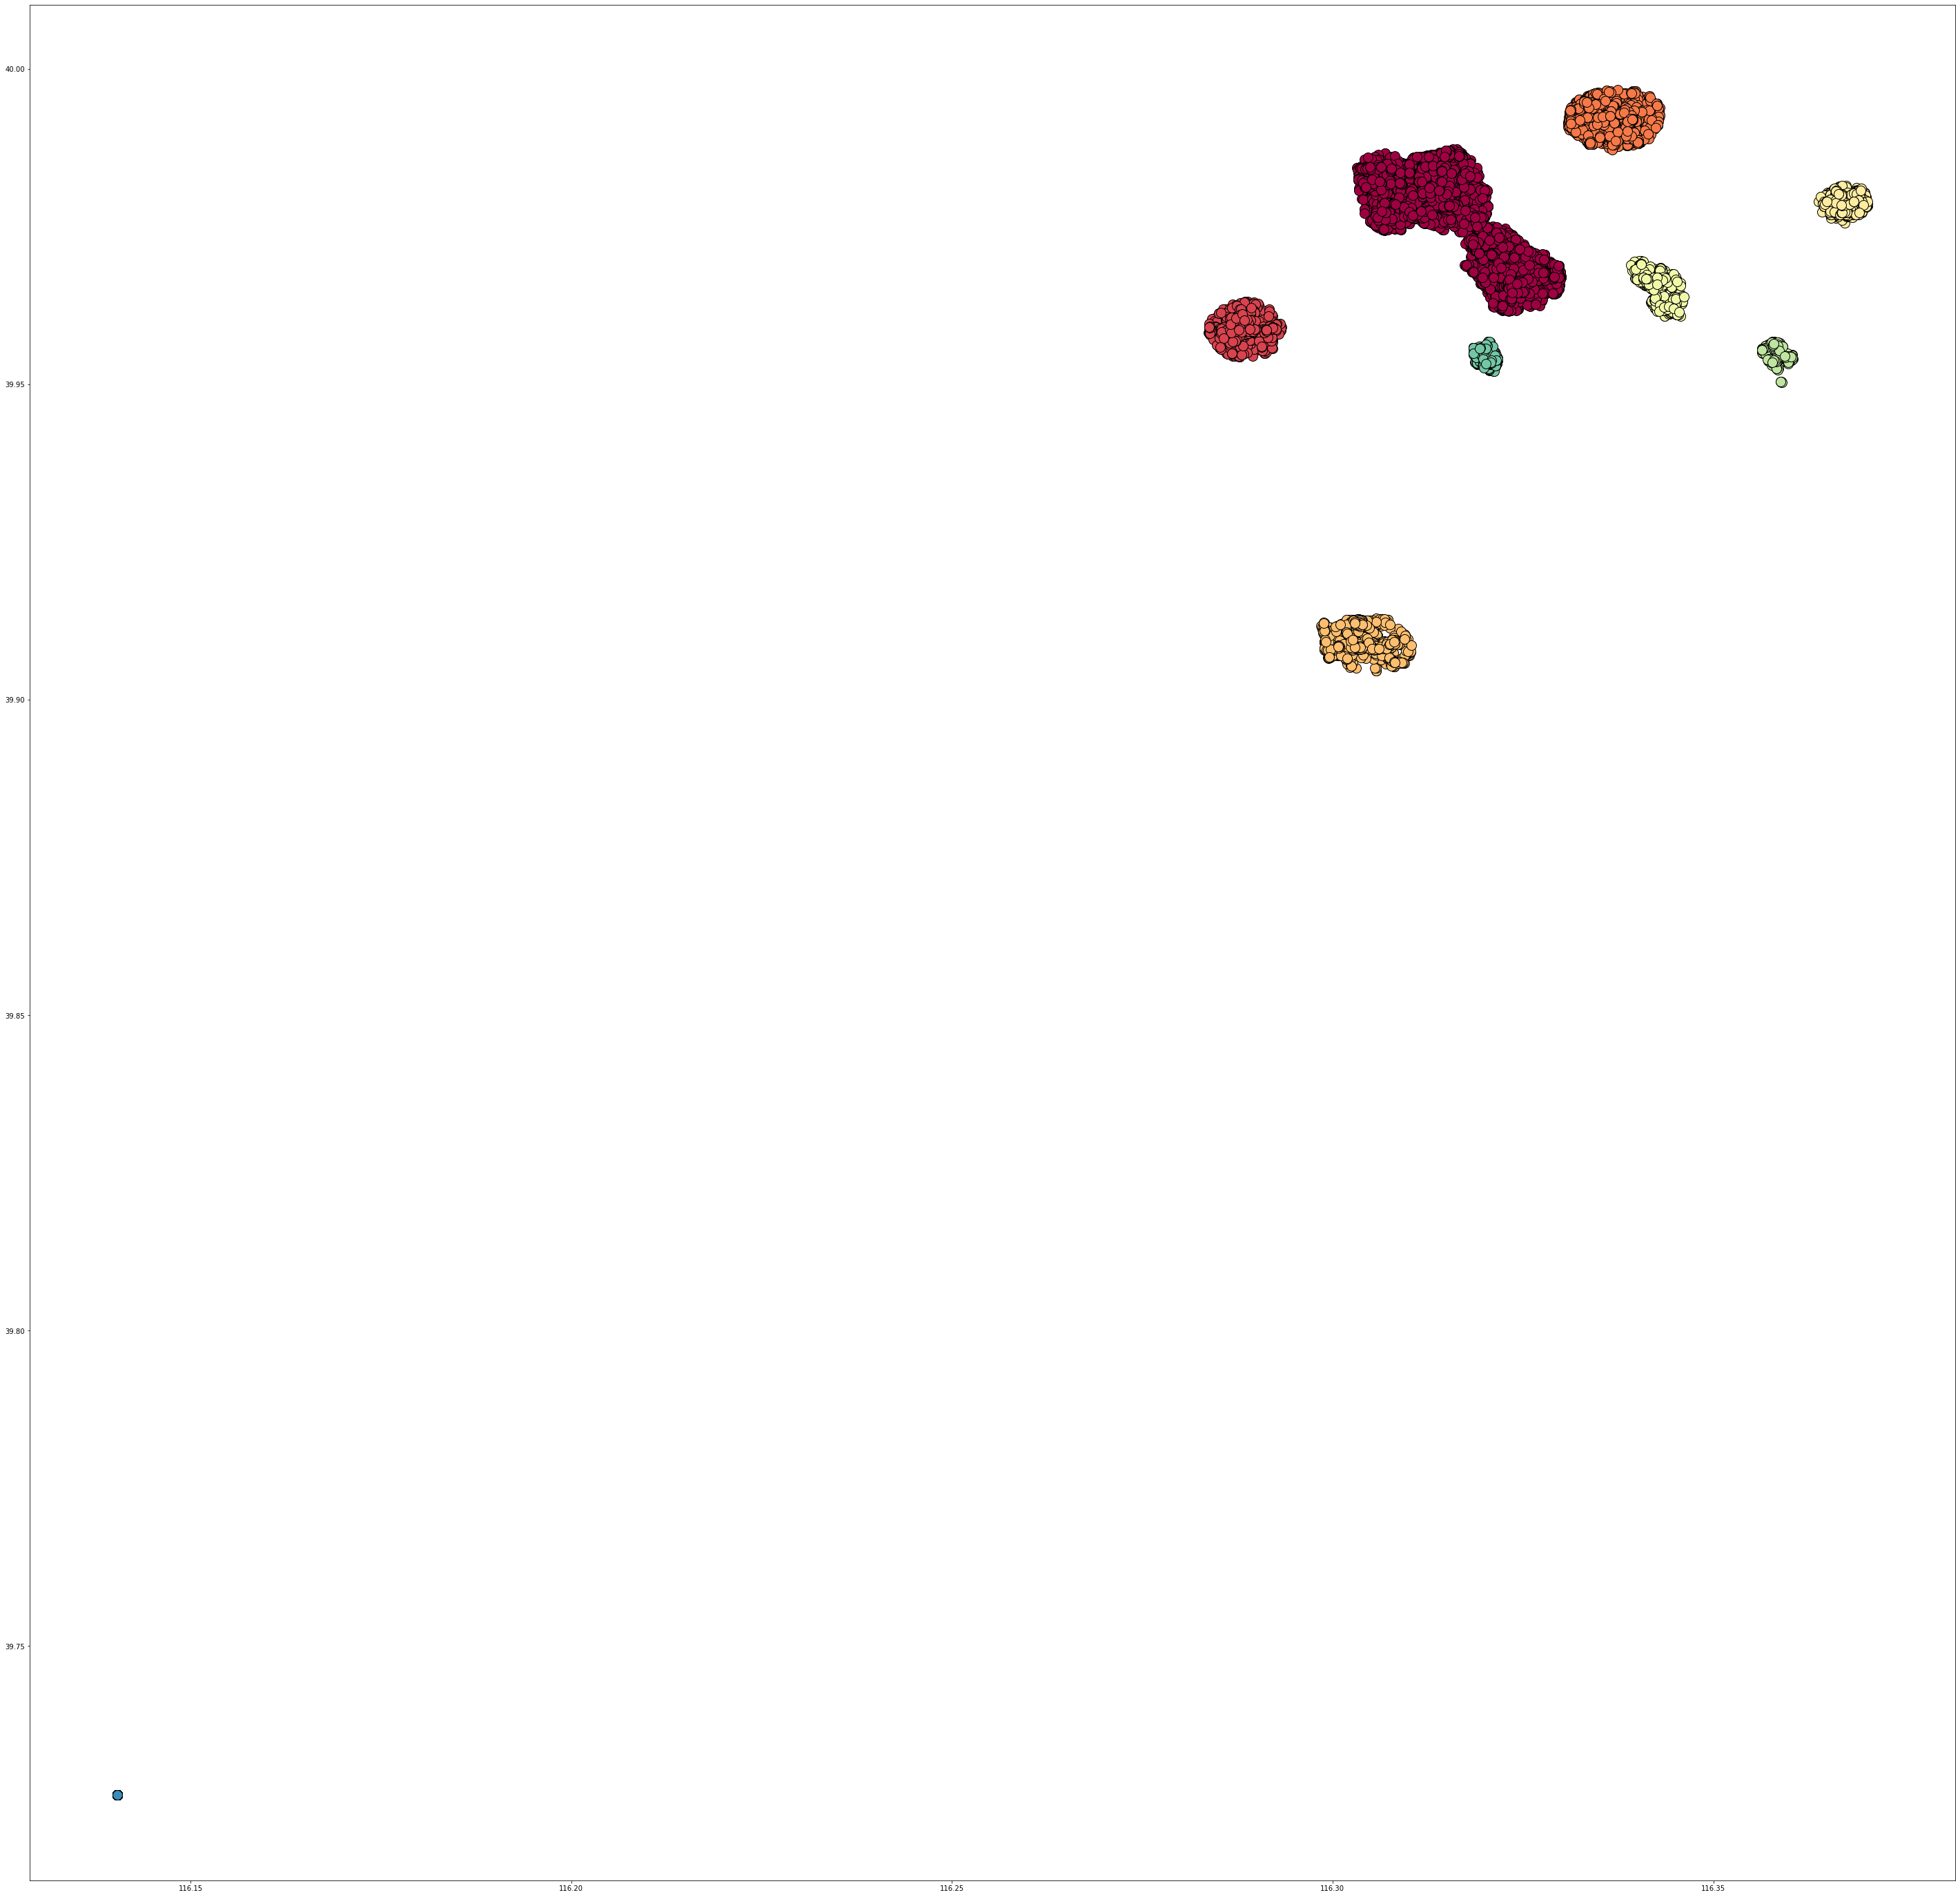

In [41]:
plt.figure(figsize=(50, 50))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k
    print(k)
    print(len(class_member_mask))

    xy = array_pt_hd[class_member_mask & core_samples_mask]
    print(len(xy))
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

# plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [53]:
df_2['labels'] = labels

In [56]:
df_2.loc[df_2['FID'].isin(db_1.core_sample_indices_),['core']] = 'core'

In [61]:
df_2['labels'] = labels
df_2.loc[df_2['FID'].isin(db_1.core_sample_indices_),['core']] = 'core'
df_2.loc[(df_2['labels']!=-1)&(df_2['core']=='core'),['core_label']] = df_2['labels']
df_2.to_csv(r'E:\project_basedata\2023data_research\basedata\Export_Output_2_hd_0411_m.csv',index = False, mode = 'w')

<>:1: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?
<>:1: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?
<ipython-input-61-f5d8007c2c97>:1: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?
  ['core_label']("=", "df_2['labels']")


TypeError: 'list' object is not callable

In [65]:
df_2.loc[(df_2['labels']!=-1)&(df_2['core']=='core'),['core_label']] = df_2['labels']

In [68]:
df_2.to_csv(r'E:\project_basedata\2023data_research\basedata\Export_Output_2_hd_0411_lon.csv',index = False, mode = 'w')

In [22]:
DBSCAN??

In [32]:
xy = array_pt_hd[0 & core_samples_mask]

In [42]:
db_1.core_sample_indices_

array([    18,     58,     82, ..., 250445, 250446, 250447], dtype=int64)

In [45]:
len(core_samples_mask)

250448

In [23]:
db_1.

DBSCAN(eps=0.0045, min_samples=2765)


In [47]:
labels

array([-1, -1, -1, ...,  8,  8,  8], dtype=int64)

In [52]:
array_pt_hd

array([[116.09133 ,  40.103298],
       [116.330358,  39.944725],
       [116.362142,  40.031223],
       ...,
       [116.140358,  39.726384],
       [116.140358,  39.726384],
       [116.140358,  39.726384]])

In [ ]:
array_pt_hd[class_member_mask & core_samples_mask]

In [49]:
len(class_member_mask)

250448

In [51]:
len(core_samples_mask)

250448

In [7]:
df_type = pd.read_excel(r'E:\project_basedata\2023data_research\ind_type\业态三级分类20230409.xlsx',dtype = 'str',sheet_name = '总表')

In [16]:
df_data_new = pd.read_csv(r'E:\project_basedata\2023data_research\ind_type\result20230409.csv',dtype = 'str')

In [17]:
df_data_new

,dianping_shops_2021.shop_id,dianping_shops_2021.status,dianping_shops_2021.name,dianping_shops_2021.branchname,dianping_shops_2021.alt_name,dianping_shops_2021.city_id,dianping_shops_2021.city,dianping_shops_2021.real_city,dianping_shops_2021.province,dianping_shops_2021.avg_price,dianping_shops_2021.area_code,dianping_shops_2021.phone,dianping_shops_2021.regionname,dianping_shops_2021.address,dianping_shops_2021.cross_road,dianping_shops_2021.big_category_id,dianping_shops_2021.big_category,dianping_shops_2021.small_category,dianping_shops_2021.star,dianping_shops_2021.longitude,dianping_shops_2021.latitude,dianping_shops_2021.score_text,dianping_shops_2021.score1,dianping_shops_2021.score2,dianping_shops_2021.score3,dianping_shops_2021.score4,dianping_shops_2021.review_count,dianping_shops_2021.bookable,dianping_shops_2021.has_takeaway,dianping_shops_2021.has_deals,dianping_shops_2021.dishtags,dianping_shops_2021.hours,dianping_shops_2021.tags,dianping_shops_2021.default_pic,dianping_shops_2021.updated,dianping_shops_2021.url
0,11199358,1,东田头皮管理中心,NaN,NaN,2,北京,北京,北京,NaN,10,65281568;65281366,密云区其他,东长安街东方广场东方新天地P-E1-01-08号,NaN,50,美肤美体,美发,0.0,116.415839,39.909354,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,http://qcloud.dpfile.com/pc/52vVkPp9_eLYK4BVjf...,2019-09-22,http://www.dianping.com/shop/11199358
1,11228213,1,雨润芳轩美容美体,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,朝阳区,农贸街,NaN,50,美肤美体,美容/SPA,0.0,116.50868,39.89338,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-12,http://www.dianping.com/shop/11228213
2,11230503,1,浩然靓点橄榄枝美发工作室,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,朝阳区,农贸街,NaN,50,美肤美体,美发,0.0,116.50868,39.89338,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-12,http://www.dianping.com/shop/11230503
3,11231113,1,琳鑫女人缘女子美容院,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,顺义区,迎宾路34号,NaN,50,美肤美体,SPA美体,0.0,116.63725,40.06478,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,周一至周日 10:00-21:00,NaN,http://p1.meituan.net/searchscenerec/268fcf0cf...,2021-05-09,http://www.dianping.com/shop/11231113
4,11231232,1,美依泉,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,顺义区,迎宾路34号,NaN,50,美肤美体,美容/SPA,0.0,116.63725,40.06478,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,http://p1.meituan.net/poi/a7d00f6b2d97a58285bf...,2020-08-03,http://www.dianping.com/shop/11231232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413150,1998975913,1,清华大学小家庭房,不带空调,NaN,2,北京,北京,北京,NaN,10,4000660190,五道口,成府路,NaN,-31582,酒店民宿,榛果民宿,0.0,116.325993,39.99521,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,https://img.meituan.net/phoenix/e3501487b29d94...,2020-08-24,http://www.dianping.com/shop/1998975913
1413151,1999102151,1,六里桥西客站北京天安门长阳地铁站干净两床房,NaN,NaN,2,北京,北京,北京,NaN,10,4000660190,长阳镇,怡和北路5号院,NaN,-31582,酒店民宿,榛果民宿,0.0,116.209893,39.763083,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,https://img.meituan.net/phoenix/4998a394c22567...,2020-10-02,http://www.dianping.com/shop/1999102151
1413152,1999306645,1,双井九龙花园宝缘温馨公寓个人新开纯男生公寓,NaN,NaN,2,北京,北京,北京,NaN,10,4000660190,双井,广渠路,NaN,-31582,酒店民宿,榛果民宿,0.0,116.470039,39.894377,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,https://img.meituan.net/iphoenix/64807bbe79214...,2020-10-01,http://www.dianping.com/shop/1999306645
1413153,1999721871,1,西直门人民医院地铁2号4号13号北欧套房,NaN,NaN,2,北京,北京,北京,NaN,10,4000660190,海淀区,文慧园西路36号,NaN,-31582,酒店民宿,榛果民宿,0.0,116.360507,39.951472,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,http://p0.meituan.net/iphoenix/5c1b34dec345ee5...,2020-10-02,http://www.dianping.com/shop/1999721871


In [20]:
df_yyy_type = pd.merge(left = df_data_new,right = df_type,left_on = ['dianping_shops_2021.big_category','dianping_shops_2021.small_category'],right_on = ['大类','小类'],how = 'left')
df_yyy_type.to_csv(r'E:\project_basedata\2023data_research\ind_type\new_type_merge_yyy_0409.csv',index = False)

In [21]:
df_yyy_type

,dianping_shops_2021.shop_id_x,dianping_shops_2021.status,dianping_shops_2021.name,dianping_shops_2021.branchname,dianping_shops_2021.alt_name,dianping_shops_2021.city_id,dianping_shops_2021.city,dianping_shops_2021.real_city,dianping_shops_2021.province,dianping_shops_2021.avg_price,dianping_shops_2021.area_code,dianping_shops_2021.phone,dianping_shops_2021.regionname,dianping_shops_2021.address,dianping_shops_2021.cross_road,dianping_shops_2021.big_category_id,dianping_shops_2021.big_category,dianping_shops_2021.small_category,dianping_shops_2021.star,dianping_shops_2021.longitude,dianping_shops_2021.latitude,dianping_shops_2021.score_text,dianping_shops_2021.score1,dianping_shops_2021.score2,dianping_shops_2021.score3,dianping_shops_2021.score4,dianping_shops_2021.review_count,dianping_shops_2021.bookable,dianping_shops_2021.has_takeaway,dianping_shops_2021.has_deals,dianping_shops_2021.dishtags,dianping_shops_2021.hours,dianping_shops_2021.tags,dianping_shops_2021.default_pic,dianping_shops_2021.updated,dianping_shops_2021.url,大类,中类,小类,dianping_shops_2021.shop_id_y
0,11199358,1,东田头皮管理中心,NaN,NaN,2,北京,北京,北京,NaN,10,65281568;65281366,密云区其他,东长安街东方广场东方新天地P-E1-01-08号,NaN,50,美肤美体,美发,0.0,116.415839,39.909354,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,http://qcloud.dpfile.com/pc/52vVkPp9_eLYK4BVjf...,2019-09-22,http://www.dianping.com/shop/11199358,美肤美体,美体,美发,40712
1,11228213,1,雨润芳轩美容美体,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,朝阳区,农贸街,NaN,50,美肤美体,美容/SPA,0.0,116.50868,39.89338,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-12,http://www.dianping.com/shop/11228213,美肤美体,美容,美容/SPA,19996
2,11230503,1,浩然靓点橄榄枝美发工作室,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,朝阳区,农贸街,NaN,50,美肤美体,美发,0.0,116.50868,39.89338,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-12,http://www.dianping.com/shop/11230503,美肤美体,美体,美发,40712
3,11231113,1,琳鑫女人缘女子美容院,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,顺义区,迎宾路34号,NaN,50,美肤美体,SPA美体,0.0,116.63725,40.06478,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,周一至周日 10:00-21:00,NaN,http://p1.meituan.net/searchscenerec/268fcf0cf...,2021-05-09,http://www.dianping.com/shop/11231113,美肤美体,美体,SPA美体,10213
4,11231232,1,美依泉,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,顺义区,迎宾路34号,NaN,50,美肤美体,美容/SPA,0.0,116.63725,40.06478,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,http://p1.meituan.net/poi/a7d00f6b2d97a58285bf...,2020-08-03,http://www.dianping.com/shop/11231232,美肤美体,美容,美容/SPA,19996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413150,1998975913,1,清华大学小家庭房,不带空调,NaN,2,北京,北京,北京,NaN,10,4000660190,五道口,成府路,NaN,-31582,酒店民宿,榛果民宿,0.0,116.325993,39.99521,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,https://img.meituan.net/phoenix/e3501487b29d94...,2020-08-24,http://www.dianping.com/shop/1998975913,酒店民宿,特色酒店,榛果民宿,13532
1413151,1999102151,1,六里桥西客站北京天安门长阳地铁站干净两床房,NaN,NaN,2,北京,北京,北京,NaN,10,4000660190,长阳镇,怡和北路5号院,NaN,-31582,酒店民宿,榛果民宿,0.0,116.209893,39.763083,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,https://img.meituan.net/phoenix/4998a394c22567...,2020-10-02,http://www.dianping.com/shop/1999102151,酒店民宿,特色酒店,榛果民宿,13532
1413152,1999306645,1,双井九龙花园宝缘温馨公寓个人新开纯男生公寓,NaN,NaN,2,北京,北京,北京,NaN,10,4000660190,双井,广渠路,NaN,-31582,酒店民宿,榛果民宿,0.0,116.470039,39.894377,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,https://img.meituan.net/iphoenix/64807bbe79214...,2020-10-01,http://www.dianping.com/shop/1999306645,酒店民宿,特色酒店,榛果民宿,13532
1413153,1999721871,1,西直门人民医院地铁2号4号13号北欧套房,NaN,NaN,2,北京,北京,北京,NaN,10,4000660190,海淀区,文慧园西路36号,NaN,-31582,酒店民宿,榛果民宿,0.0,116.360507,39.951472,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,http://p0.meituan.net/iphoenix/5c1b34dec345ee5...,2020-10-02,http://www.dianping.com/shop/1999721871,酒店民宿,特色酒店,榛果民宿,13532


In [22]:
df_yyy_type_1 = df_yyy_type.loc[:,['dianping_shops_2021.shop_id_x','dianping_shops_2021.name','dianping_shops_2021.regionname','dianping_shops_2021.longitude','dianping_shops_2021.latitude','大类','中类','小类']]

In [24]:
df_yyy_type_1.to_csv(r'E:\project_basedata\2023data_research\ind_type\new_type_fit_gis_0409.csv',index = False)

In [18]:
df_type

,大类,中类,小类,dianping_shops_2021.shop_id
0,亲子服务,亲子游乐,上门拍,31
1,亲子服务,幼儿教育,乐高,156
2,亲子服务,孕产护理,产后恢复,839
3,亲子服务,亲子游乐,亲子DIY,342
4,亲子服务,亲子游乐,亲子会所,26
...,...,...,...,...
651,餐饮生鲜,美食,鱼鲜,1
652,餐饮生鲜,美食,鲁菜,1204
653,餐饮生鲜,美食,麻辣烫,9524
654,餐饮生鲜,美食,黄焖鸡,3233


In [9]:
pd.set_option('display.max_columns', 100)

In [4]:
df_1 = pd.read_csv(r'E:\project_basedata\2023data_research\basedata\result20230407.csv',dtype = 'str')
df_1.loc[df_1['dianping_shops_2021.name'].isnull()]

,dianping_shops_2021.shop_id,dianping_shops_2021.status,dianping_shops_2021.name,dianping_shops_2021.branchname,dianping_shops_2021.alt_name,dianping_shops_2021.city_id,dianping_shops_2021.city,dianping_shops_2021.real_city,dianping_shops_2021.province,dianping_shops_2021.avg_price,...,dianping_shops_2021.review_count,dianping_shops_2021.bookable,dianping_shops_2021.has_takeaway,dianping_shops_2021.has_deals,dianping_shops_2021.dishtags,dianping_shops_2021.hours,dianping_shops_2021.tags,dianping_shops_2021.default_pic,dianping_shops_2021.updated,dianping_shops_2021.url


In [15]:
df_1

,dianping_shops_2021.shop_id,dianping_shops_2021.status,dianping_shops_2021.name,dianping_shops_2021.branchname,dianping_shops_2021.alt_name,dianping_shops_2021.city_id,dianping_shops_2021.city,dianping_shops_2021.real_city,dianping_shops_2021.province,dianping_shops_2021.avg_price,dianping_shops_2021.area_code,dianping_shops_2021.phone,dianping_shops_2021.regionname,dianping_shops_2021.address,dianping_shops_2021.cross_road,dianping_shops_2021.big_category_id,dianping_shops_2021.big_category,dianping_shops_2021.small_category,dianping_shops_2021.star,dianping_shops_2021.longitude,dianping_shops_2021.latitude,dianping_shops_2021.score_text,dianping_shops_2021.score1,dianping_shops_2021.score2,dianping_shops_2021.score3,dianping_shops_2021.score4,dianping_shops_2021.review_count,dianping_shops_2021.bookable,dianping_shops_2021.has_takeaway,dianping_shops_2021.has_deals,dianping_shops_2021.dishtags,dianping_shops_2021.hours,dianping_shops_2021.tags,dianping_shops_2021.default_pic,dianping_shops_2021.updated,dianping_shops_2021.url
0,11199358,1,东田头皮管理中心,NaN,NaN,2,北京,北京,北京,NaN,10,65281568;65281366,密云区其他,东长安街东方广场东方新天地P-E1-01-08号,NaN,50,美肤美体,美发,0.0,116.415839,39.909354,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,http://qcloud.dpfile.com/pc/52vVkPp9_eLYK4BVjf...,2019-09-22,http://www.dianping.com/shop/11199358
1,11228213,1,雨润芳轩美容美体,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,朝阳区,农贸街,NaN,50,美肤美体,美容/SPA,0.0,116.50868,39.89338,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-12,http://www.dianping.com/shop/11228213
2,11230503,1,浩然靓点橄榄枝美发工作室,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,朝阳区,农贸街,NaN,50,美肤美体,美发,0.0,116.50868,39.89338,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-12,http://www.dianping.com/shop/11230503
3,11231113,1,琳鑫女人缘女子美容院,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,顺义区,迎宾路34号,NaN,50,美肤美体,SPA美体,0.0,116.63725,40.06478,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,周一至周日 10:00-21:00,NaN,http://p1.meituan.net/searchscenerec/268fcf0cf...,2021-05-09,http://www.dianping.com/shop/11231113
4,11231232,1,美依泉,NaN,NaN,2,北京,北京,北京,NaN,10,NaN,顺义区,迎宾路34号,NaN,50,美肤美体,美容/SPA,0.0,116.63725,40.06478,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,http://p1.meituan.net/poi/a7d00f6b2d97a58285bf...,2020-08-03,http://www.dianping.com/shop/11231232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416425,1998975913,1,清华大学小家庭房,不带空调,NaN,2,北京,北京,北京,NaN,10,4000660190,五道口,成府路,NaN,-31582,酒店民宿,榛果民宿,0.0,116.325993,39.99521,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,https://img.meituan.net/phoenix/e3501487b29d94...,2020-08-24,http://www.dianping.com/shop/1998975913
1416426,1999102151,1,六里桥西客站北京天安门长阳地铁站干净两床房,NaN,NaN,2,北京,北京,北京,NaN,10,4000660190,长阳镇,怡和北路5号院,NaN,-31582,酒店民宿,榛果民宿,0.0,116.209893,39.763083,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,https://img.meituan.net/phoenix/4998a394c22567...,2020-10-02,http://www.dianping.com/shop/1999102151
1416427,1999306645,1,双井九龙花园宝缘温馨公寓个人新开纯男生公寓,NaN,NaN,2,北京,北京,北京,NaN,10,4000660190,双井,广渠路,NaN,-31582,酒店民宿,榛果民宿,0.0,116.470039,39.894377,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,https://img.meituan.net/iphoenix/64807bbe79214...,2020-10-01,http://www.dianping.com/shop/1999306645
1416428,1999721871,1,西直门人民医院地铁2号4号13号北欧套房,NaN,NaN,2,北京,北京,北京,NaN,10,4000660190,海淀区,文慧园西路36号,NaN,-31582,酒店民宿,榛果民宿,0.0,116.360507,39.951472,NaN,NaN,NaN,NaN,NaN,0.0,False,False,False,NaN,NaN,NaN,http://p0.meituan.net/iphoenix/5c1b34dec345ee5...,2020-10-02,http://www.dianping.com/shop/1999721871


In [13]:
df_yyy = df_1.loc[:,['dianping_shops_2021.name','dianping_shops_2021.longitude','dianping_shops_2021.latitude']]
df_yyy.to_csv(r'E:\project_basedata\2023data_research\basedata\new_data_yyy0409.csv',index = False)

In [7]:
df_2

,FID,OBJECTID,Join_Count,TARGET_FID,JOIN_FID,dianping_s,dianping_1,dianping_2,dianping_3,dianping_4,dianping_5,dianping_6,dianping_7,dianping_8,dianping_9,dianpin_10,PAC,NAME,省代码_,省_1,市代码_,市_1,类型_1,x,y
0,0,29,1,29,5,11198005,龙泉寺,密云区其他,景点,名胜古迹,0.0,116.091330,40.103298,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.793421e+07,4.453444e+06
1,1,60,1,60,5,11228746,石刻艺术馆,海淀区,景点,展馆展览,0.0,116.330358,39.944725,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795566e+07,4.437022e+06
2,2,817,1,817,5,11233526,中国移动,清河,生活服务,移动营业厅,0.0,116.362142,40.031223,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795780e+07,4.446797e+06
3,3,3721,1,3721,5,11237007,Semir,西北旺,购物,服装,3.0,116.224251,40.076557,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.794573e+07,4.451132e+06
4,4,4159,1,4159,5,11237525,东方鸿睿生态农业,通州区,景点,其他景点,0.0,116.287544,39.927243,0.00,0.00,0.00,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795212e+07,4.434861e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250443,250443,1705217,1,1705217,5,99044917,家乡手擀面,良乡,美食,粉面馆,3.0,116.140358,39.726384,3.57,3.58,3.58,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795330e+07,4.435468e+06
250444,250444,1705236,1,1705236,5,99044917,家乡手擀面,良乡,美食,粉面馆,3.0,116.140358,39.726384,3.57,3.58,3.58,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795631e+07,4.439939e+06
250445,250445,1705245,1,1705245,5,99044917,家乡手擀面,良乡,美食,粉面馆,3.0,116.140358,39.726384,3.57,3.58,3.58,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795406e+07,4.440806e+06
250446,250446,1705247,1,1705247,5,99044917,家乡手擀面,良乡,美食,粉面馆,3.0,116.140358,39.726384,3.57,3.58,3.58,110108,海淀区,110000,北京市,110000,北京市,直辖市,3.795820e+07,4.437926e+06


In [69]:
# 读取北京市海淀区的大众点评点位数据
pd.set_option('display.max_columns', 100)
df_1 = pd.read_csv(r'E:\project_basedata\2023data_research\basedata\Export_Output_2.csv')
df_2 = pd.read_csv(r'E:\project_basedata\2023data_research\basedata\Export_Output_2_hd.csv')
df_hd = df_1.loc[df_1['NAME'] == '海淀区']
df_hd_2 = df_2.loc[:,['x','y']]
point = df_hd.loc[:,['dianping_6','dianping_7']]
point_1 = df_hd.loc[:,['dianping_7','dianping_6']]
ls_pt_2 = df_hd_2.values.tolist()
ls_pt = point_1.values.tolist()

In [70]:
db = DBSCAN(eps=500, min_samples=2765).fit(ls_pt_2) # 调用sklearn库里的dbscan

In [71]:
labels = db.labels_

In [72]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [73]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

In [74]:
ls_pt_2 = np.array(ls_pt_2)

In [ ]:
plt.figure(figsize=(50, 50))
plt.xlabel('经度投影坐标', fontproperties='KaiTi')
plt.ylabel('纬度投影坐标', fontproperties='KaiTi')
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k
    print(k)
    print(len(class_member_mask))

    xy = ls_pt_2[class_member_mask & core_samples_mask]
    print(len(xy))
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = ls_pt_2[class_member_mask & ~core_samples_mask]
    print(len(xy))
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [76]:
df_2['labels'] = labels
df_2.loc[df_2['FID'].isin(db_1.core_sample_indices_),['core']] = 'core'
df_2.loc[(df_2['labels']!=-1)&(df_2['core']=='core'),['core_label']] = df_2['labels']
df_2.to_csv(r'E:\project_basedata\2023data_research\basedata\Export_Output_2_hd_0411_m.csv',index = False, mode = 'w')